# Chignolin

In [37]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

# Print 
from IPython.display import Markdown, display
import multiprocessing

from collections import Counter

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

## Auxiliary functions

In [988]:
def get_trans_paths_md(dtrajs):
    
    macro_traj = []

    for micro in dtrajs[0]:
        if micro in stateA:
            macro_traj.append(0)
        elif micro in stateB:
            macro_traj.append(2)
        else:
            macro_traj.append(1)
            
    traj = dtrajs[0]
    int_trajs = []
    int_trajs_nonprod = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(macro_traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if macro_traj[i+1] in [0,2]:
                in_int = False
                int_end = macro_traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif macro_traj[i] != macro_traj[i+1]:
            if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                in_int = True
                int_start = macro_traj[i]
                
    return int_trajs         

def get_trans_paths_md_nonprod(dtrajs):
    
    macro_traj = []

    for micro in dtrajs[0]:
        if micro in stateA:
            macro_traj.append(0)
        elif micro in stateB:
            macro_traj.append(2)
        else:
            macro_traj.append(1)
            
    traj = dtrajs[0]
    int_trajs = []
    int_trajs_nonprod = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(macro_traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if macro_traj[i+1] in [0,2]:
                in_int = False
                int_end = macro_traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                else:
                    int_trajs_nonprod.append(int_traj)    
                int_traj = []
        elif macro_traj[i] != macro_traj[i+1]:
            if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                in_int = True
                int_start = macro_traj[i]
                
    return int_trajs, int_trajs_nonprod

def get_trans_paths_md_wdirectpaths(dtrajs):
    
    # this returns direct pathways too, hence keeps the start and final macrostate frames in the paths
    
    macro_traj = []

    for micro in dtrajs[0]:
        if micro in stateA:
            macro_traj.append(0)
        elif micro in stateB:
            macro_traj.append(2)
        else:
            macro_traj.append(1)
            
    traj = dtrajs[0]
    int_trajs = []
    int_trajs_nonprod = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(macro_traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if macro_traj[i+1] in [0,2]:
                in_int = False
                int_end = macro_traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif macro_traj[i] != macro_traj[i+1]:
            if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                in_int = True
                int_start = macro_traj[i]
            elif macro_traj[i] in [0,2] and macro_traj[i+1] in [0,2]:
                int_trajs.append([traj[i],traj[i+1]])    
                
    return int_trajs      

def get_trans_paths_msm(msm, lags, min_paths=1000):

    int_trajs_all = []

    for msm_index in range(len(msm)):

        print('lag: %d' % lags[msm_index])

        count = 0

        int_trajs = []

        while len(int_trajs) < min_paths:
            traj = msm[msm_index].simulate(np.int(100000))
            macro_traj = []

            for micro in traj:
                if micro in stateA:
                    macro_traj.append(0)
                elif micro in stateB:
                    macro_traj.append(2)
                else:
                    macro_traj.append(1)

            transition = False

            if len(set(macro_traj)) == 3:
                transition = True

            if transition:
                count += 1

            # print(count)

            if transition:
                int_traj = []
                in_int = False
                int_start = None
                int_end = None
                for i in range(len(macro_traj) - 1):
                    if in_int:
                        int_traj.append(traj[i])
                        if macro_traj[i+1] in [0,2]:
                            in_int = False
                            int_end = macro_traj[i+1]
                            if int_end != int_start:
                                int_trajs.append(int_traj)
                            int_traj = []
                    elif macro_traj[i] != macro_traj[i+1]:
                        if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                            in_int = True
                            int_start = macro_traj[i]

            print(len(int_trajs))              

        int_trajs_all.append(int_trajs)
        
    return int_trajs_all

def get_trans_paths_msm_wdirect(msm, lags, min_paths=1000):

    int_trajs_all = []
    int_trajs_all_nonprod = []
    direct_counts = []
    total_counts = []

    for msm_index in range(len(msm)):

        print('lag: %d' % lags[msm_index])

        #count = 0

        int_trajs = []
        int_trajs_nonprod = []
        direct_count = 0
        total_count = 0

        while len(int_trajs) < min_paths:
            traj = msm[msm_index].simulate(np.int(100000))
            macro_traj = []

            for micro in traj:
                if micro in stateA:
                    macro_traj.append(0)
                elif micro in stateB:
                    macro_traj.append(2)
                else:
                    macro_traj.append(1)

#             transition = False

#             if len(set(macro_traj)) == 3:
#                 transition = True

#             if transition:
#                 count += 1

            # print(count)
    
            # count number of trajectories
            total_count += 1

            #if transition:
            int_traj = []
            in_int = False
            int_start = None
            int_end = None
            for i in range(len(macro_traj) - 1):
                if in_int:
                    int_traj.append(traj[i])
                    if macro_traj[i+1] in [0,2]:
                        in_int = False
                        int_end = macro_traj[i+1]
                        if int_end != int_start:
                            int_trajs.append(int_traj)
                        else:
                            int_trajs_nonprod.append(int_traj)
                        int_traj = []
                elif macro_traj[i] != macro_traj[i+1]:
                    if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                        in_int = True
                        int_start = macro_traj[i]
                    elif macro_traj[i] in [0,2] and macro_traj[i+1] in [0,2]:
                        direct_count += 1

            print(len(int_trajs))              

        int_trajs_all.append(int_trajs)
        int_trajs_all_nonprod.append(int_trajs_nonprod)
        direct_counts.append(direct_count)
        total_counts.append(total_count)
        
    return int_trajs_all, int_trajs_all_nonprod, direct_counts, total_counts

def get_trans_paths_msm_wdirectpaths(msm, lags, min_paths=1000):

    int_trajs_all = []

    for msm_index in range(len(msm)):

        print('lag: %d' % lags[msm_index])

        count = 0
        direct_count = 0

        int_trajs = []

        while len(int_trajs)-direct_count < min_paths:
            traj = msm[msm_index].simulate(np.int(100000))
            macro_traj = []

            for micro in traj:
                if micro in stateA:
                    macro_traj.append(0)
                elif micro in stateB:
                    macro_traj.append(2)
                else:
                    macro_traj.append(1)

            transition = False

            if len(set(macro_traj)) == 3:
                transition = True

            #if transition:
             #   count += 1

            # print(count)

            #if transition:
            if True:
                int_traj = []
                in_int = False
                int_start = None
                int_end = None
                for i in range(len(macro_traj) - 1):
                    if in_int:
                        int_traj.append(traj[i])
                        if macro_traj[i+1] in [0,2]:
                            in_int = False
                            int_end = macro_traj[i+1]
                            if int_end != int_start:
                                int_trajs.append(int_traj)
                            int_traj = []
                    elif macro_traj[i] != macro_traj[i+1]:
                        if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                            in_int = True
                            int_start = macro_traj[i]
                        elif macro_traj[i] in [0,2] and macro_traj[i+1] in [0,2]:
                            int_trajs.append([traj[i],traj[i+1]])
                            direct_count += 1

            print(len(int_trajs))              

        int_trajs_all.append(int_trajs)
        
    return int_trajs_all

def count_md_bootstrap(int_trajs, n_samples=1000):
    
    bootstrap_counts = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for bootstrap in range(n_samples):

        int_trajs_ = np.random.choice(int_trajs, len(int_trajs))
        
        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])
        counts = [counter[i] for i in range(10)]
        counts = np.array(counts) / np.sum(counts)

        bootstrap_counts.append(counts)
        
    return bootstrap_counts

def count_md_bootstrap_wdirectpaths(int_trajs, n_samples=1000):
    
    bootstrap_counts = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for bootstrap in range(n_samples):

        int_trajs_ = np.random.choice(int_trajs, len(int_trajs))

        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in [x for x in np.concatenate(int_trajs_) if x in int_trajs_sorted]])
        counts = [counter[i] for i in range(10)]
        counts = np.array(counts) / len(np.concatenate(int_trajs_))

        bootstrap_counts.append(counts)
        
    return bootstrap_counts

def count_msm(int_trajs_msm, msm):
    
    counts_all = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for msm_index in range(len(msm)):

        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_msm[msm_index])])
        counts = [counter[i] for i in range(10)]
        counts = np.array(counts) / np.sum(counts)

        counts_all.append(counts)
        
    return counts_all

def count_msm_wdirectpaths(int_trajs_msm, msm):
    
    counts_all = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for msm_index in range(len(msm)):
        
        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in [x for x in np.concatenate(int_trajs_msm[msm_index]) if x in int_trajs_sorted]])
        counts = [counter[i] for i in range(10)]
        counts = np.array(counts) / len(np.concatenate(int_trajs_msm[msm_index]))
    
        counts_all.append(counts)
        
    return counts_all

def get_trans_paths_nm(path_ensemble, nm_model):

    int_trajs_all_nm = []

    for traj in path_ensemble:
        int_trajs = []

        int_traj = []
        in_int = False
        int_start = None
        int_end = None
        for i in range(len(traj) - 1):
            if in_int:
                int_traj.append(traj[i])
                if traj[i+1] in nm_model.stateA+nm_model.stateB:
                    in_int = False
                    int_end = traj[i+1]
                    if int_end != int_start:
                        int_trajs.append(int_traj)
                    int_traj = []
            elif traj[i] in nm_model.stateA+nm_model.stateB and traj[i+1] in [x for x in range(12) if x not in nm_model.stateA+nm_model.stateB]:
                in_int = True
                int_start = traj[i] 
            
        int_trajs_all_nm.append(int_trajs)
        
    # the nm_model has renumbered microstates - translate to original labels
    trans_dict = dict()

    for i in range(len(dtrajs[0])):
        if dtrajs[0][i] in [x for x in list(range(100)) if x not in (stateA+stateB)]:
            if nm_model.trajectories[0][i] not in trans_dict:
                trans_dict[nm_model.trajectories[0][i]] = dtrajs[0][i]
        if len(trans_dict) == 10:
            break
            
    int_trajs_nm = []

    for x in int_trajs_all_nm:
        for traj in x:
            int_trajs_nm.append([])
            for i in traj:
                int_trajs_nm[-1].append(trans_dict[i])            
    
    return int_trajs_nm

def get_trans_paths_nm_wdirectpaths(path_ensemble, nm_model):

    int_trajs_all_nm = []

    for traj in path_ensemble:
        int_trajs = []

        int_traj = []
        in_int = False
        int_start = None
        int_end = None
        for i in range(len(traj) - 1):
            if in_int:
                int_traj.append(traj[i])
                if traj[i+1] in nm_model.stateA+nm_model.stateB:
                    in_int = False
                    int_end = traj[i+1]
                    if int_end != int_start:
                        int_trajs.append(int_traj)
                    int_traj = []
            elif traj[i] != traj[i+1]:        
                if traj[i] in nm_model.stateA+nm_model.stateB and traj[i+1] in [x for x in range(12) if x not in nm_model.stateA+nm_model.stateB]:
                    in_int = True
                    int_start = traj[i]
                elif traj[i] in nm_model.stateA+nm_model.stateB and traj[i+1] in nm_model.stateA+nm_model.stateB:
                    int_trajs.append([traj[i],traj[i+1]])    
            
        int_trajs_all_nm.append(int_trajs)
        
    # the nm_model has renumbered microstates - translate to original labels
    trans_dict = dict()

    for i in range(len(dtrajs[0])):
        if nm_model.trajectories[0][i] not in trans_dict:
            trans_dict[nm_model.trajectories[0][i]] = dtrajs[0][i]
        if len(trans_dict) == 12:
            break
            
    int_trajs_nm = []

    for x in int_trajs_all_nm:
        for traj in x:
            int_trajs_nm.append([])
            for i in traj:
                int_trajs_nm[-1].append(trans_dict[i])            
    
    return int_trajs_nm

def count_nm(int_trajs_nm):
    
    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_nm)])
    counts = [counter[i] for i in range(10)]
    counts = np.array(counts) / np.sum(counts)

    return counts

def count_nm_wdirectpaths(int_trajs_nm):
    
    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]
    
    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in [x for x in np.concatenate(int_trajs_nm) if x in int_trajs_sorted]])
    counts = [counter[i] for i in range(10)]
    counts = np.array(counts) / len(np.concatenate(int_trajs_nm))

    return counts

def weighted_fundamental_sequences_md(fs_list):
    
    element_count = {}
    tot_count = 0
    for element in fs_list:
        pseudo_index = tuple(element)
        tot_count += 1
        if pseudo_index not in element_count:
            element_count[pseudo_index] = 1
        else:
            element_count[pseudo_index] += 1

    weights = []
    new_fs_list = []
    for key, value in element_count.items():
        new_fs_list.append(key)
        weights.append(value / float(tot_count))

    reversed_sorted_weights, reversed_sorted_new_fs_list = \
        reverse_sort_lists(weights, new_fs_list)

    return reversed_sorted_new_fs_list, reversed_sorted_weights

def kl_divergence(x,y):
    suma=0
    
    size = len(x)
    assert(size == len(y))
    
    for i,xi in enumerate(x):
        suma += xi * np.log(xi/y[i])

    return suma

def rmse(x,y):
    sum_of_squares=0
    
    size = len(x)
    assert(size == len(y))
    
    for i,xi in enumerate(x):
        sum_of_squares += (xi-y[i])**2

    return np.sqrt(sum_of_squares/size)

## Reading Data

In [1021]:
dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/chignolin/chignolin_dtrajs_lag10ns.npy")

#unfolded
stateA = [1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 16, 17, 18, 20, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99]

#folded
stateB = [0, 8, 12, 21, 23, 24, 31, 35, 39, 41, 43, 44, 52, 55, 64, 65, 70, 71, 72, 78, 84, 85]

## MSM estimation

In [964]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

## p(x|TP)

In [ ]:
# MD

In [1022]:
int_trajs = get_trans_paths_md(dtrajs)

In [1023]:
len(int_trajs)

210

In [1024]:
bootstrap_counts = count_md_bootstrap(int_trajs, n_samples=1000)

In [1025]:
# MSM

In [1026]:
int_trajs_msm = get_trans_paths_msm(msm, lags)

lag: 1
148
290
426
578
725
916
1085
lag: 5
273
538
780
1050
lag: 10
313
596
943
1291
lag: 20
434
787
1196
lag: 50
552
1136
lag: 250
778
1572
lag: 500
906
1805
lag: 1000
980
1943
lag: 5000
912
1794


In [1027]:
[len(x) for x in int_trajs_msm]

[1085, 1050, 1291, 1196, 1136, 1572, 1805, 1943, 1794]

In [1028]:
counts_msm = count_msm(int_trajs_msm, msm)

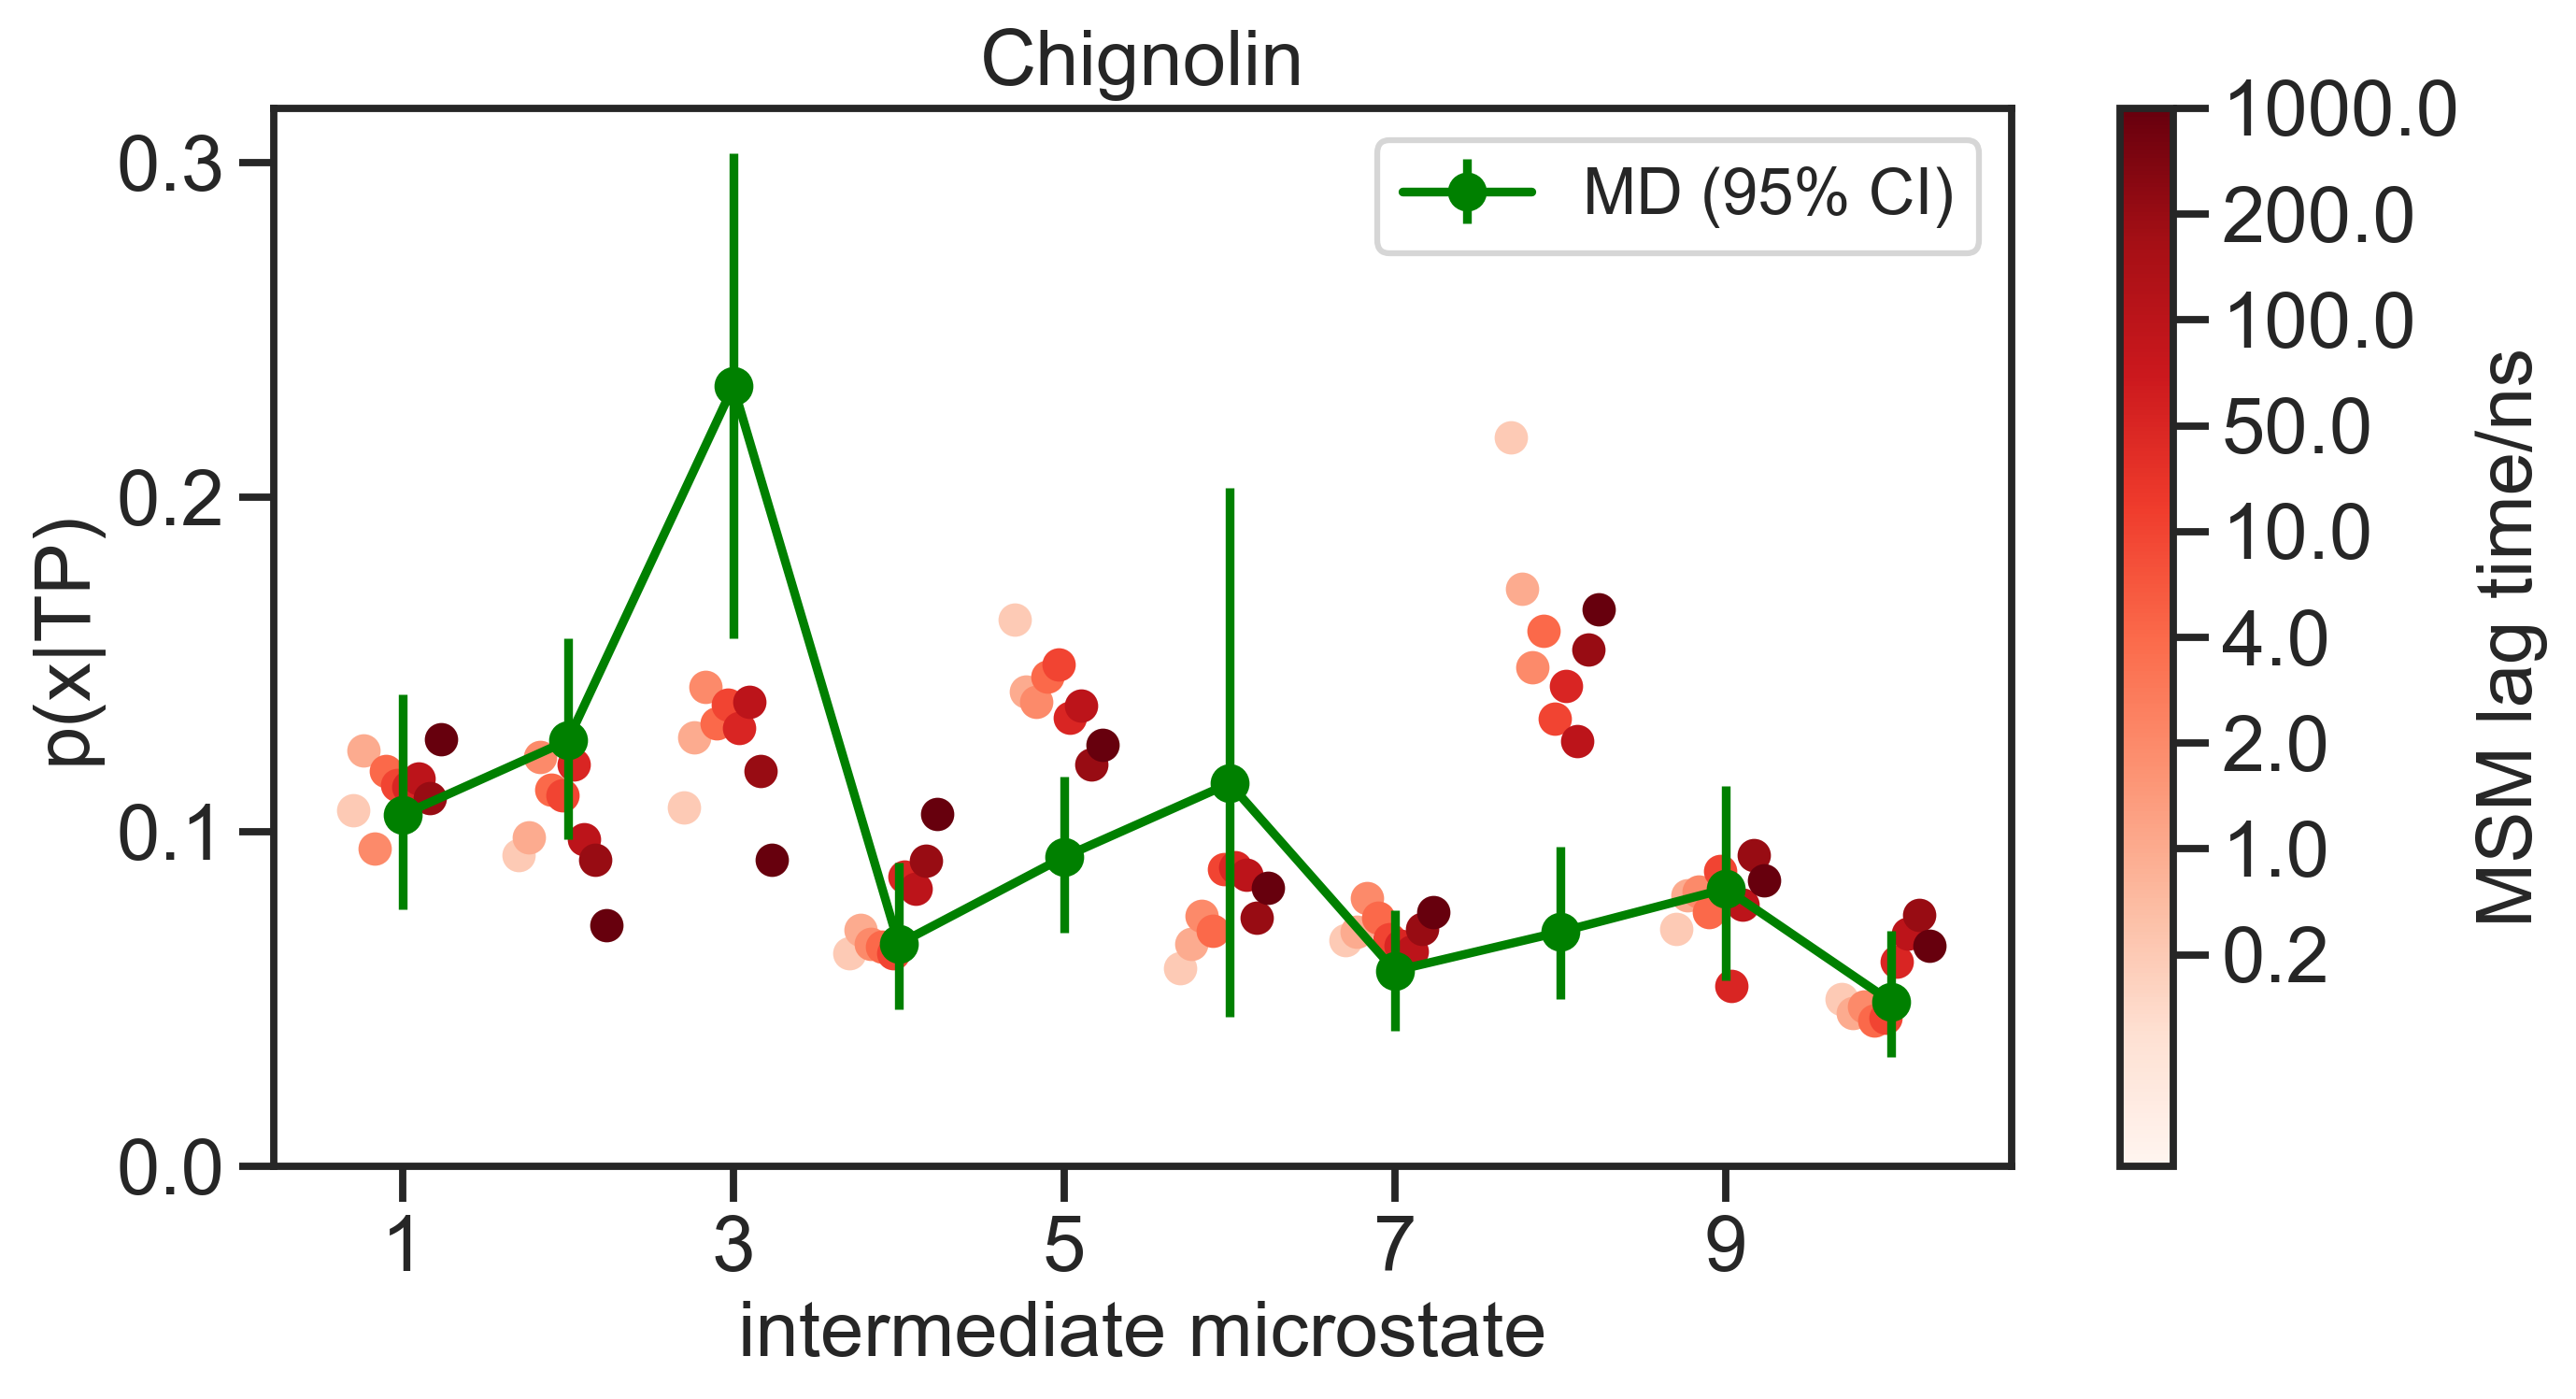

In [267]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], marker='o', color='green', label='MD (95% CI)')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,11,2), fontsize=20)
plt.yticks(np.arange(0, 0.4, 0.1), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [38]:
# haMSM

In [1029]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [1030]:
my_path_ensembleAB = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixAB(), nm_model.stateA, nm_model.stateB, n_paths=1000)
my_path_ensembleBA = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixBA(), nm_model.stateB, nm_model.stateA, n_paths=1000)

In [1031]:
path_ensemble = my_path_ensembleAB.trajectories + my_path_ensembleBA.trajectories

int_trajs_nm = get_trans_paths_nm(path_ensemble, nm_model)

In [1032]:
len(int_trajs_nm)

1061

In [1033]:
counts_nm = count_nm(int_trajs_nm)

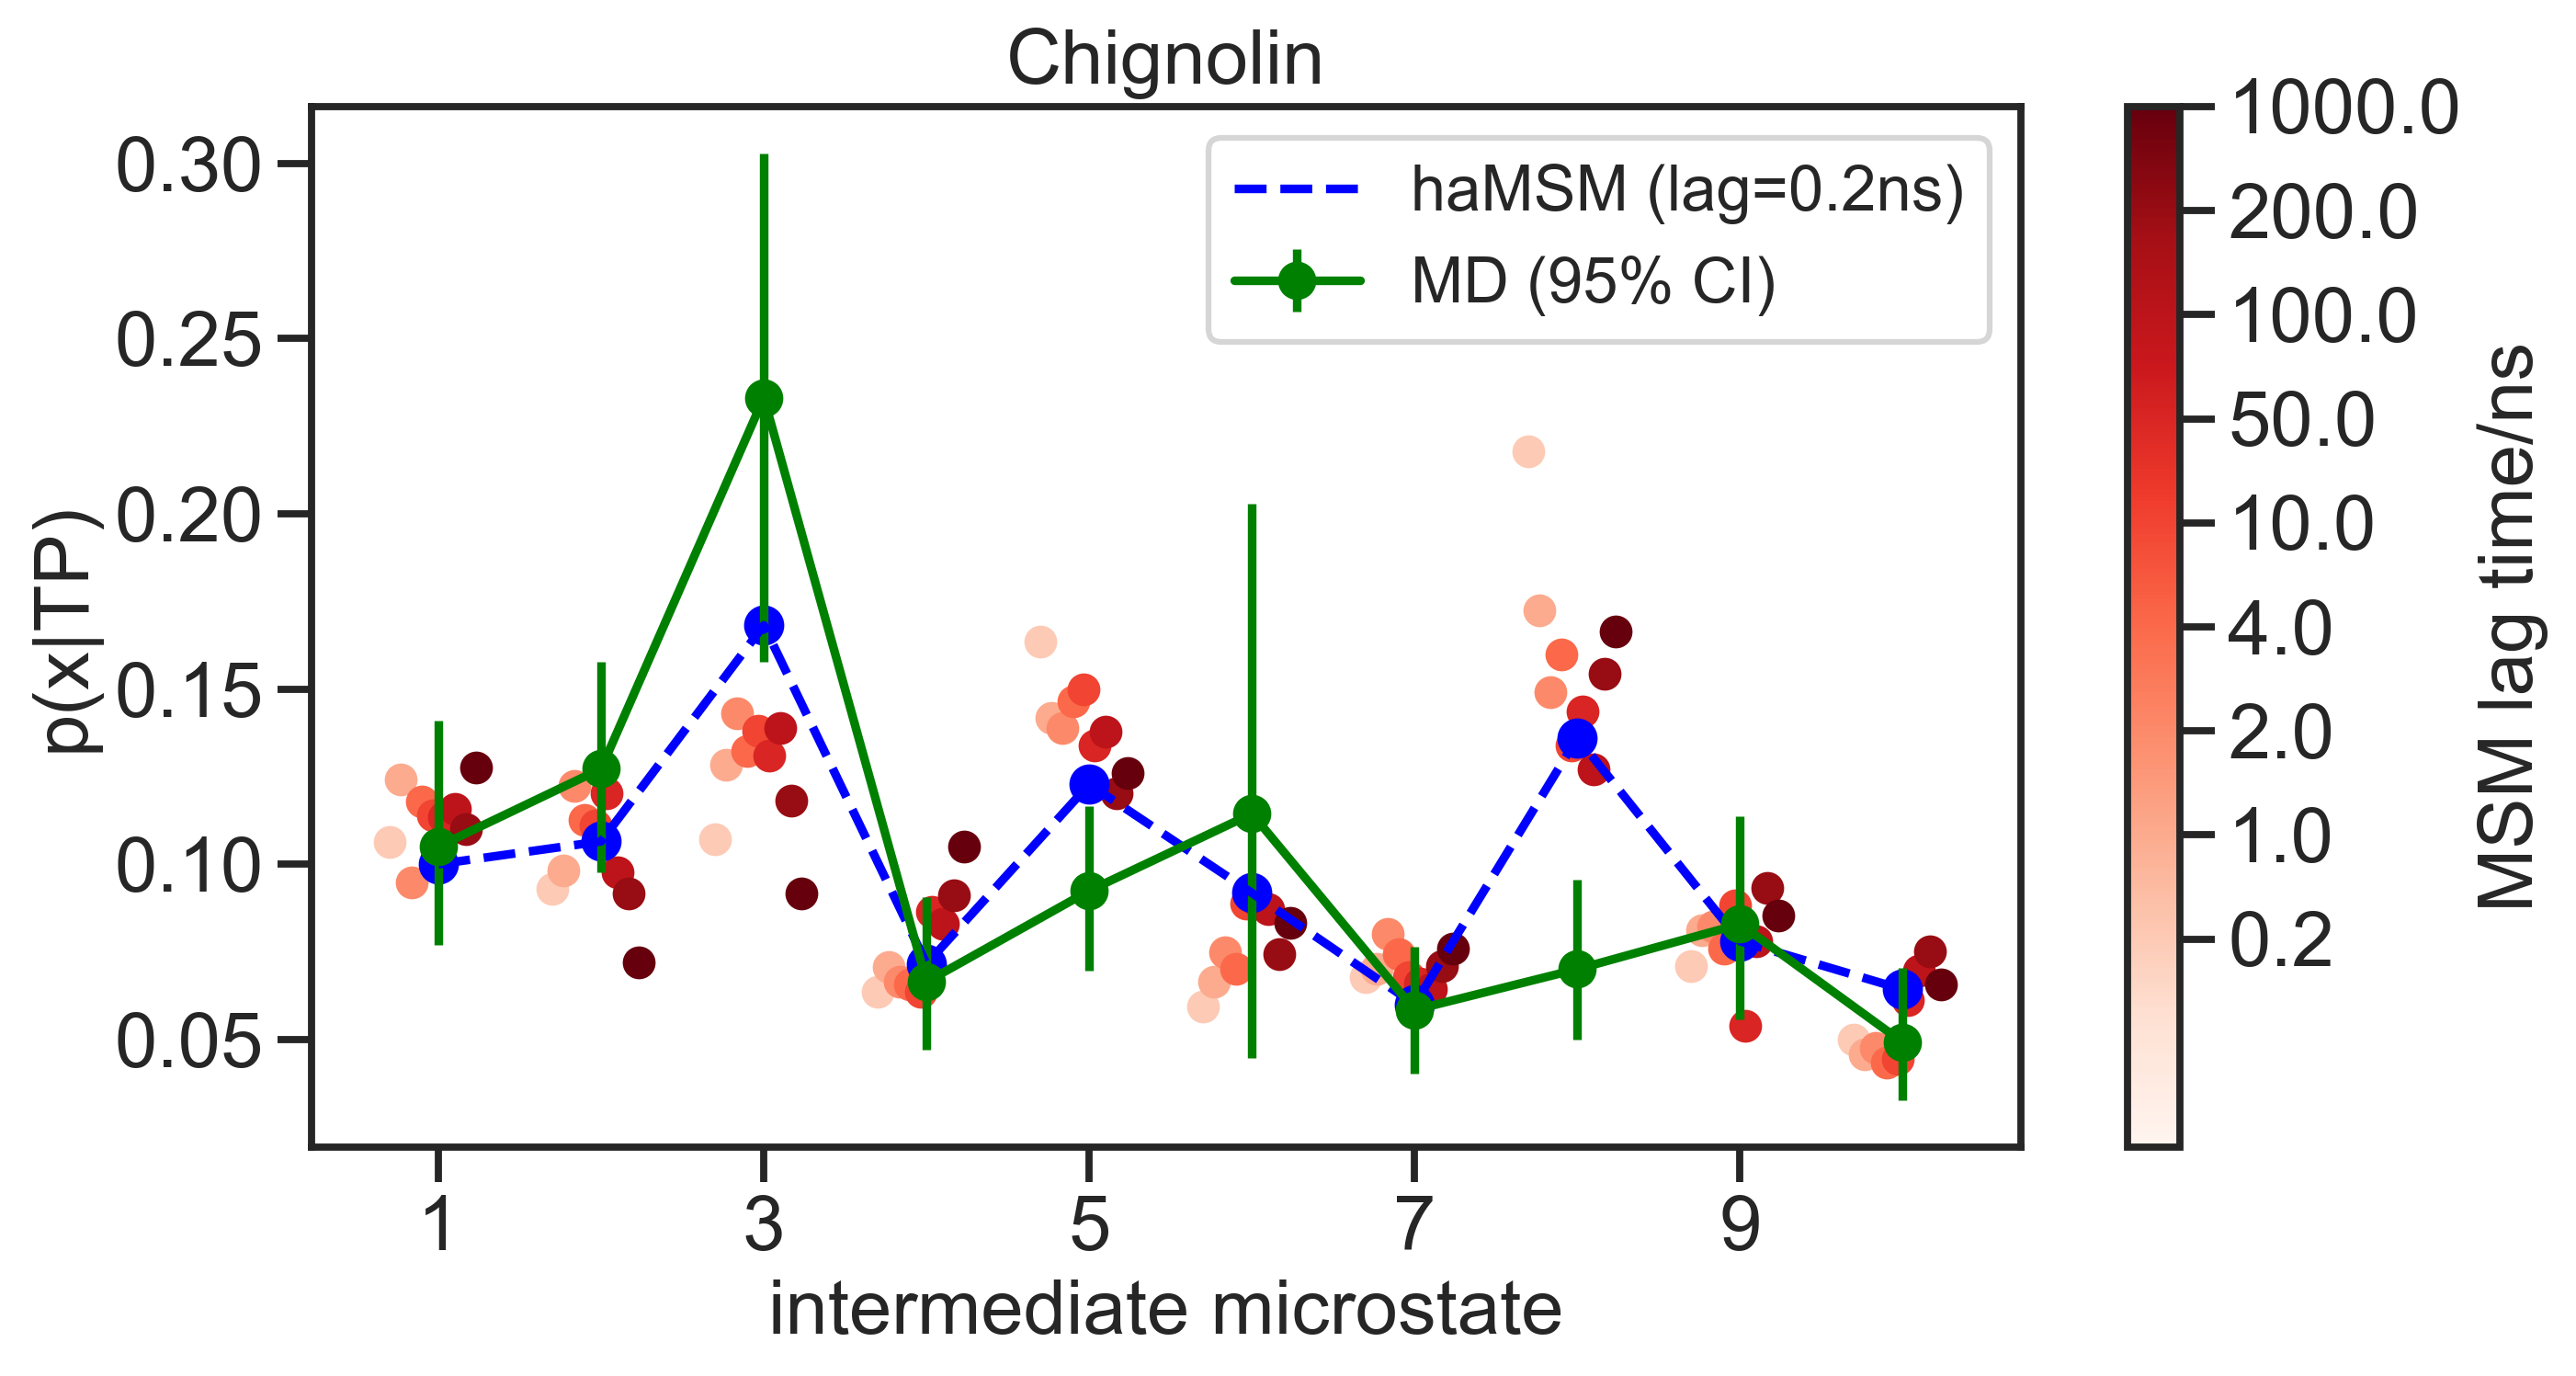

In [435]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], marker='o', color='green', label='MD (95% CI)')

plt.plot(np.arange(1,11), counts_nm, '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(1,11), counts_nm, color='blue')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

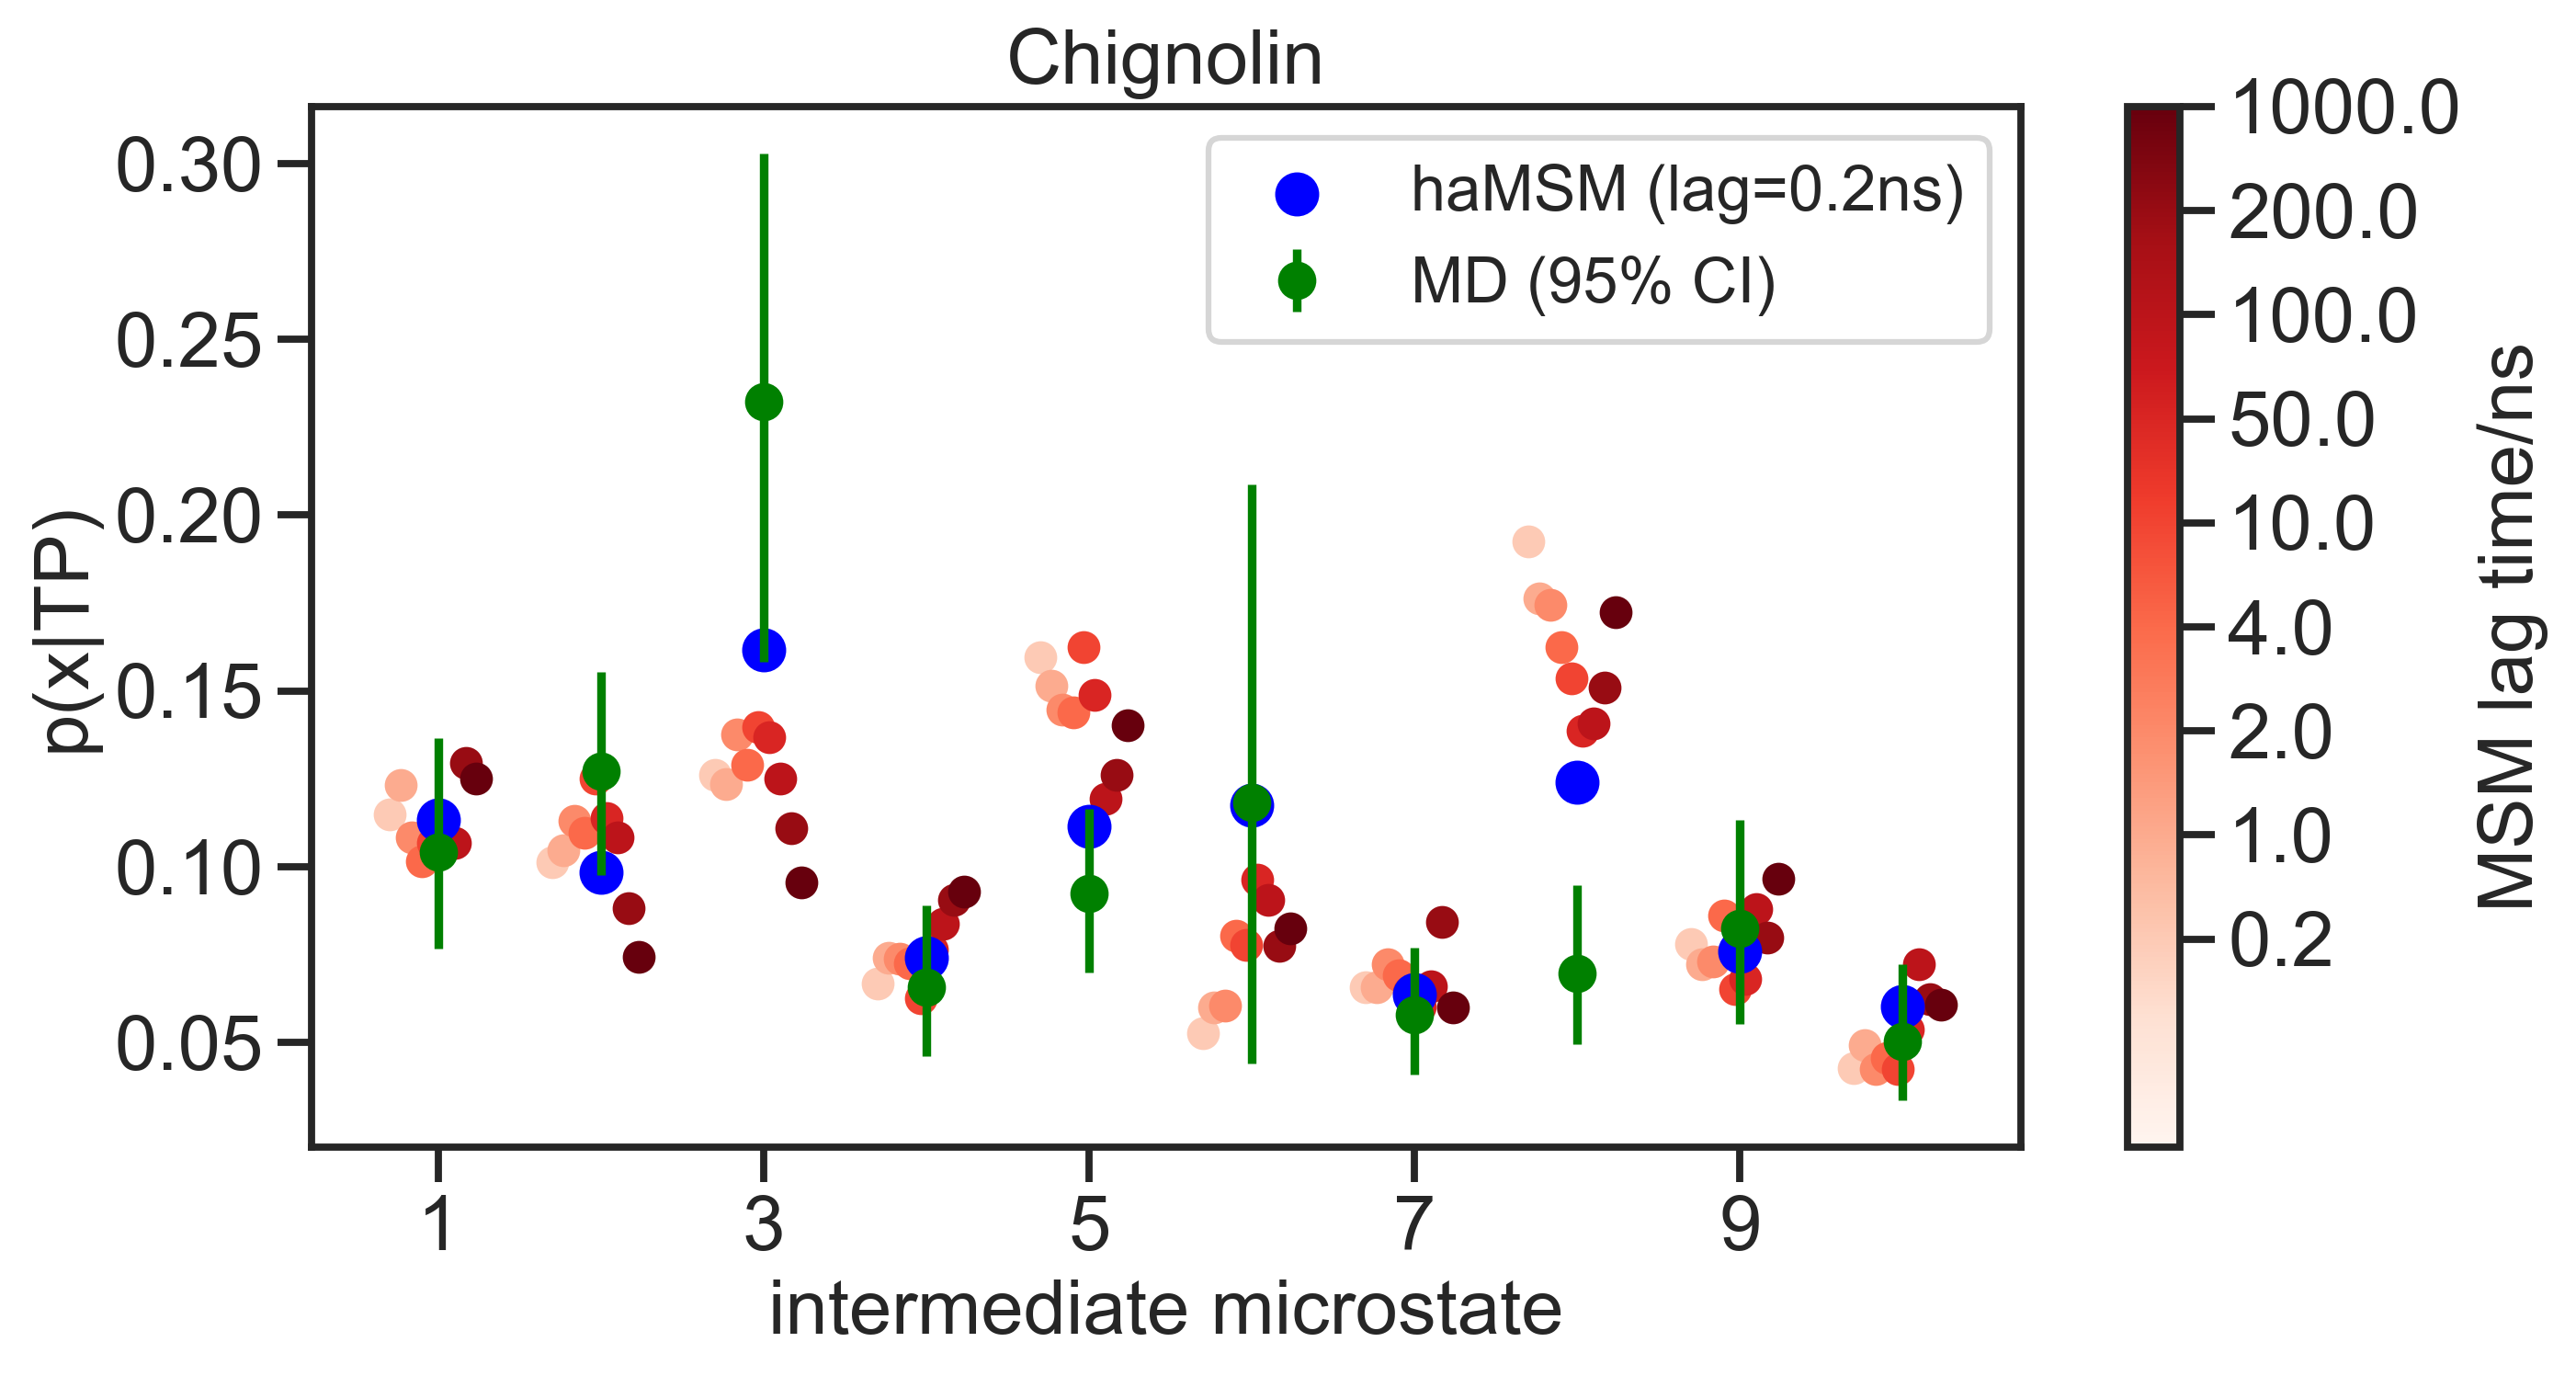

In [1035]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [738]:
# KL divergence

In [1036]:
[kl_divergence(np.mean(bootstrap_counts, axis=0), counts_msm[i]) + kl_divergence(counts_msm[i], np.mean(bootstrap_counts, axis=0)) for i in range(9)]

[0.2897066610553216,
 0.24788621413445064,
 0.21662385461083133,
 0.18348365101811925,
 0.17684071220861686,
 0.13590389144413256,
 0.14763682431165304,
 0.22077181365648346,
 0.2937796701718509]

In [1037]:
kl_divergence(np.mean(bootstrap_counts, axis=0), counts_nm) + kl_divergence(counts_nm, np.mean(bootstrap_counts, axis=0))

0.0726239893451737

In [1038]:
np.array([rmse(np.mean(bootstrap_counts, axis=0), counts_msm[i]) for i in range(9)])*100

array([6.01516203, 5.58814022, 5.16402197, 4.89553689, 4.7573027 ,
       4.25233815, 4.39544266, 5.26881926, 6.09489018])

In [1039]:
rmse(np.mean(bootstrap_counts, axis=0), counts_nm)

0.030753649731658016

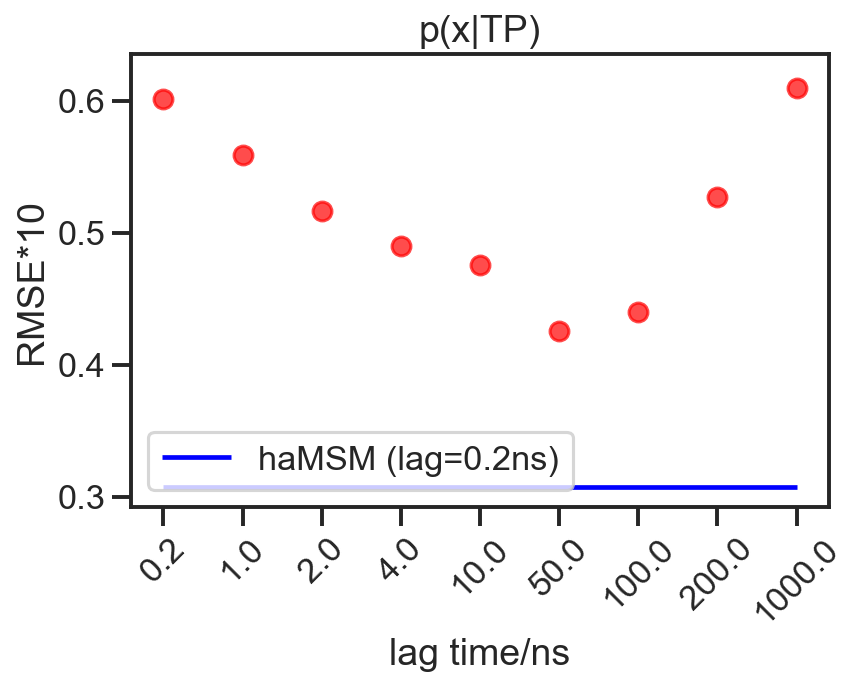

In [1040]:
plt.figure(dpi=150)
plt.scatter(range(9), np.array([rmse(np.mean(bootstrap_counts, axis=0), counts_msm[i]) for i in range(9)])*10, color='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('RMSE*10')
plt.title('p(x|TP)')
plt.hlines(rmse(np.mean(bootstrap_counts, axis=0), counts_nm)*10, 0, 8, color='blue', label='haMSM (lag=0.2ns)')
plt.legend()
plt.show()

In [929]:
# NOW INCLUDE DIRECT PATHS

In [956]:
int_trajs = get_trans_paths_md_wdirectpaths(dtrajs)

In [957]:
len(int_trajs)

400

In [959]:
bootstrap_counts = count_md_bootstrap_wdirectpaths(int_trajs, n_samples=1000)

In [968]:
int_trajs_msm = get_trans_paths_msm_wdirectpaths(msm, lags)

lag: 1
182
381
583
735
943
1122
1294
lag: 5
326
611
941
1201
1472
lag: 10
402
838
1243
1653
lag: 20
720
1356
1967
lag: 50
1074
2146
lag: 250
4184
8206
lag: 500
7363
14563
lag: 1000
12240
24599
lag: 5000
28458
56842


In [971]:
counts_msm = count_msm_wdirectpaths(int_trajs_msm, msm)

In [972]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [973]:
my_path_ensembleAB = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixAB(), nm_model.stateA, nm_model.stateB, n_paths=1000)
my_path_ensembleBA = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixBA(), nm_model.stateB, nm_model.stateA, n_paths=1000)

In [989]:
path_ensemble = my_path_ensembleAB.trajectories + my_path_ensembleBA.trajectories

int_trajs_nm = get_trans_paths_nm_wdirectpaths(path_ensemble, nm_model)

In [990]:
len(int_trajs_nm)

2000

In [991]:
counts_nm = count_nm_wdirectpaths(int_trajs_nm)

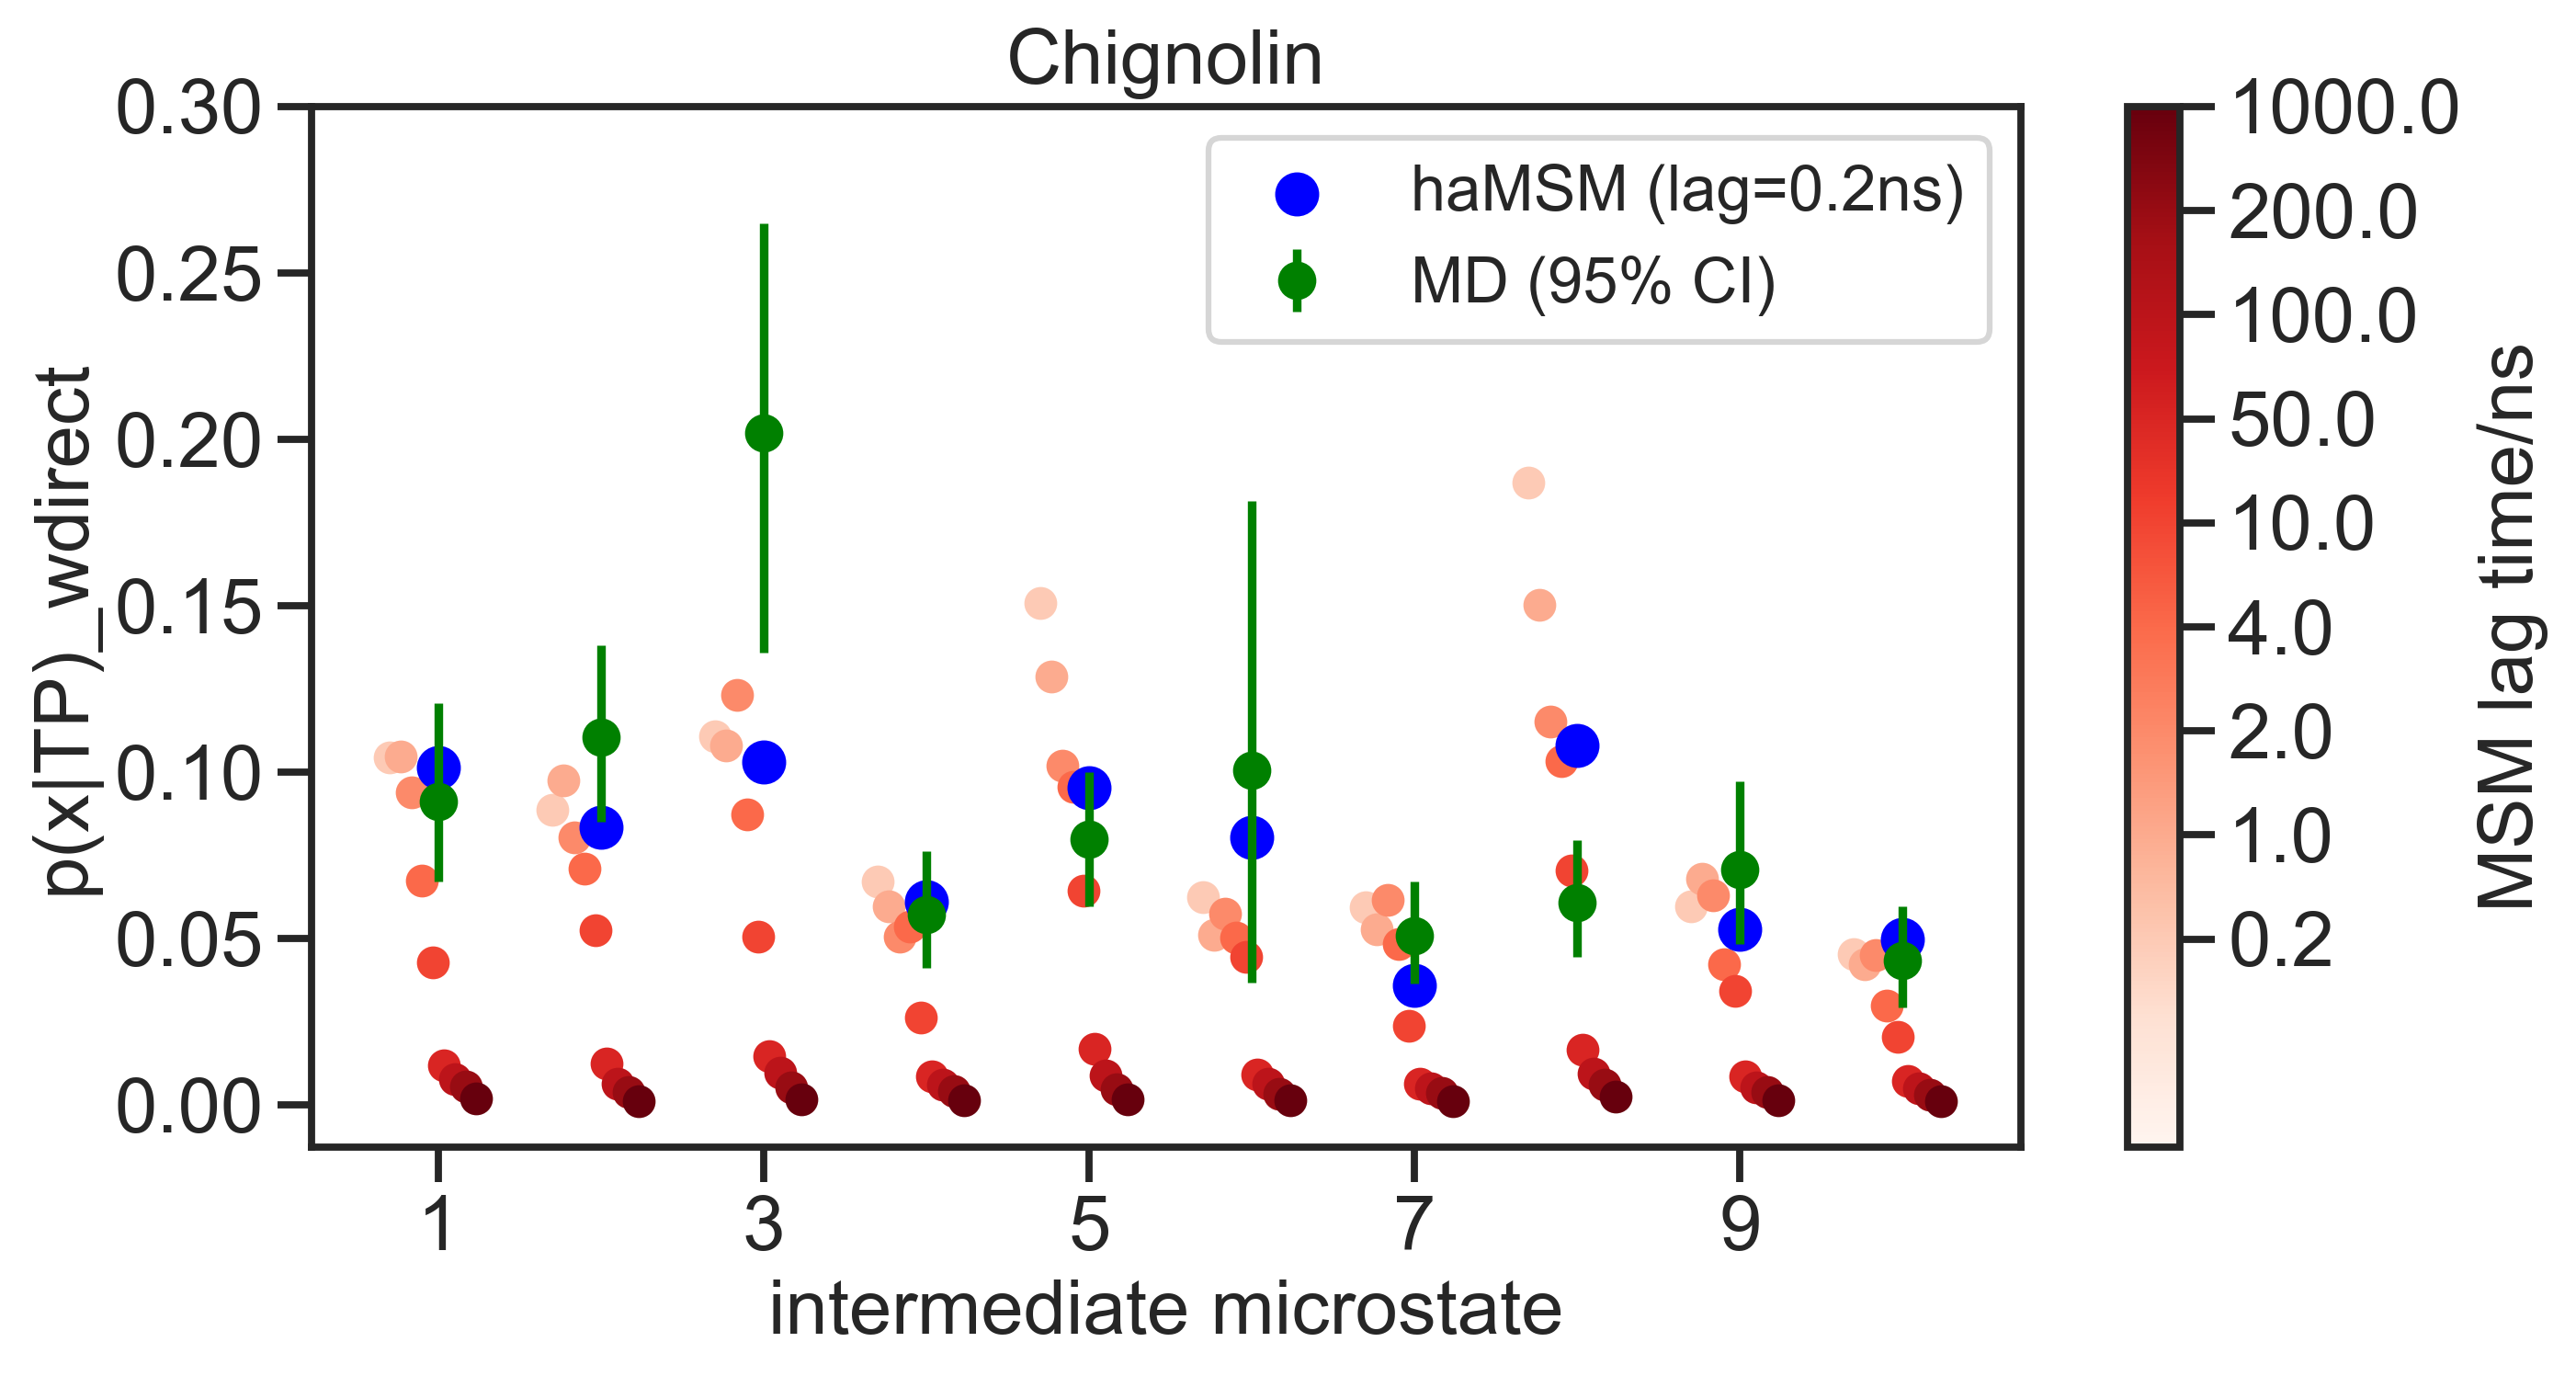

In [1000]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)_wdirect', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [994]:
[kl_divergence(np.mean(bootstrap_counts, axis=0), counts_msm[i]) + kl_divergence(counts_msm[i], np.mean(bootstrap_counts, axis=0)) for i in range(9)]

[0.27157531216962594,
 0.20058820314177617,
 0.11679386339306072,
 0.20100315656985104,
 0.4278139734572451,
 1.6215997968154225,
 2.073212054000311,
 2.52595940083732,
 3.5321192371593395]

In [995]:
kl_divergence(np.mean(bootstrap_counts, axis=0), counts_nm) + kl_divergence(counts_nm, np.mean(bootstrap_counts, axis=0))

0.12104699107329914

In [999]:
np.array([rmse(np.mean(bootstrap_counts, axis=0), counts_msm[i]) for i in range(9)])*100

array([5.62990901, 4.69510103, 3.55636027, 4.56792929, 5.97084727,
       8.64392591, 9.04330909, 9.29593668, 9.56549192])

In [1003]:
rmse(np.mean(bootstrap_counts, axis=0), counts_nm)*100

3.753145843296442

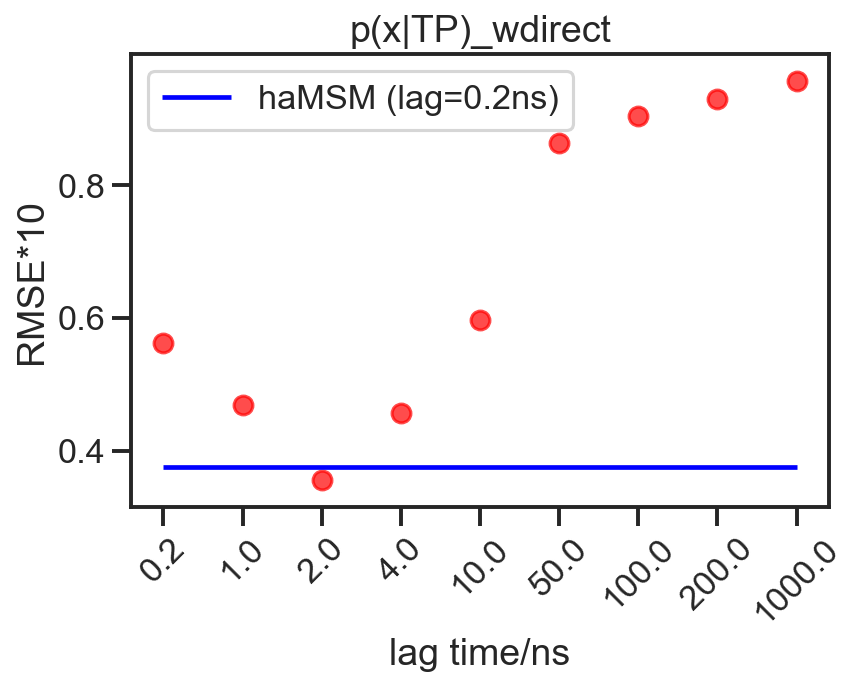

In [1007]:
plt.figure(dpi=150)
plt.scatter(range(9), np.array([rmse(np.mean(bootstrap_counts, axis=0), counts_msm[i]) for i in range(9)])*10, color='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('RMSE*10')
plt.title('p(x|TP)_wdirect')
plt.hlines(rmse(np.mean(bootstrap_counts, axis=0), counts_nm)*10, 0, 8, color='blue', label='haMSM (lag=0.2ns)')
plt.legend()
plt.show()

## Fundamental Sequences

In [883]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [884]:
ens = DiscretePathEnsemble.from_ensemble(nm_model, nm_model.stateA, nm_model.stateB)

In [885]:
len(ens.trajectories)

200

In [886]:
fs = ens._fundamental_sequences(nm_model.markov_tmatrix)

In [ ]:
mdFS, mdFSweights, _ = nm_model.empirical_weighted_FS()

In [888]:
mdFS_bootstrap = []
mdFSweights_bootstrap = []

for boostrap in range(1000):
    fs_ = np.random.choice(fs, len(fs))
    FS, FSweights = weighted_fundamental_sequences_md(fs_)
    mdFS_bootstrap.append(FS)
    mdFSweights_bootstrap.append(FSweights)

In [889]:
mdFSweights_bootstrap_padded = []

mdFS_indexdict = dict()

for i,seq in enumerate(mdFS):
    mdFS_indexdict[seq] = i

for i,seqs in enumerate(mdFS_bootstrap):
    mdFSweights_bootstrap_padded.append([0 for x in range(len(mdFS))])
    for j,seq in enumerate(seqs):
        mdFSweights_bootstrap_padded[-1][mdFS_indexdict[seq]] = mdFSweights_bootstrap[i][j]

In [890]:
#mdFS, mdFSweights, _ = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS(n_paths=2000)


nm_model.markovian = True


msmFS, msmFSweights, _ = nm_model.weighted_FS(n_paths=2000)

nm_model.lag_time = 5
msmFS_5, msmFSweights_5, _ = nm_model.weighted_FS(n_paths=2000)

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS(n_paths=2000)

nm_model.lag_time = 20
msmFS_20, msmFSweights_20, _ = nm_model.weighted_FS(n_paths=2000)

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS(n_paths=2000)

nm_model.lag_time = 250
msmFS_250, msmFSweights_250, _ = nm_model.weighted_FS(n_paths=20000)

nm_model.lag_time = 500
msmFS_500, msmFSweights_500, _ = nm_model.weighted_FS(n_paths=20000)

nm_model.lag_time = 1000
msmFS_1000, msmFSweights_1000, _ = nm_model.weighted_FS(n_paths=100000)

nm_model.lag_time = 5000
msmFS_5000, msmFSweights_5000, _ = nm_model.weighted_FS(n_paths=100000)


nm_model.lag_time = 1
nm_model.markovian = False

In [891]:
nmFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_5 = []
msmFSweights_temp_10 = []
msmFSweights_temp_20 = []
msmFSweights_temp_50 = []
msmFSweights_temp_250 = []
msmFSweights_temp_500 = []
msmFSweights_temp_1000 = []
msmFSweights_temp_5000 = []

for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
        
    # lag=5
    if element in msmFS_5:
        msmFSweights_temp_5.append(msmFSweights_5[msmFS_5.index(element)])
    else:
        msmFSweights_temp_5.append(0)   
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
        
    # lag=20
    if element in msmFS_20:
        msmFSweights_temp_20.append(msmFSweights_20[msmFS_20.index(element)])
    else:
        msmFSweights_temp_20.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)

    # lag=250
    if element in msmFS_250:
        msmFSweights_temp_250.append(msmFSweights_250[msmFS_250.index(element)])
    else:
        msmFSweights_temp_250.append(0)
        
    # lag=500
    if element in msmFS_500:
        msmFSweights_temp_500.append(msmFSweights_500[msmFS_500.index(element)])
    else:
        msmFSweights_temp_500.append(0)    
    
    # lag=1000
    if element in msmFS_1000:
        msmFSweights_temp_1000.append(msmFSweights_1000[msmFS_1000.index(element)])
    else:
        msmFSweights_temp_1000.append(0)
        
    # lag=5000
    if element in msmFS_5000:
        msmFSweights_temp_5000.append(msmFSweights_5000[msmFS_5000.index(element)])
    else:
        msmFSweights_temp_5000.append(0)
        
msmFSweights_temp_all = [msmFSweights_temp,msmFSweights_temp_5,msmFSweights_temp_10,msmFSweights_temp_20,msmFSweights_temp_50,msmFSweights_temp_250,msmFSweights_temp_500,msmFSweights_temp_1000,msmFSweights_temp_5000]        

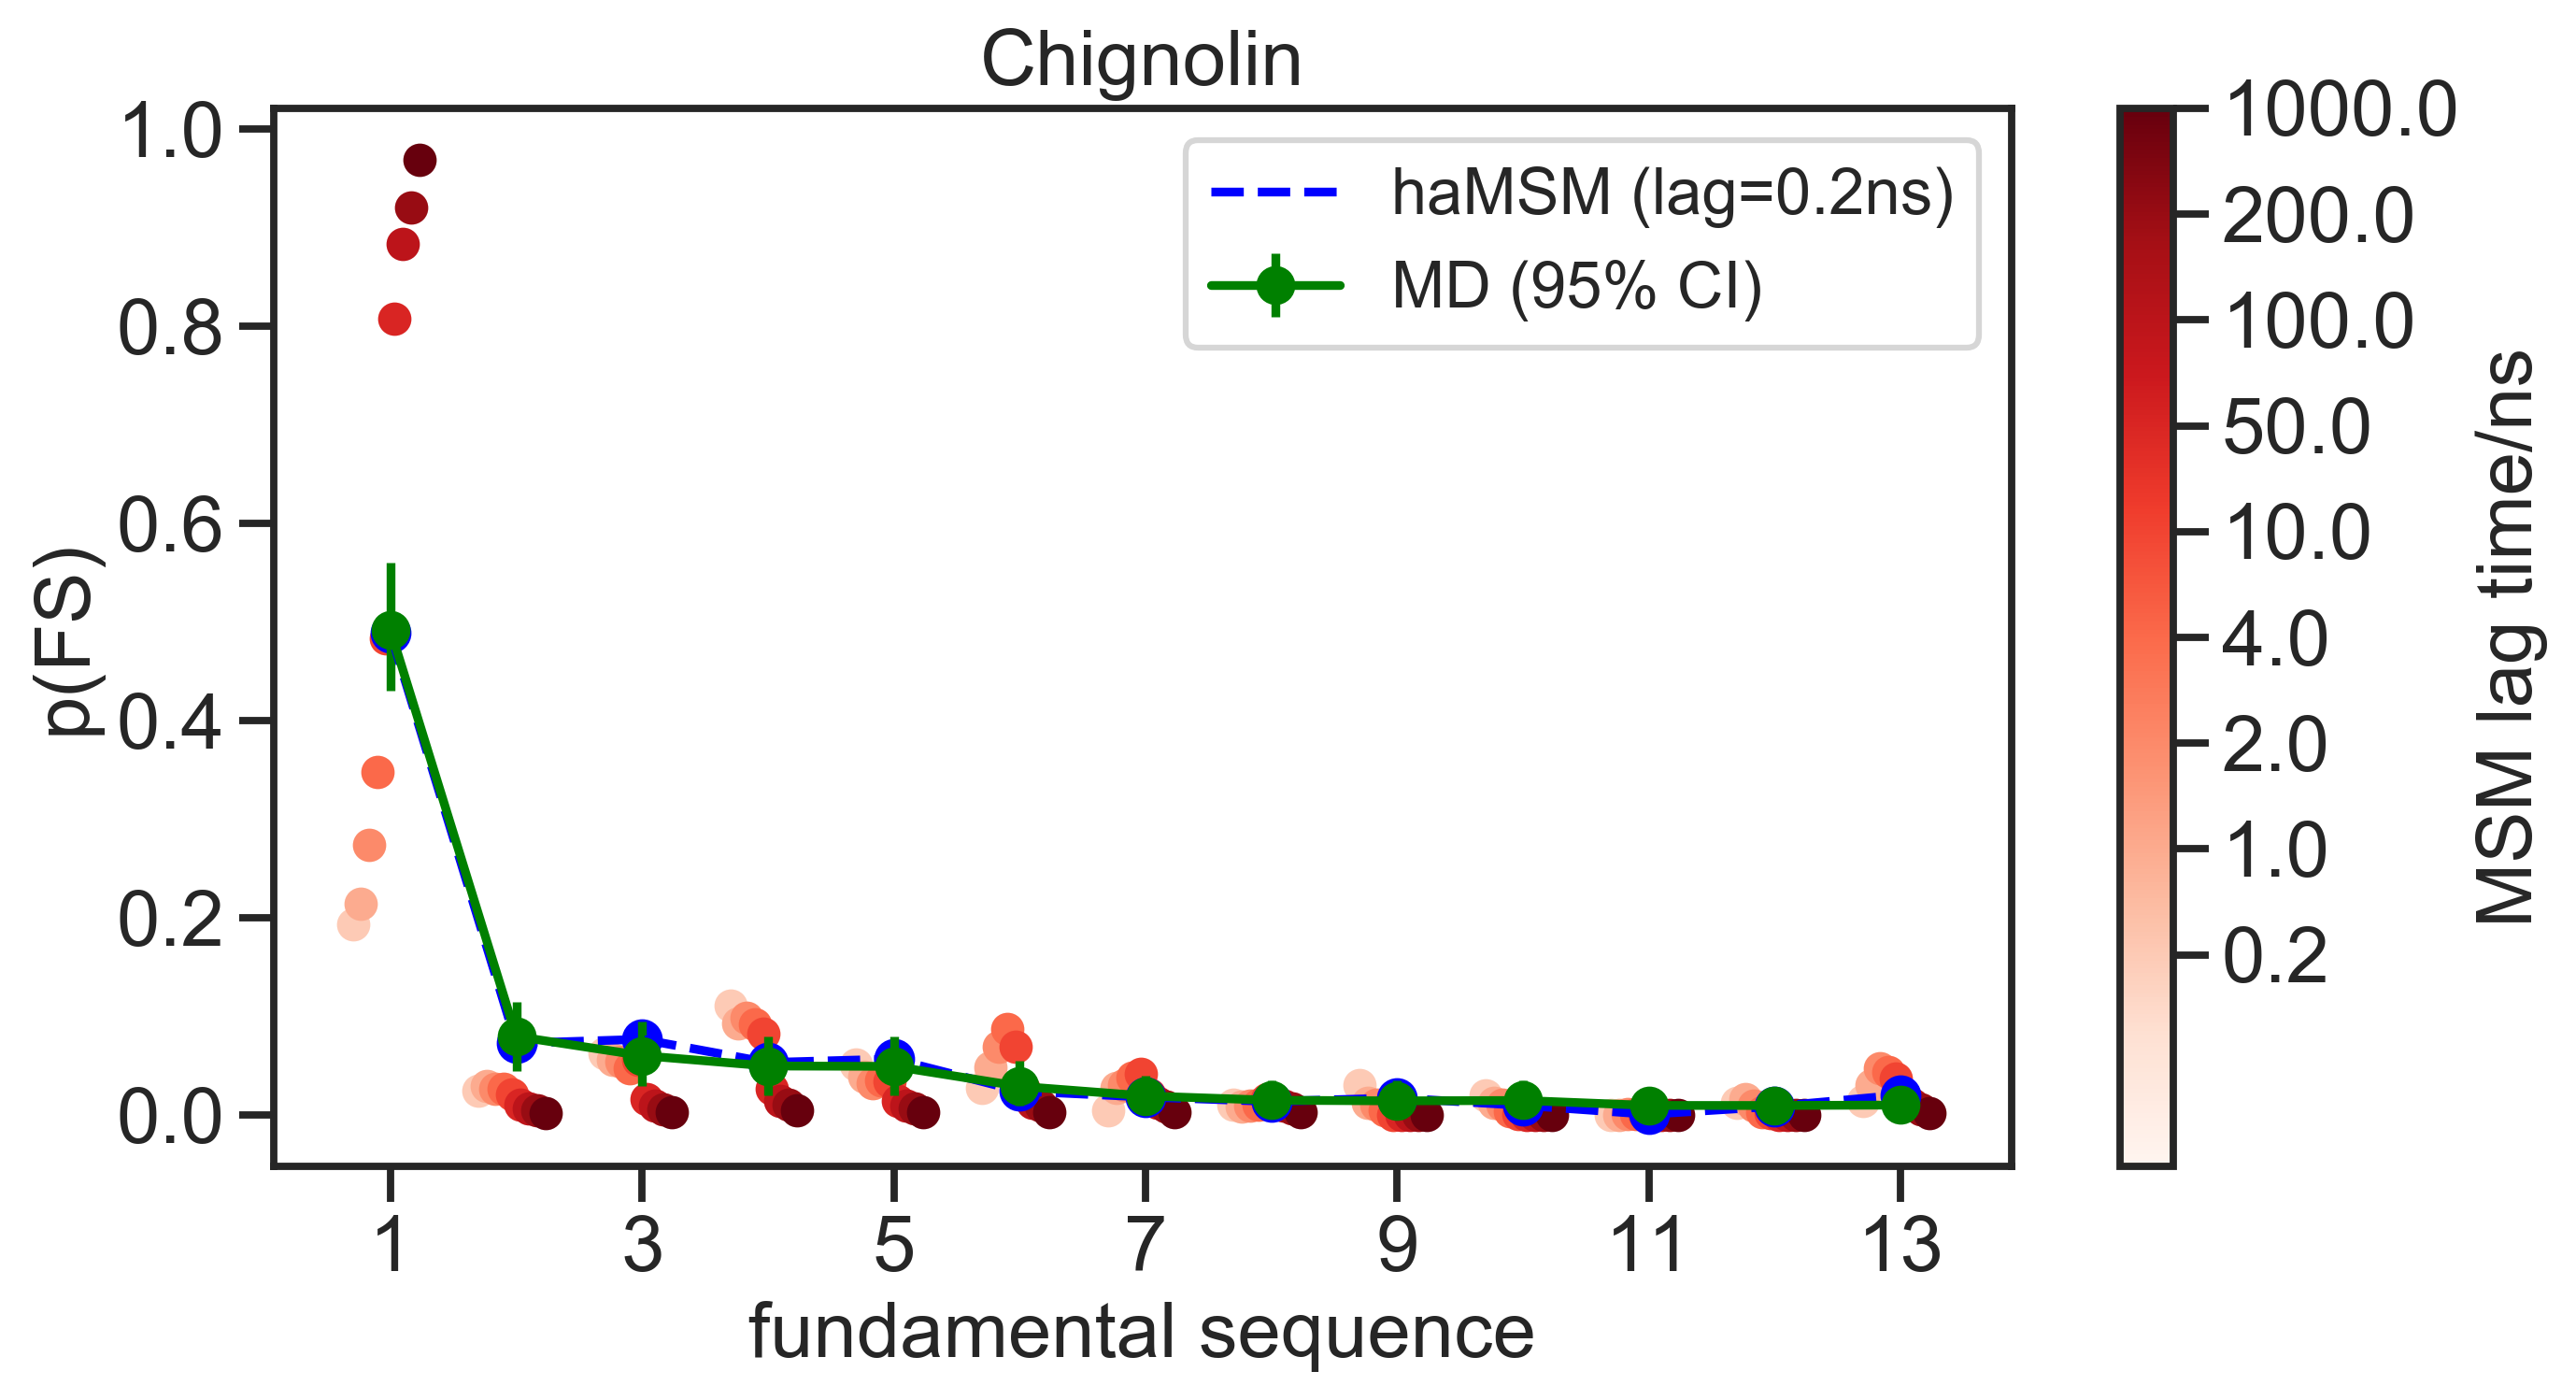

In [892]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[:13]], marker='o', color='green', label='MD (95% CI)')

plt.plot(np.arange(1,14), nmFSweights_temp[:13], '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(1,14), nmFSweights_temp[:13], color='blue')

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(1,14,2), np.arange(1,14,2), fontsize=20)
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

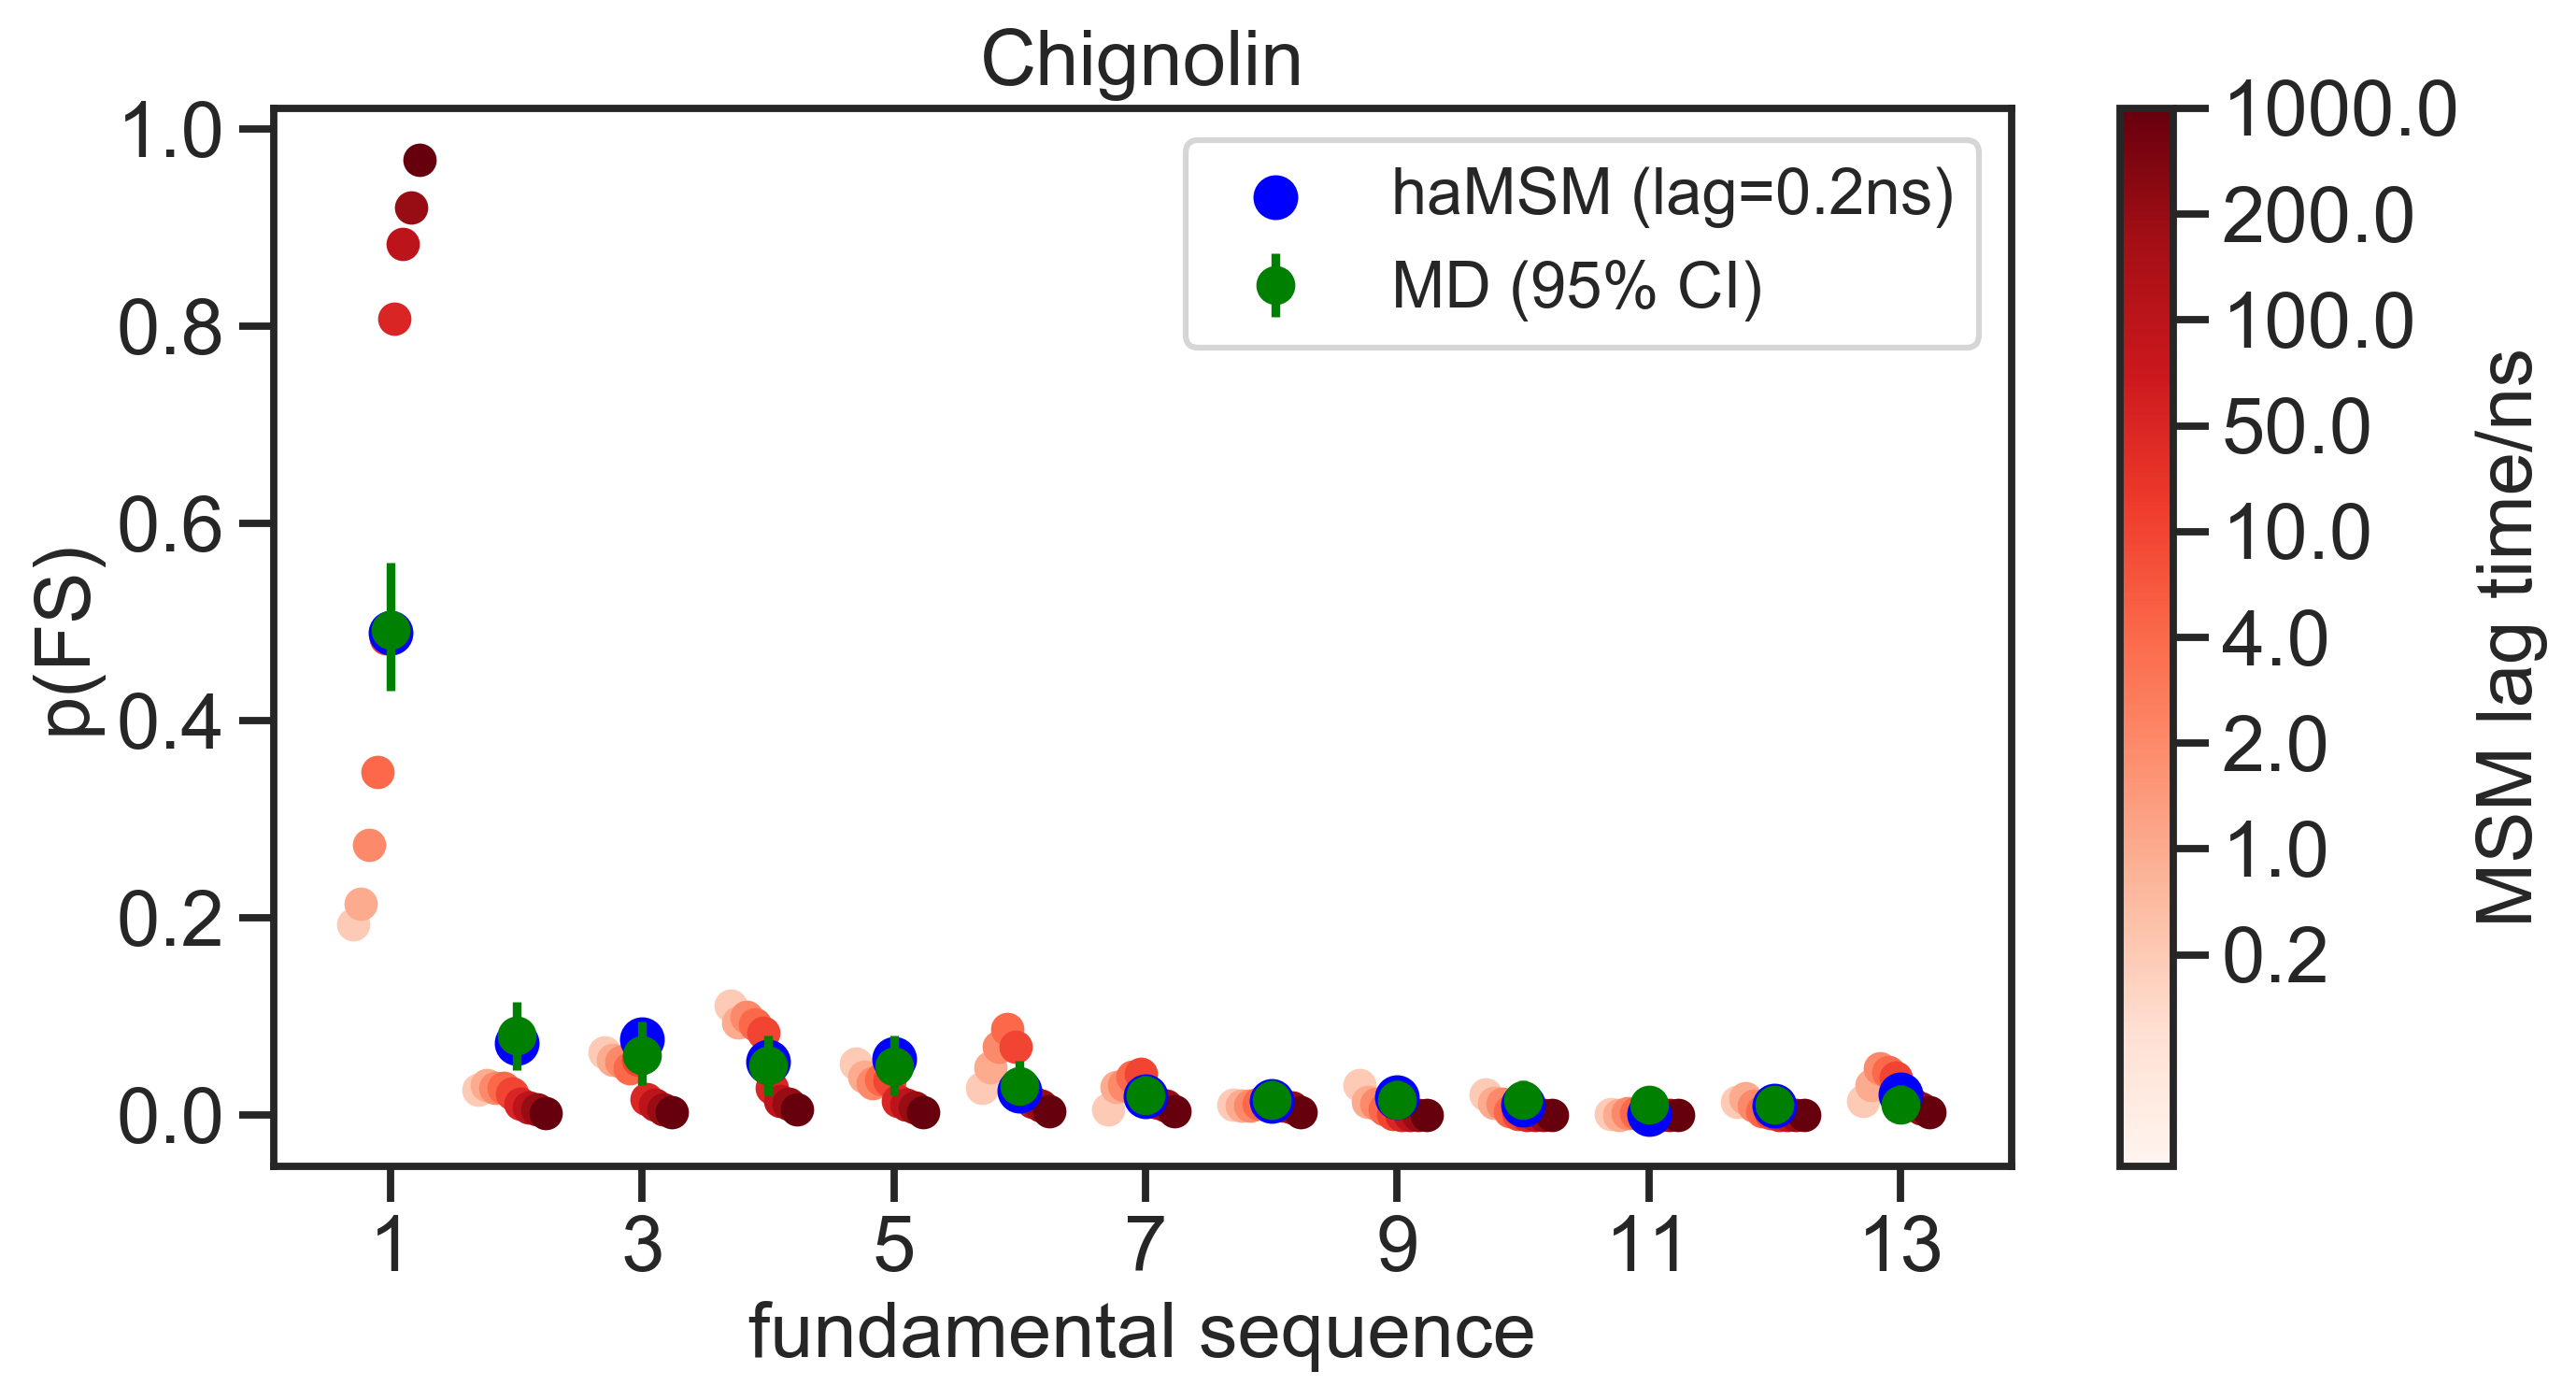

In [893]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[:13]], fmt='o', color='green', label='MD (95% CI)')

plt.scatter(np.arange(1,14), nmFSweights_temp[:13], color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(1,14,2), np.arange(1,14,2), fontsize=20)
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [894]:
np.array([rmse(np.mean(mdFSweights_bootstrap_padded, axis=0), msmFSweights_temp_all[i]) for i in range(9)])*100

array([4.99303804, 4.62438942, 3.81947095, 2.83416665, 1.51026848,
       5.30523308, 6.51364697, 7.10676035, 7.90401913])

In [1011]:
rmse(np.mean(mdFSweights_bootstrap_padded, axis=0), nmFSweights_temp)*100

0.5585873781015447

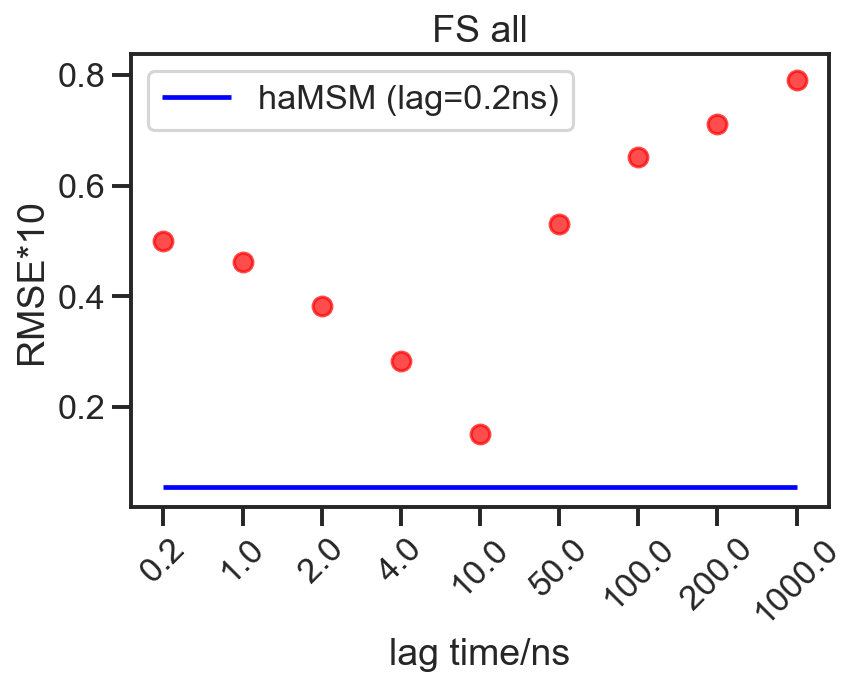

In [1017]:
plt.figure(dpi=150)
plt.scatter(range(9), np.array([rmse(np.mean(mdFSweights_bootstrap_padded, axis=0), msmFSweights_temp_all[i]) for i in range(9)])*10, color='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('RMSE*10')
plt.title('FS all')
plt.hlines(rmse(np.mean(mdFSweights_bootstrap_padded, axis=0), nmFSweights_temp)*10, 0, 8, color='blue', label='haMSM (lag=0.2ns)')
plt.legend()
plt.show()

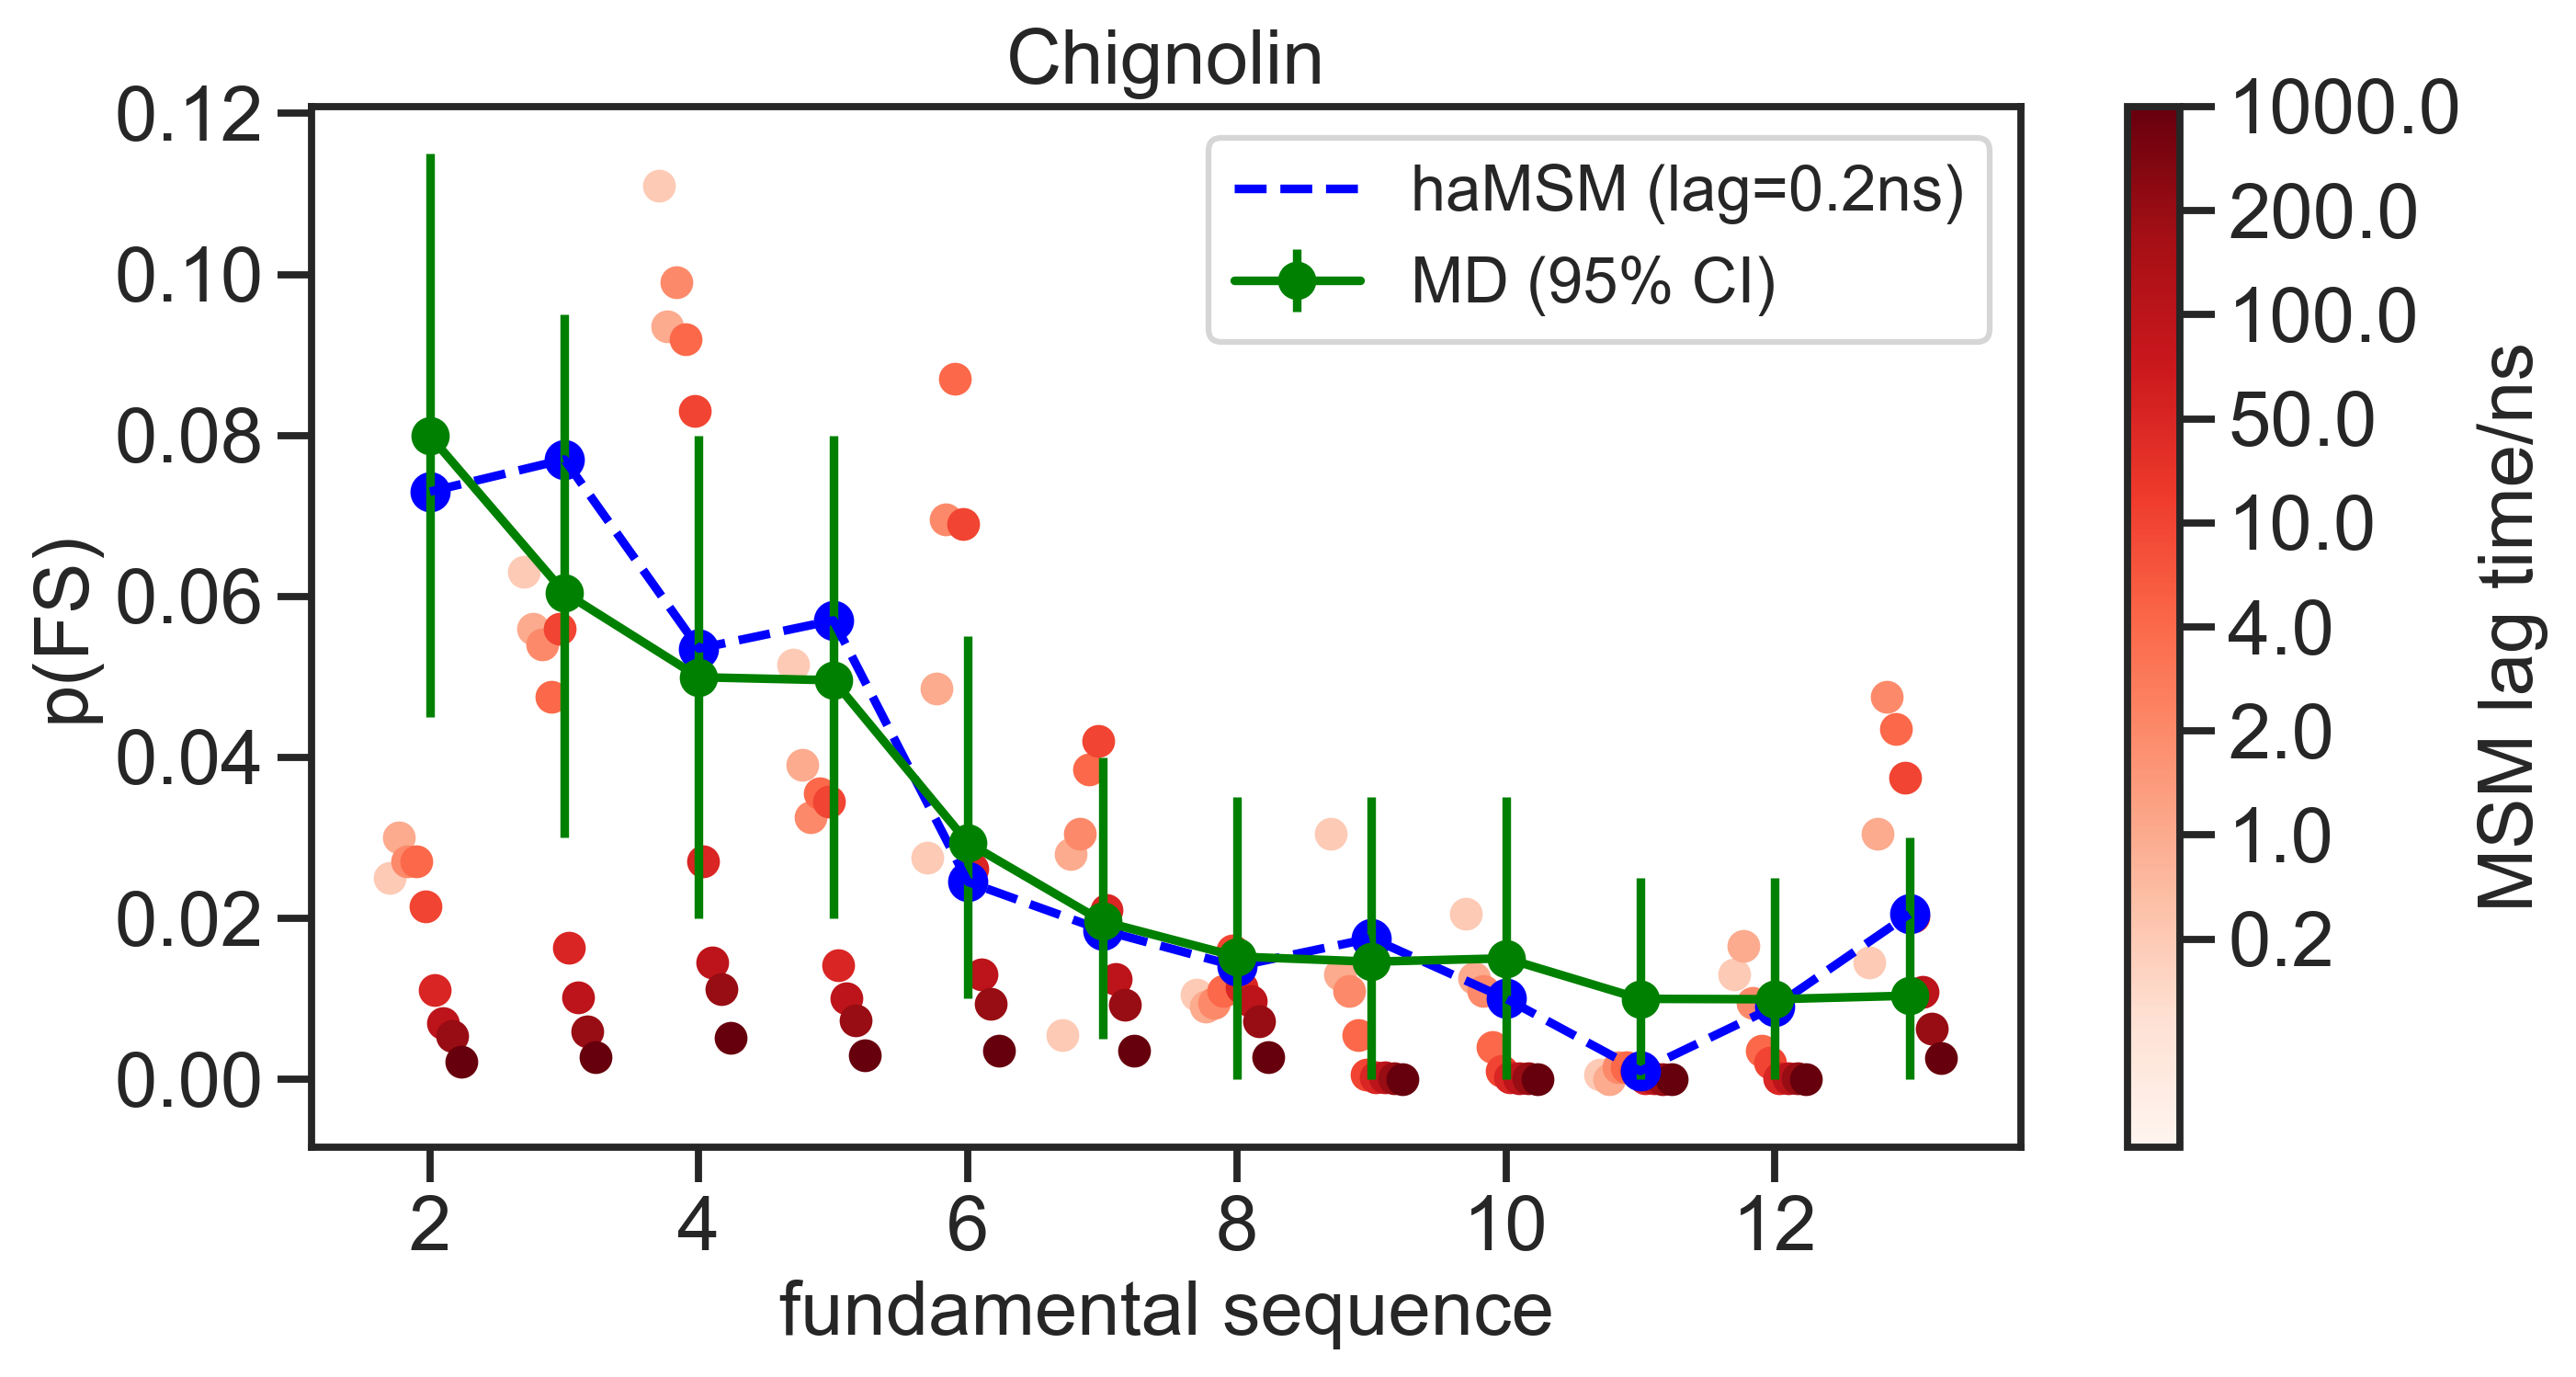

In [897]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(1.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][1:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(2,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[1:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[1:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[1:13]], marker='o', color='green', label='MD (95% CI)')

plt.plot(np.arange(2,14), nmFSweights_temp[1:13], '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(2,14), nmFSweights_temp[1:13], color='blue')

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(2,14,2), np.arange(2,14,2), fontsize=20)
plt.yticks(np.arange(0, 0.13, 0.02), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

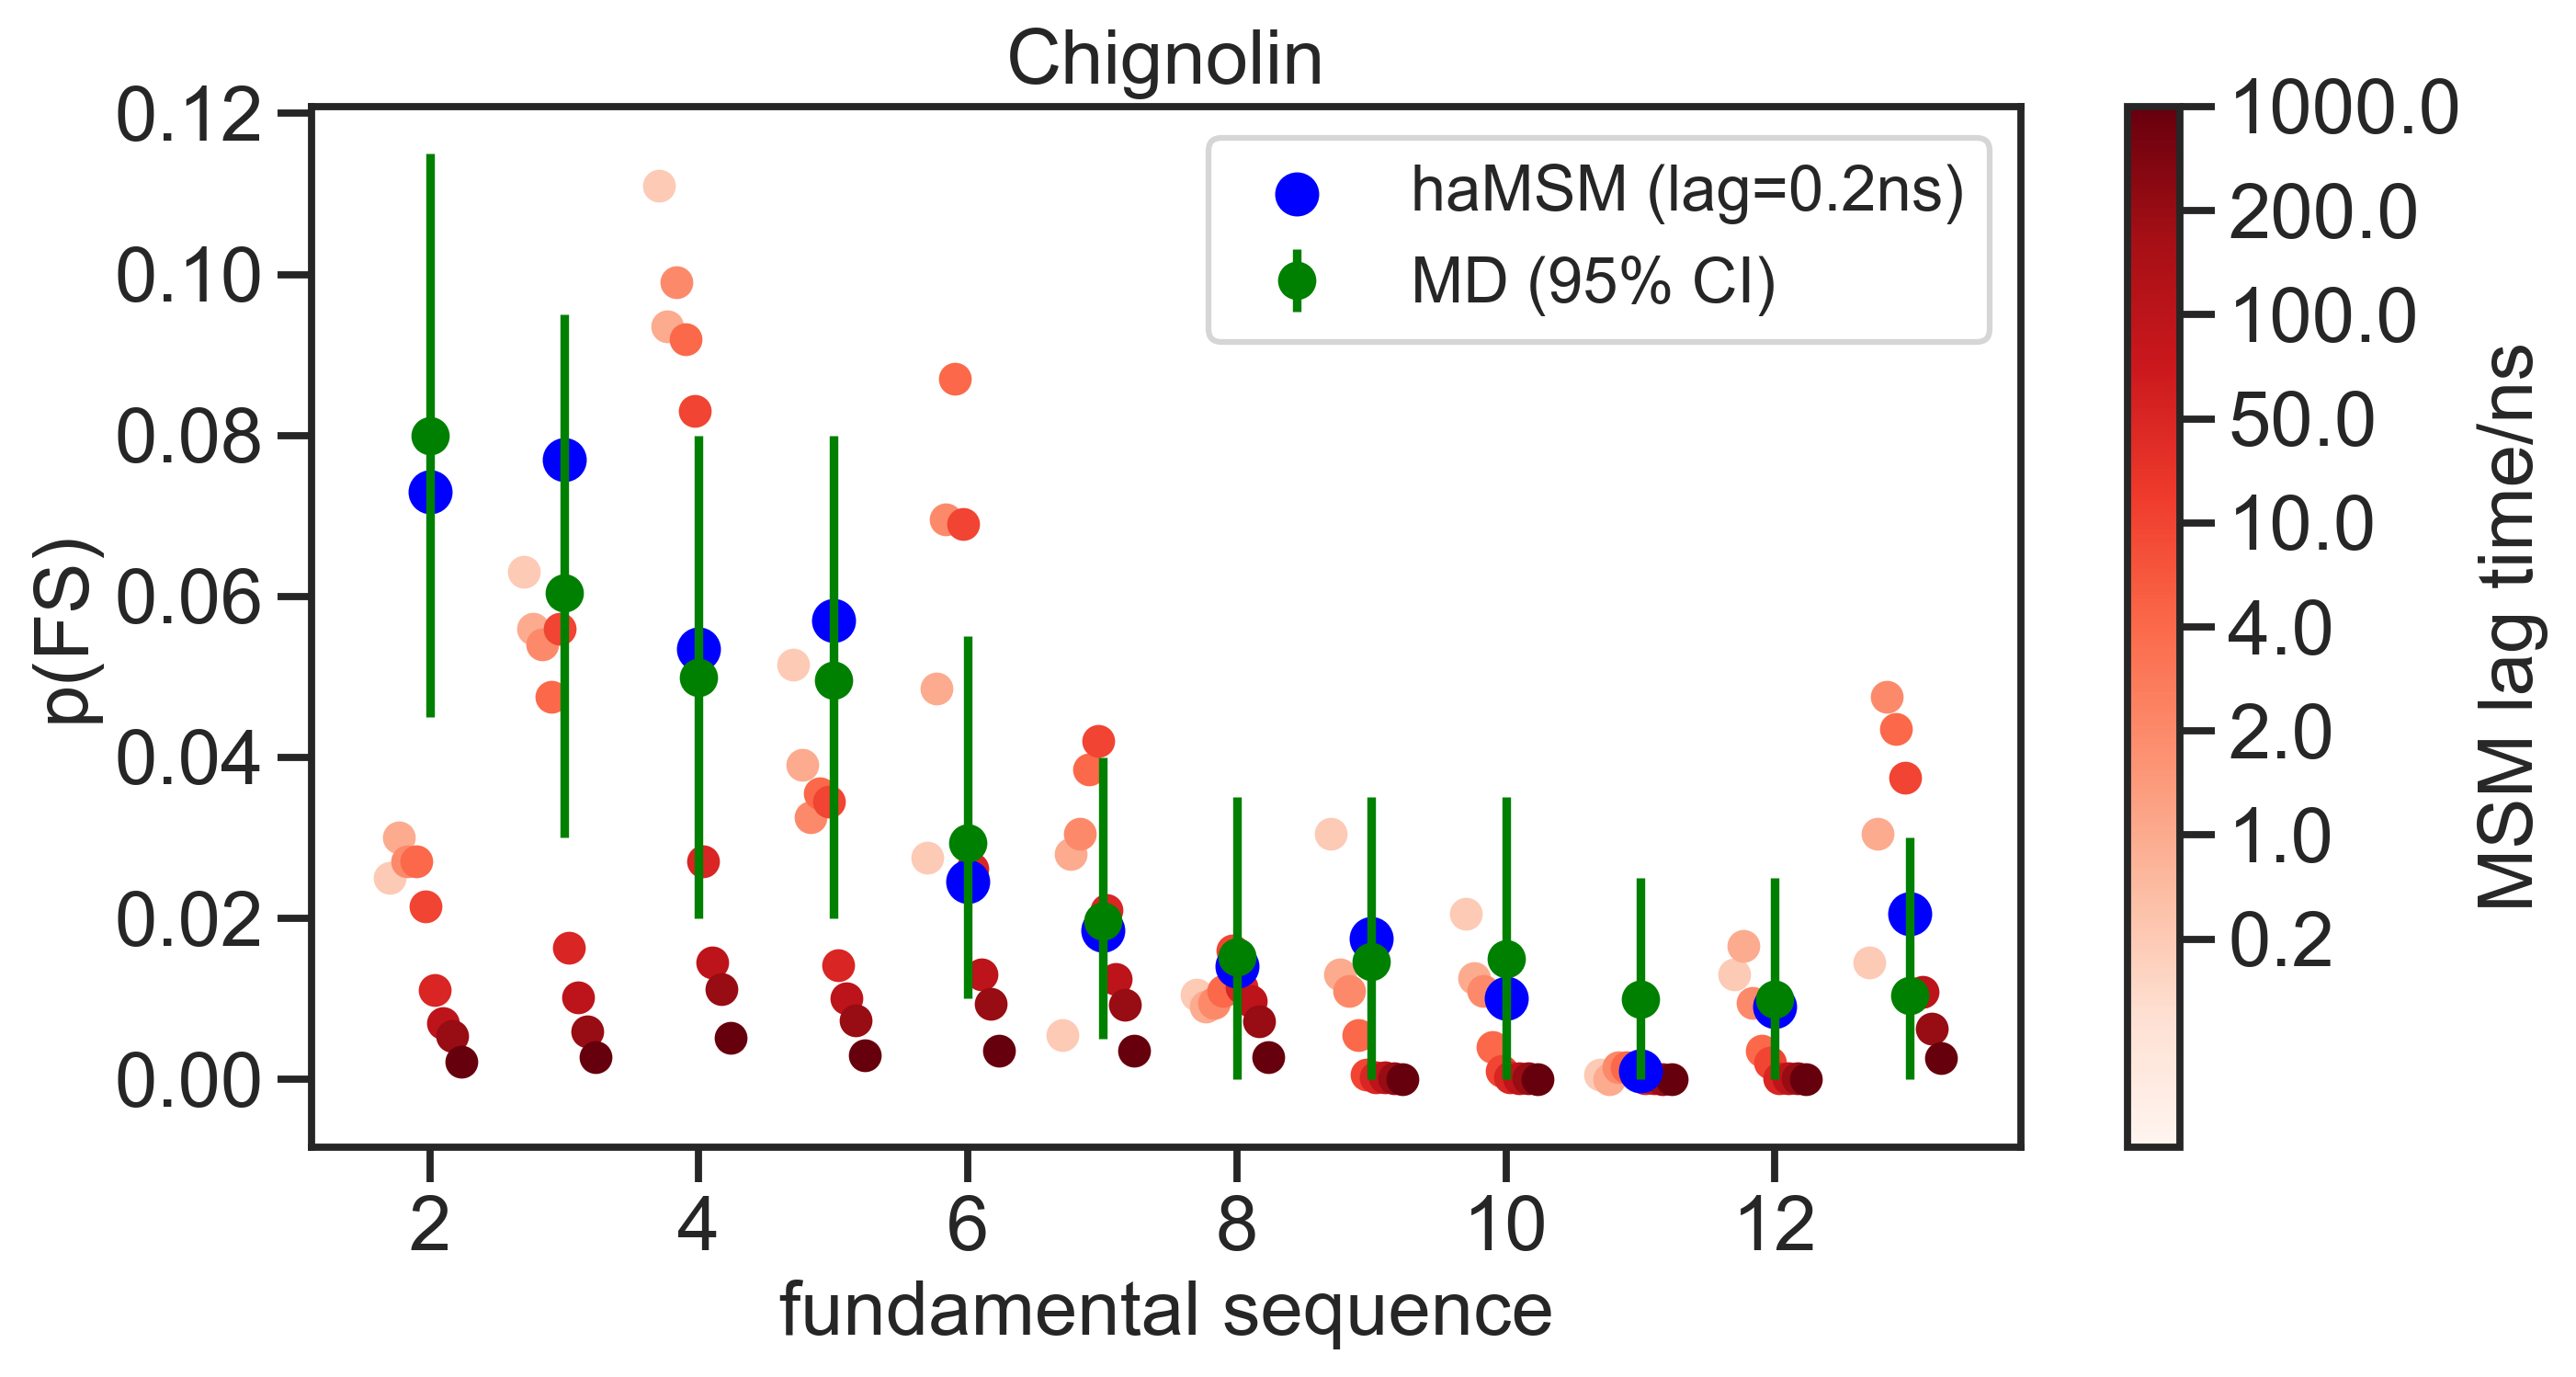

In [898]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(1.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][1:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(2,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[1:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[1:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[1:13]], fmt='o', color='green', label='MD (95% CI)')

plt.scatter(np.arange(2,14), nmFSweights_temp[1:13], color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(2,14,2), np.arange(2,14,2), fontsize=20)
plt.yticks(np.arange(0, 0.13, 0.02), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [899]:
np.array([rmse(np.mean(mdFSweights_bootstrap_padded, axis=0)[1:], msmFSweights_temp_all[i][1:]) for i in range(9)])*100

array([1.45995272, 1.29474499, 1.56868831, 1.66842113, 1.52371908,
       1.6275767 , 1.81401756, 1.91232503, 2.06466544])

In [1013]:
rmse(np.mean(mdFSweights_bootstrap_padded, axis=0)[1:], nmFSweights_temp[1:])*100

0.5637294575554729

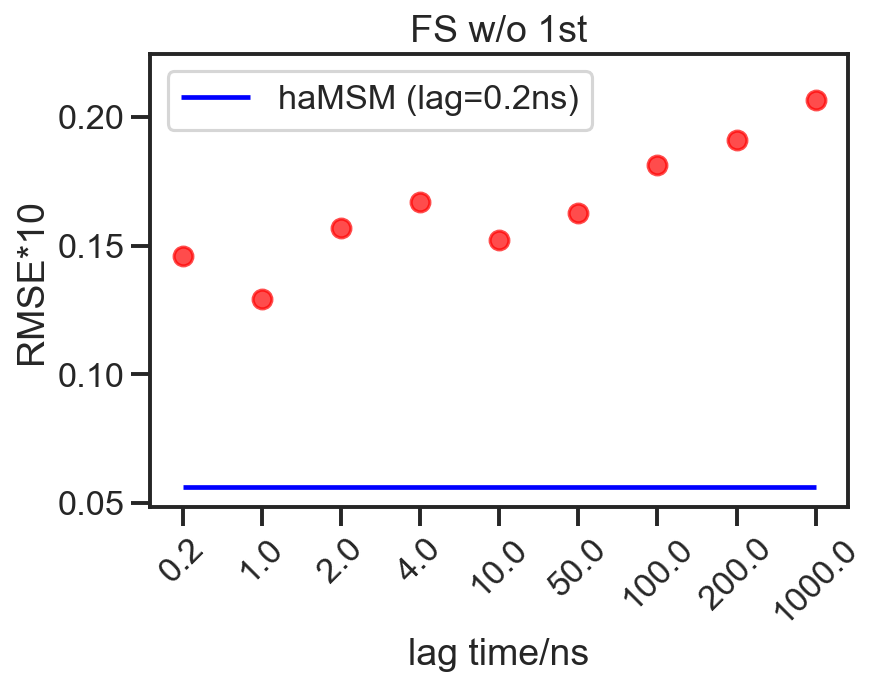

In [1018]:
plt.figure(dpi=150)
plt.scatter(range(9), np.array([rmse(np.mean(mdFSweights_bootstrap_padded, axis=0)[1:], msmFSweights_temp_all[i][1:]) for i in range(9)])*10, color='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('RMSE*10')
plt.title('FS w/o 1st')
plt.hlines(rmse(np.mean(mdFSweights_bootstrap_padded, axis=0)[1:], nmFSweights_temp[1:])*10, 0, 8, color='blue', label='haMSM (lag=0.2ns)')
plt.legend()
plt.show()

In [900]:
# re-normalize without the first (direct) pathway

In [901]:
mdFSweights_bootstrap_padded_renorm = [i[1:]/np.sum(i[1:]) for i in mdFSweights_bootstrap_padded]

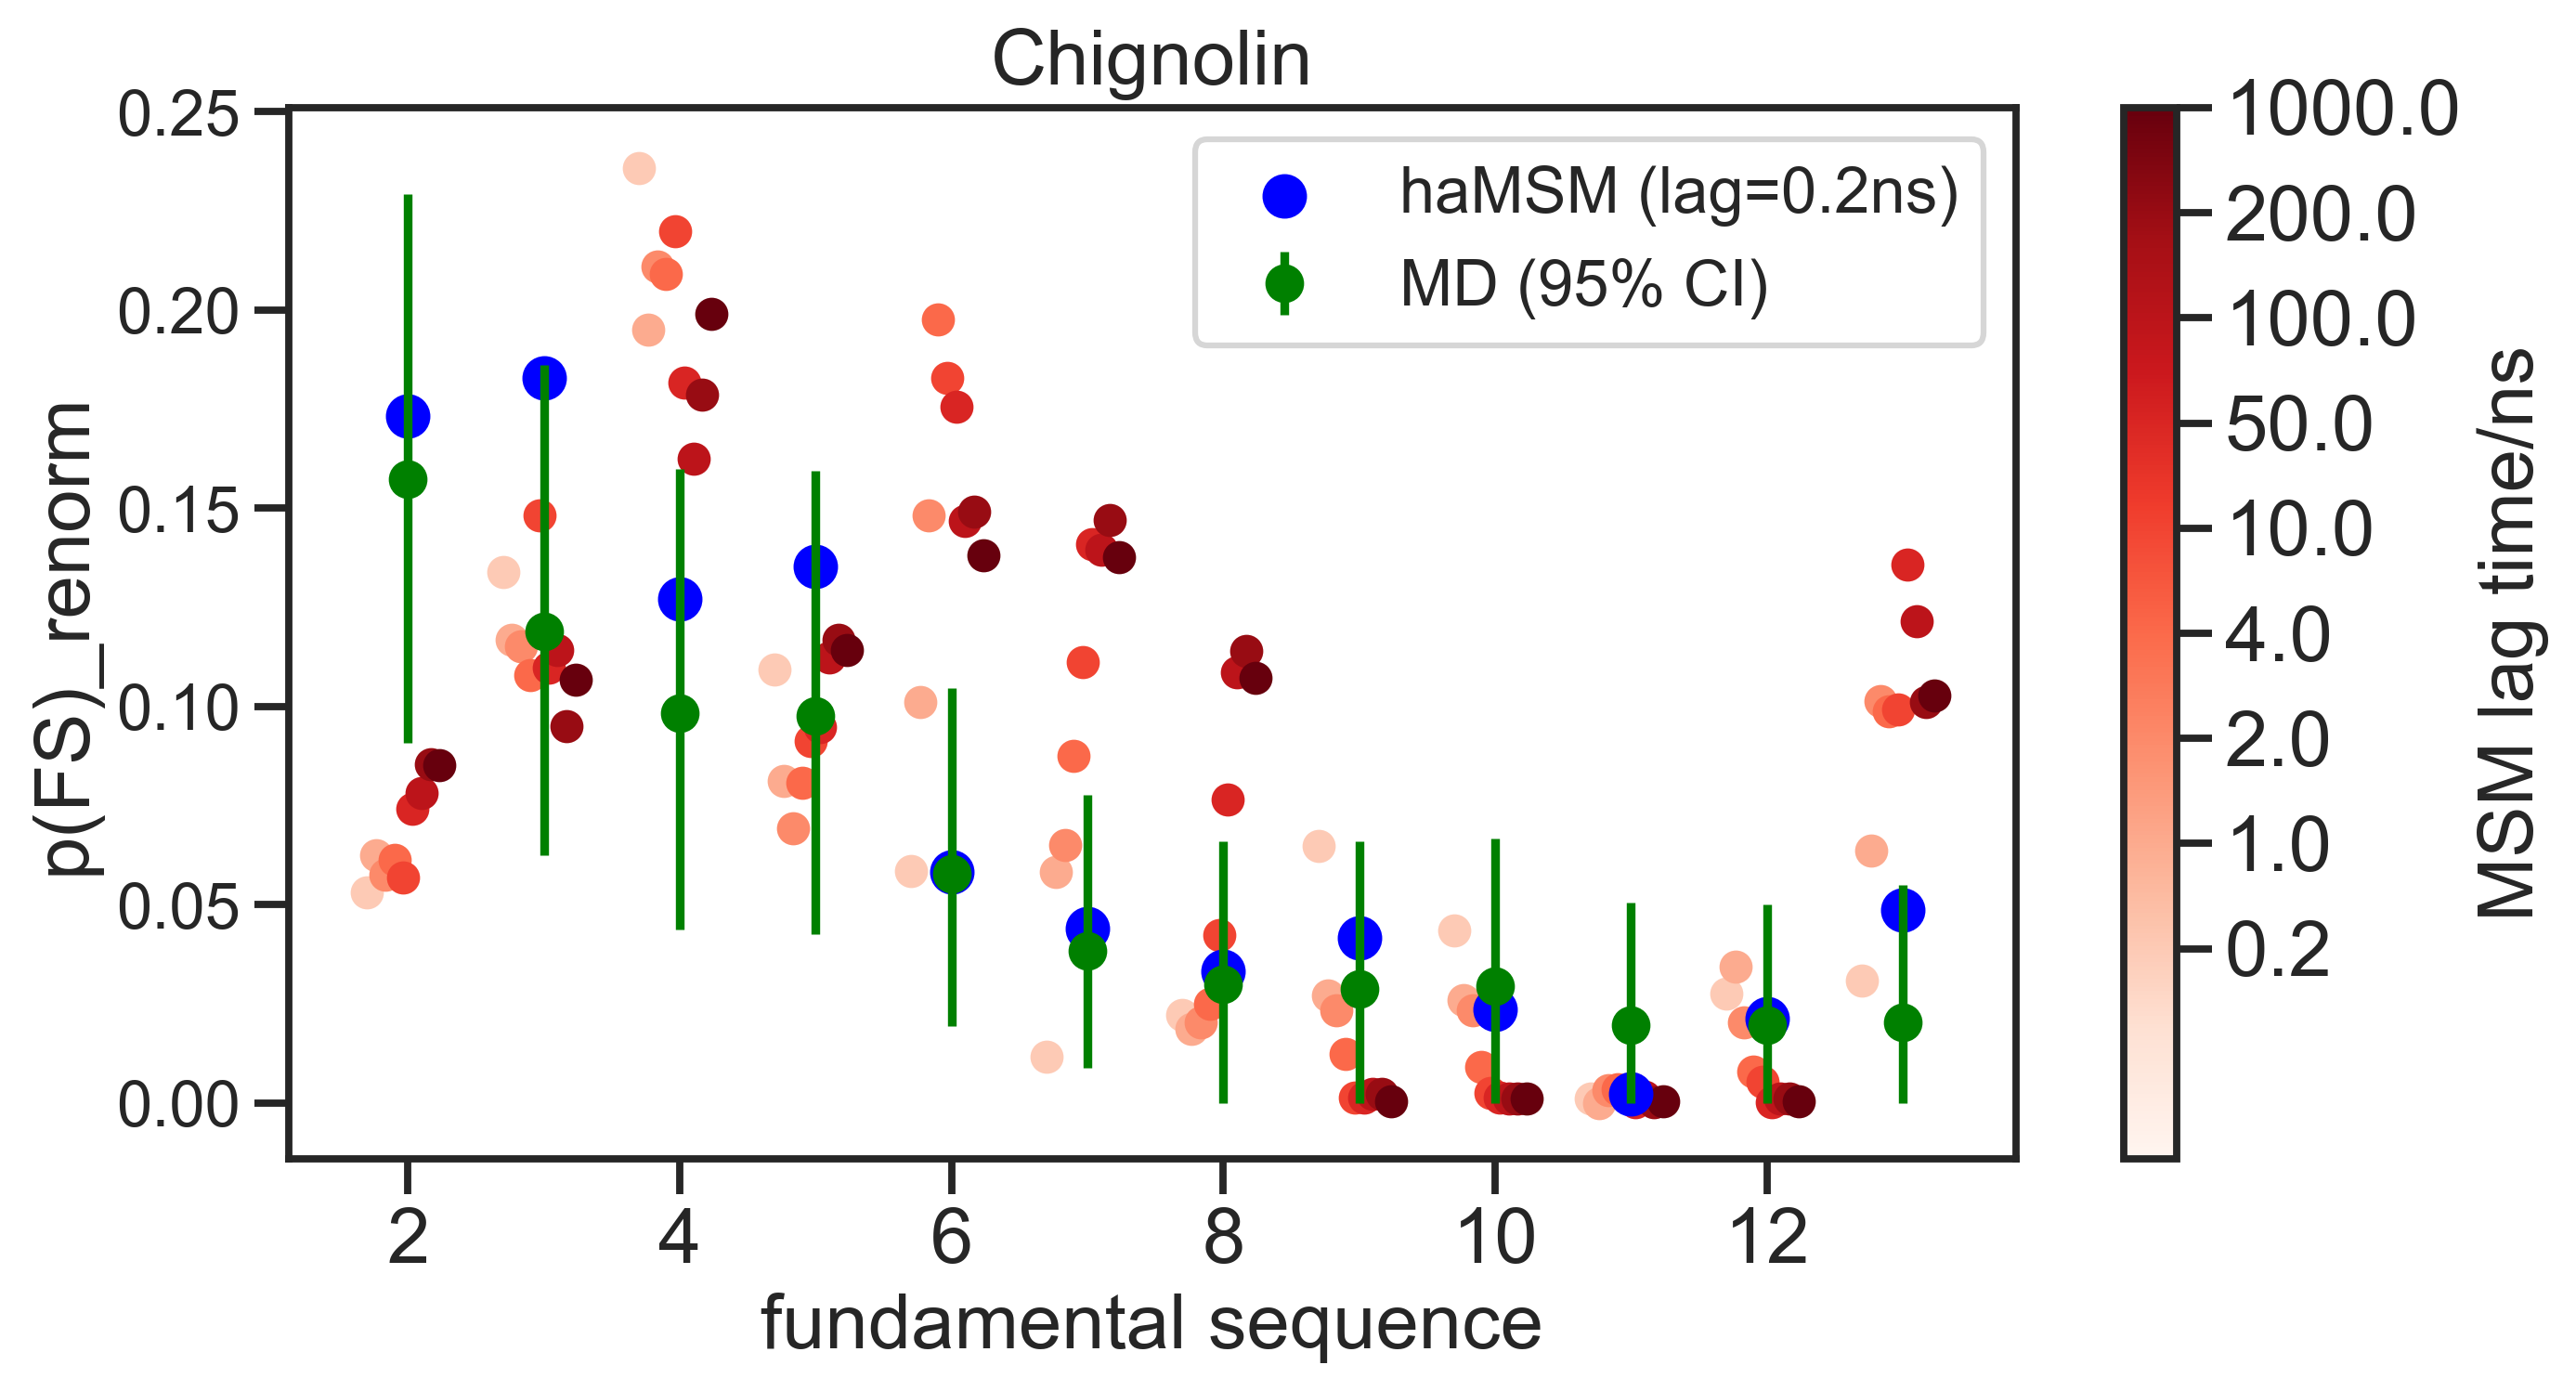

In [902]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(1.7+0.2*msm_index/3,13.5), (msmFSweights_temp_all[msm_index][1:]/np.sum(msmFSweights_temp_all[msm_index][1:]))[:12], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(2,14), np.mean(mdFSweights_bootstrap_padded_renorm, axis=0)[:12], yerr=[(np.mean(mdFSweights_bootstrap_padded_renorm, axis=0)-np.percentile(mdFSweights_bootstrap_padded_renorm, 2.5, axis=0))[:12], (np.percentile(mdFSweights_bootstrap_padded_renorm, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded_renorm, axis=0))[:12]], fmt='o', color='green', label='MD (95% CI)')

plt.scatter(np.arange(2,14), (nmFSweights_temp[1:]/np.sum(nmFSweights_temp[1:]))[:12], color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)_renorm', fontsize=20)
plt.xticks(np.arange(2,14,2), np.arange(2,14,2), fontsize=20)
#plt.yticks(np.arange(0, 0.13, 0.02), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [903]:
np.array([rmse(np.mean(mdFSweights_bootstrap_padded_renorm, axis=0), msmFSweights_temp_all[i][1:]/np.sum(msmFSweights_temp_all[i][1:])) for i in range(9)])*100

array([3.08165708, 2.66356195, 3.30997573, 3.74006172, 3.8953963 ,
       3.95104238, 3.64479279, 3.68652611, 3.64166269])

In [1015]:
rmse(np.mean(mdFSweights_bootstrap_padded_renorm, axis=0), nmFSweights_temp[1:]/np.sum(nmFSweights_temp[1:]))*100

1.6376301167982752

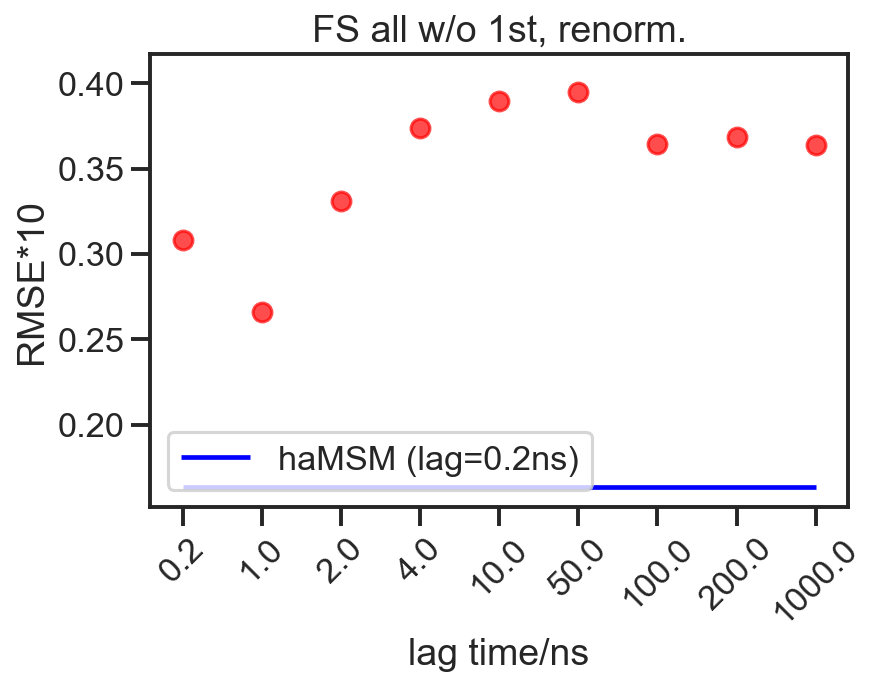

In [1020]:
plt.figure(dpi=150)
plt.scatter(range(9), np.array([rmse(np.mean(mdFSweights_bootstrap_padded_renorm, axis=0), msmFSweights_temp_all[i][1:]/np.sum(msmFSweights_temp_all[i][1:])) for i in range(9)])*10, color='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('RMSE*10')
plt.title('FS all w/o 1st, renorm.')
plt.hlines(rmse(np.mean(mdFSweights_bootstrap_padded_renorm, axis=0), nmFSweights_temp[1:]/np.sum(nmFSweights_temp[1:]))*10, 0, 8, color='blue', label='haMSM (lag=0.2ns)')
plt.legend()
plt.show()

In [294]:
### play around with p(x|TP)

In [301]:
[msm[i].pi[[x for x in range(100) if x not in stateA+stateB]] for i in range(9)]

[array([0.00256378, 0.00185134, 0.00250959, 0.00210371, 0.00319774,
        0.00165128, 0.0016793 , 0.00488077, 0.0021038 , 0.00153907]),
 array([0.00256279, 0.00185113, 0.00250944, 0.00209765, 0.00319709,
        0.00165166, 0.00167934, 0.00487995, 0.00210403, 0.00153928]),
 array([0.00255678, 0.00185093, 0.0025093 , 0.00209697, 0.00319452,
        0.00165252, 0.00167964, 0.00487893, 0.00210479, 0.00154005]),
 array([0.00255434, 0.00184539, 0.00250873, 0.00209634, 0.00319466,
        0.00165309, 0.00167969, 0.004879  , 0.00210488, 0.00154061]),
 array([0.00255541, 0.00184594, 0.00250948, 0.00209396, 0.00319591,
        0.0016522 , 0.00167985, 0.00488061, 0.00210485, 0.00154029]),
 array([0.00254355, 0.00184209, 0.00250159, 0.00208119, 0.00319633,
        0.0016459 , 0.00167237, 0.00488584, 0.00209355, 0.00153054]),
 array([0.00253475, 0.00183963, 0.00249751, 0.00207428, 0.00319833,
        0.00164284, 0.00166574, 0.00489046, 0.00208541, 0.00152538]),
 array([0.00253189, 0.00183781, 0.

In [302]:
# populations are the same

In [303]:
# how often direct transitions

In [332]:
int_trajs_msm, direct_counts, total_counts = get_trans_paths_msm_wdirect(msm, lags)

lag: 1
154
313
465
617
764
896
1028
lag: 5
251
459
716
976
1216
lag: 10
319
623
924
1243
lag: 20
412
835
1177
lag: 50
616
1208
lag: 250
793
1603
lag: 500
847
1739
lag: 1000
1003
lag: 5000
862
1738


In [315]:
direct_counts

[245, 308, 450, 609, 1028, 6589, 12996, 22846, 55113]

In [318]:
[len(i) for i in int_trajs_msm]

[1009, 1188, 1249, 1199, 1115, 1544, 1707, 1926, 1643]

In [319]:
np.array([len(i) for i in int_trajs_msm] ) + np.array(direct_counts)

array([ 1254,  1496,  1699,  1808,  2143,  8133, 14703, 24772, 56756])

In [322]:
direct_counts / (np.array([len(i) for i in int_trajs_msm] ) + np.array(direct_counts)) * 100 # %

array([19.53748006, 20.58823529, 26.48616833, 33.68362832, 47.97013532,
       81.01561539, 88.39012446, 92.22509285, 97.10515188])

In [345]:
# so the p(x|TP) we're plotting (ONLY FOR NONDIRECT TRANSITIONS) should be the product of three factors:
# a) eq. populations of the intermediate states
# b) probability of a path
# c) fraction of fragments including intermediate states that are productive (don't go back to starting state)

In [324]:
# b) probability of a path? (per unit time)

In [392]:
(np.array([len(i) for i in int_trajs_msm] ) + np.array(direct_counts)) / (total_counts * (100000*lags*0.0002)) # paths per microsecond

array([9.58571429, 3.1975    , 2.0675    , 1.5625    , 1.117     ,
       0.8255    , 0.7302    , 0.61695   , 0.283135  ])

In [ ]:
# how about just paths that include an intermediate

In [393]:
(np.array([len(i) for i in int_trajs_msm] )) / (total_counts * (100000*lags*0.0002)) # paths per microsecond

array([7.85714286, 2.5175    , 1.50125   , 1.05083333, 0.5625    ,
       0.1582    , 0.0866    , 0.048525  , 0.008435  ])

In [344]:
# this makes sense - mfpt increases with lag time, so probability of a path should decrease

In [346]:
# c) fraction of intermediate fragments that are productive

In [350]:
int_trajs_msm, int_trajs_msm_nonprod, direct_counts, total_counts = get_trans_paths_msm_wdirect(msm, lags)

lag: 1
180
316
480
642
804
957
1100
lag: 5
250
502
744
1007
lag: 10
308
606
905
1201
lag: 20
444
821
1261
lag: 50
566
1125
lag: 250
792
1582
lag: 500
839
1732
lag: 1000
953
1941
lag: 5000
848
1687


In [354]:
np.array([len(i) for i in int_trajs_msm]) / (np.array([len(i) for i in int_trajs_msm]) + np.array([len(i) for i in int_trajs_msm_nonprod])) * 100 # %

array([30.43718871, 28.79611095, 27.51431844, 29.06199585, 30.64560065,
       34.70059224, 37.94085433, 42.25996081, 35.62077703])

In [ ]:
# WRITE EXPRESSION FOR PI

In [ ]:
# pi = p(x|TP) (our definition) * (probability of a productive, intermediate-containing pathway) + p(x|unprod_path) * (probability unproductive, intermediate-containing pathway)

In [ ]:
# pi = p(x|TP) * p(TP) + p(x|unprod_path) * p(unprod_path)

In [ ]:
# p(x|TP) = pi/p(TP) - p(x|unprod_path) * p(unprod_path)/p(TP)

In [ ]:
# above I calculated probabilites as number of paths per unit time, here they mean fraction of counts on a TP/unprod_path

In [394]:
# p(TP)

In [405]:
np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000)

array([0.00961143, 0.0091325 , 0.0079625 , 0.00854667, 0.00784   ,
       0.008325  , 0.00923   , 0.010135  , 0.008615  ])

In [411]:
# pi/p(TP)

In [414]:
[msm[0].pi[[x for x in range(100) if x not in stateA+stateB]] / (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))[k] for k in range(9)]

[array([0.17249565, 0.12456154, 0.16885003, 0.14154176, 0.21514976,
        0.11110115, 0.11298625, 0.32838697, 0.14154763, 0.10355156]),
 array([0.17123247, 0.12364939, 0.16761355, 0.14050526, 0.21357423,
        0.11028756, 0.11215885, 0.3259822 , 0.14051108, 0.10279326]),
 array([0.16262469, 0.11743358, 0.15918769, 0.13344212, 0.20283795,
        0.10474345, 0.10652068, 0.30959521, 0.13344765, 0.09762588]),
 array([0.15731918, 0.1136024 , 0.15399431, 0.12908867, 0.19622051,
        0.10132628, 0.10304552, 0.2994949 , 0.12909402, 0.09444091]),
 array([0.15948853, 0.11516892, 0.15611781, 0.13086874, 0.1989263 ,
        0.10272352, 0.10446647, 0.30362479, 0.13087417, 0.09574321]),
 array([0.16594033, 0.11982786, 0.16243326, 0.13616278, 0.20697348,
        0.106879  , 0.10869246, 0.31590735, 0.13616843, 0.09961631]),
 array([0.17482292, 0.1262421 , 0.17112812, 0.14345141, 0.21805252,
        0.11260011, 0.11451063, 0.33281749, 0.14345736, 0.10494866]),
 array([0.18720542, 0.13518368, 0.

In [409]:
# p(unprod_path)/p(TP)

In [410]:
np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) 

array([1.54637337, 1.6394744 , 1.97990581, 1.90678627, 2.05038265,
       1.85585586, 1.58884074, 1.35125802, 1.81311666])

In [432]:
# p(x|unprod_path)

In [433]:
counts_msm_nonprod = count_msm(int_trajs_msm_nonprod, msm)

In [539]:
# p(x|TP) = pi/p(TP) - p(x|unprod_path) * p(unprod_path)/p(TP)
# p(x|TP) = pi/a - b * c/a
# pi / a[msm_index] - b[msm_index] * c[msm_index] / a[msm_index]

pi = msm[0].pi[[x for x in range(100) if x not in stateA+stateB]]
a = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000))
b = counts_msm_nonprod
c = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))

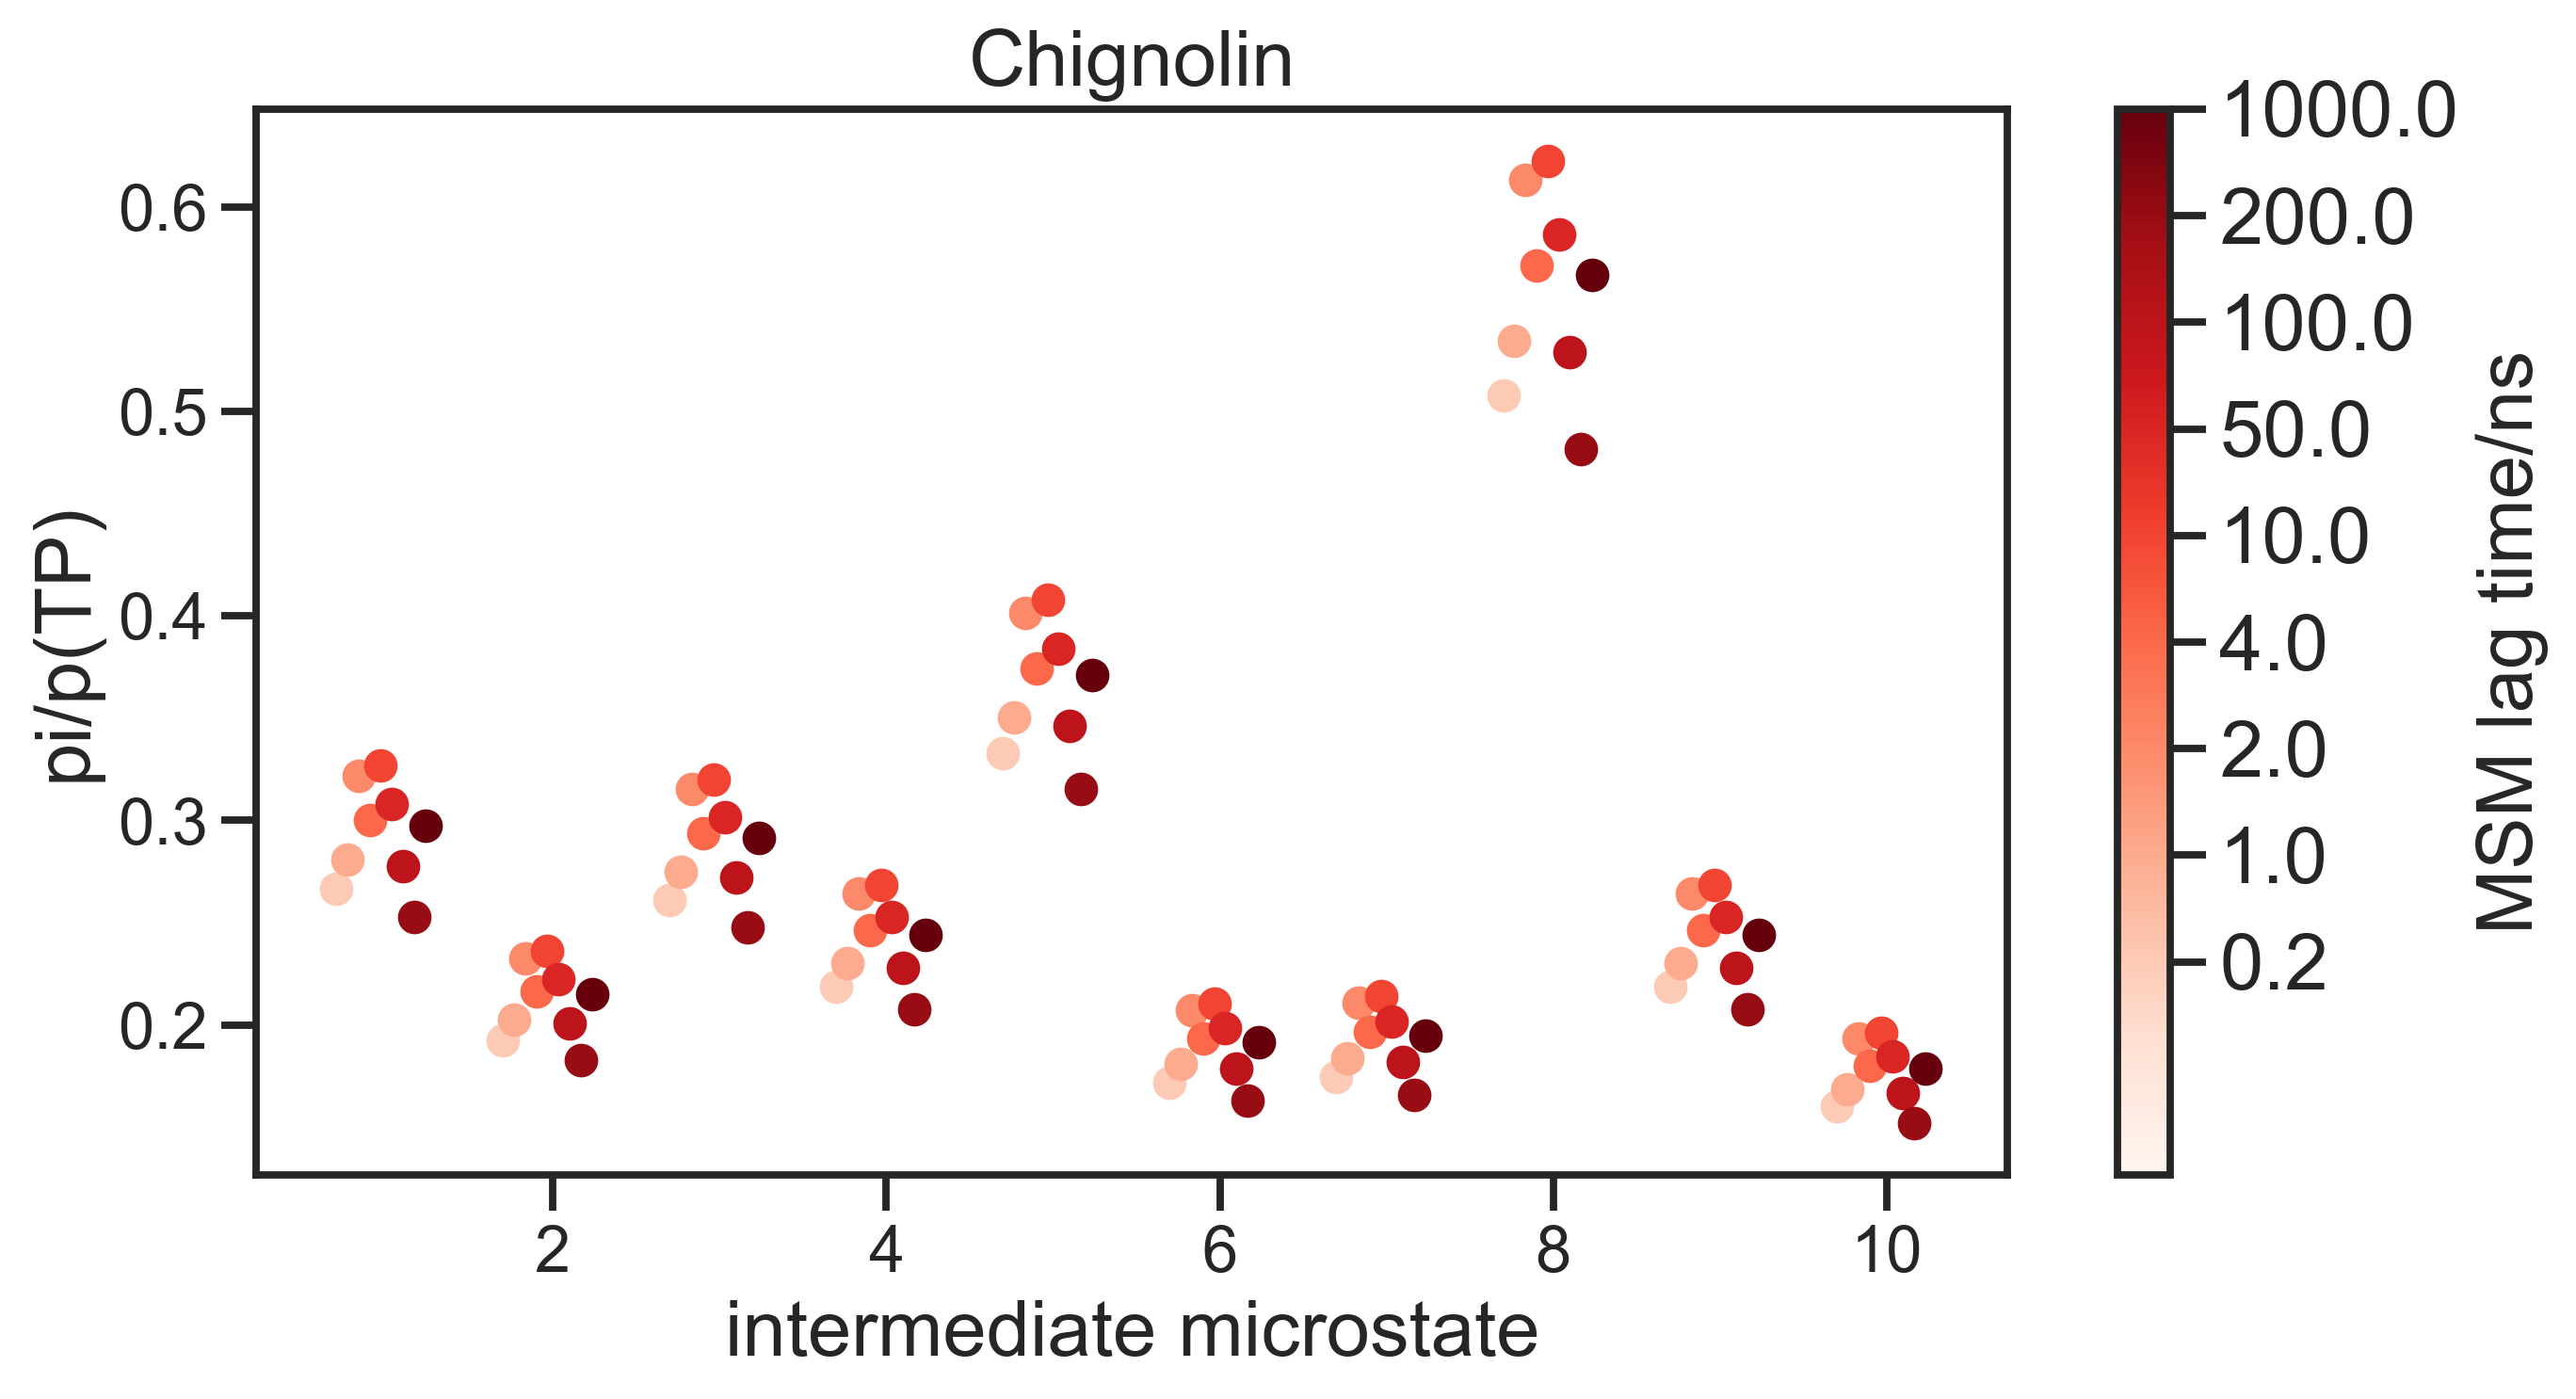

In [773]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), pi / a[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('pi/p(TP)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

plt.show()

In [788]:
pi_div_a = []

for i in range(9):
    pi_div_a.append(pi/a[i])

np.mean(np.std(np.array(pi_div_a), axis=0))*100

2.205718751059758

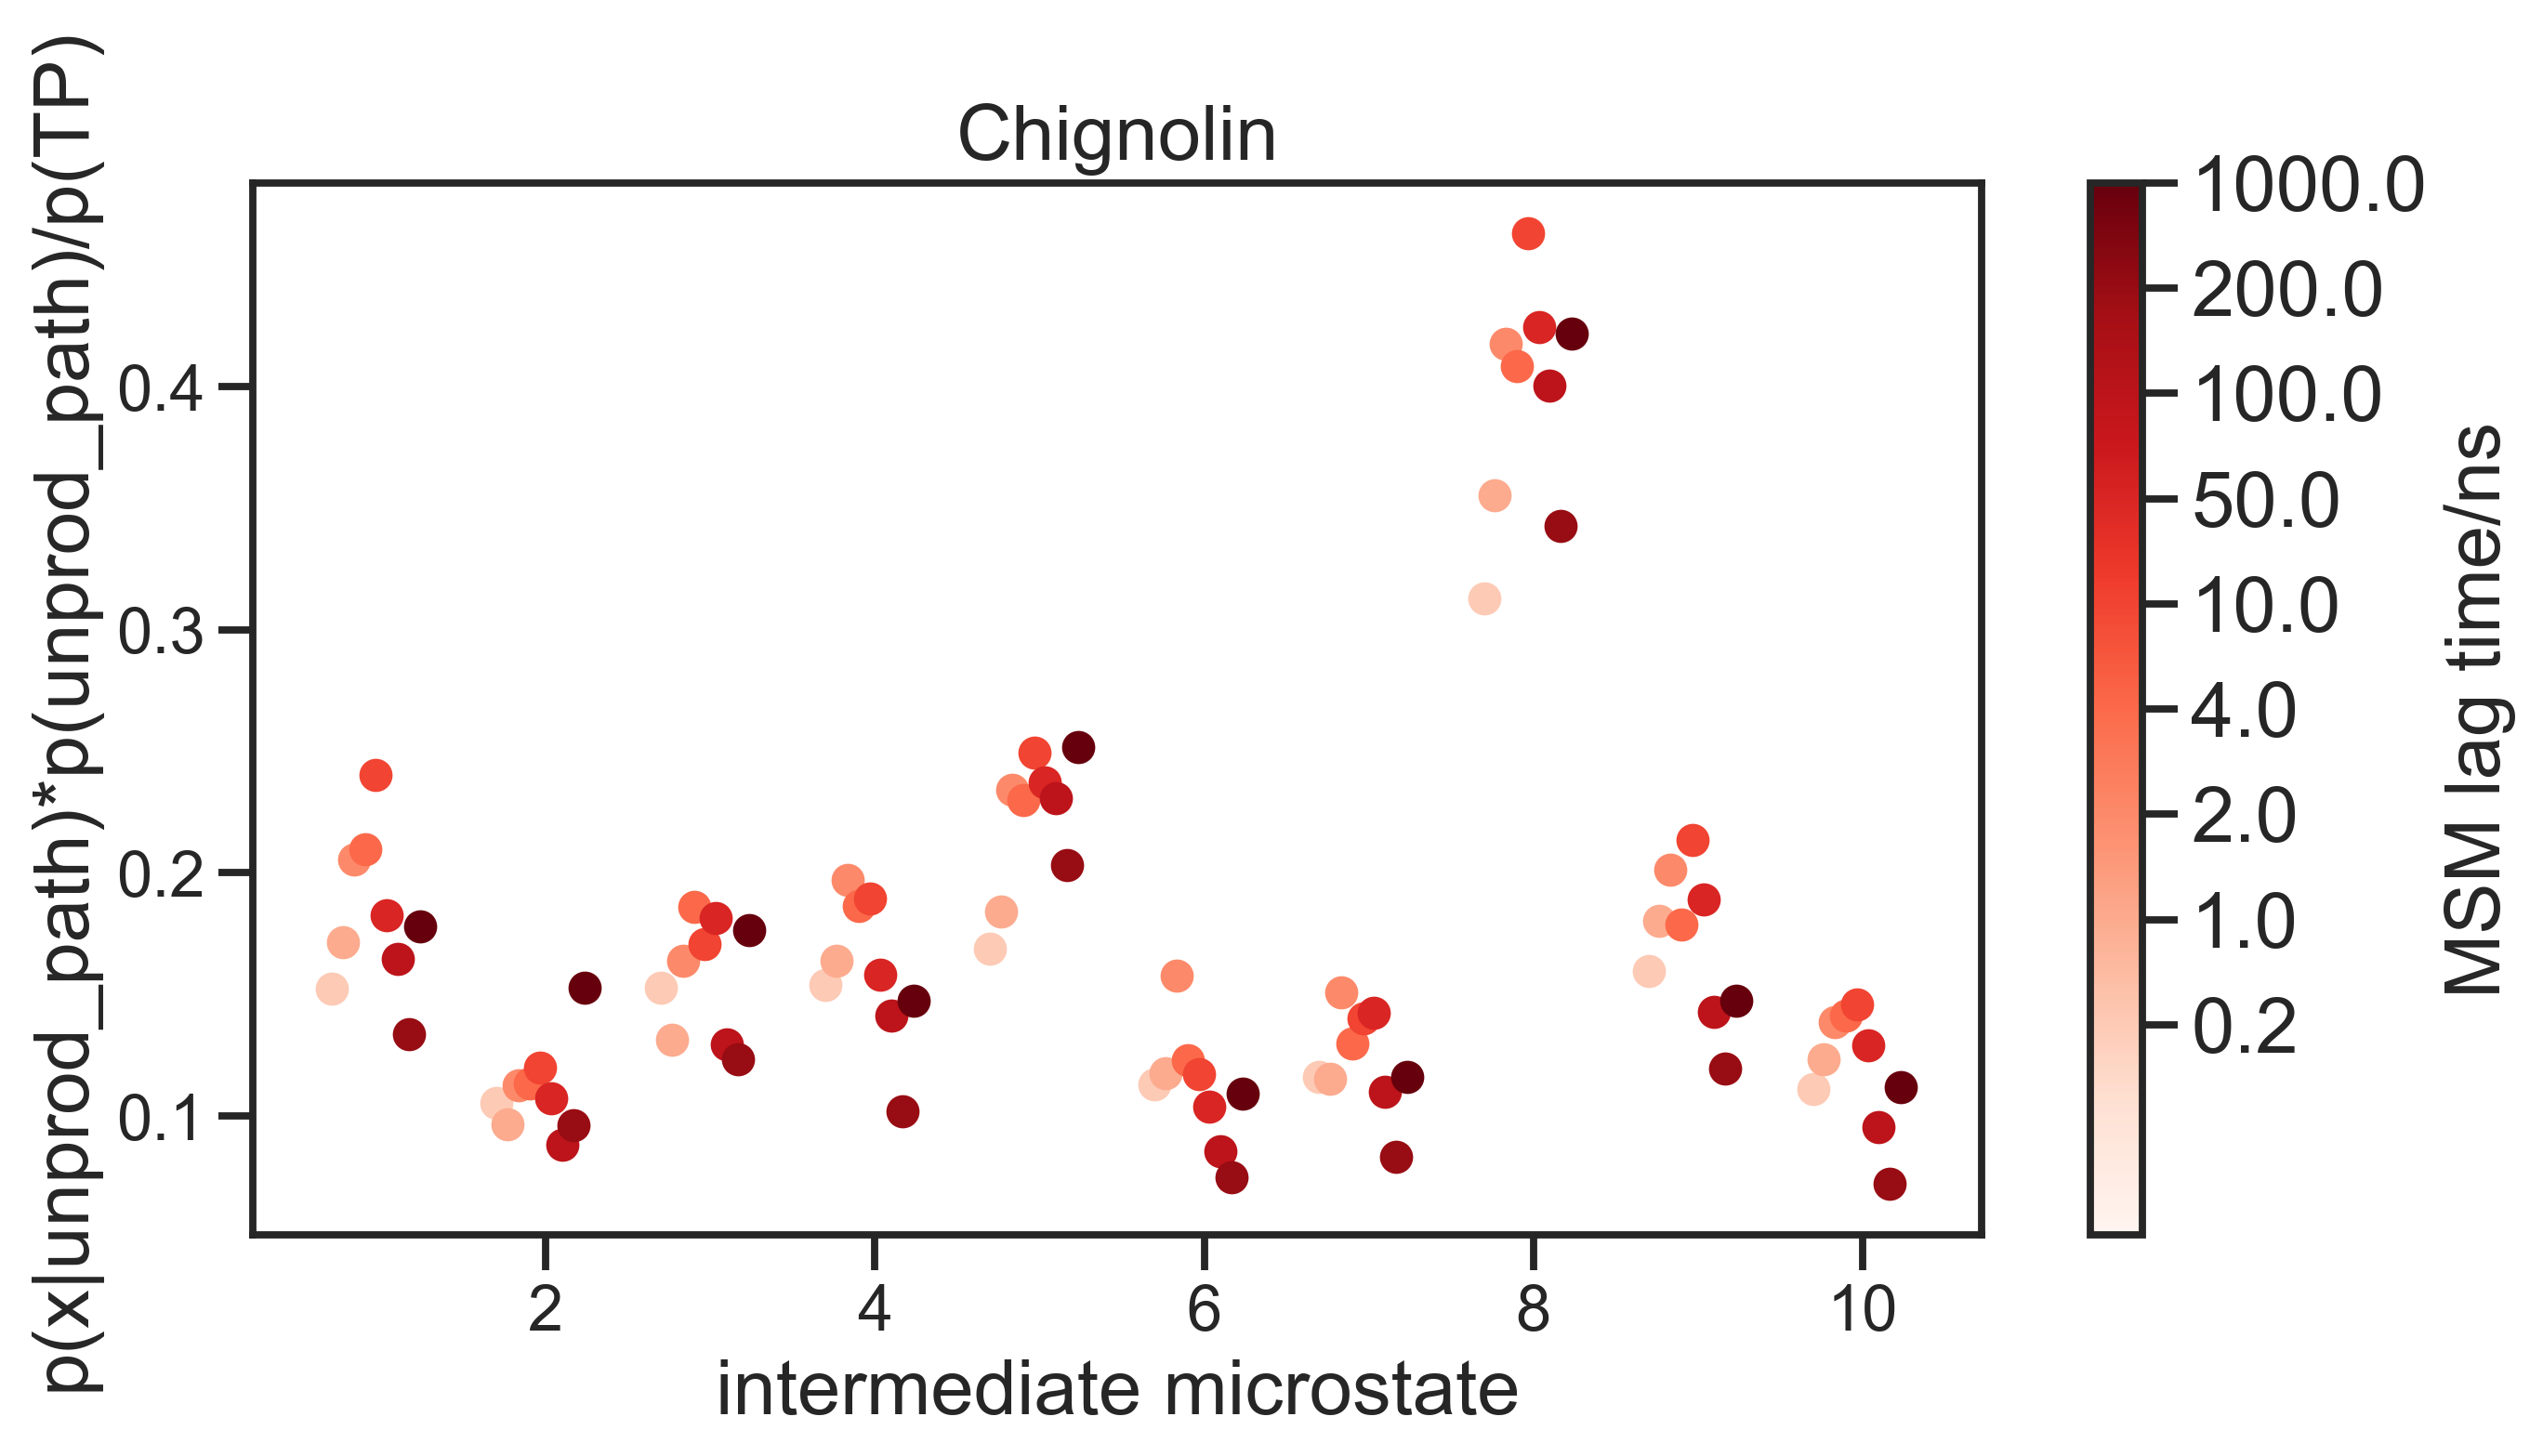

In [541]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), b[msm_index] * c[msm_index] / a[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|unprod_path)*p(unprod_path)/p(TP)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

plt.show()

In [1041]:
bc_div_a = []

for msm_index in range(9):
    bc_div_a.append(b[msm_index] * c[msm_index] / a[msm_index])

np.mean(np.std(np.array(bc_div_a), axis=0))*100

2.6326325066244918

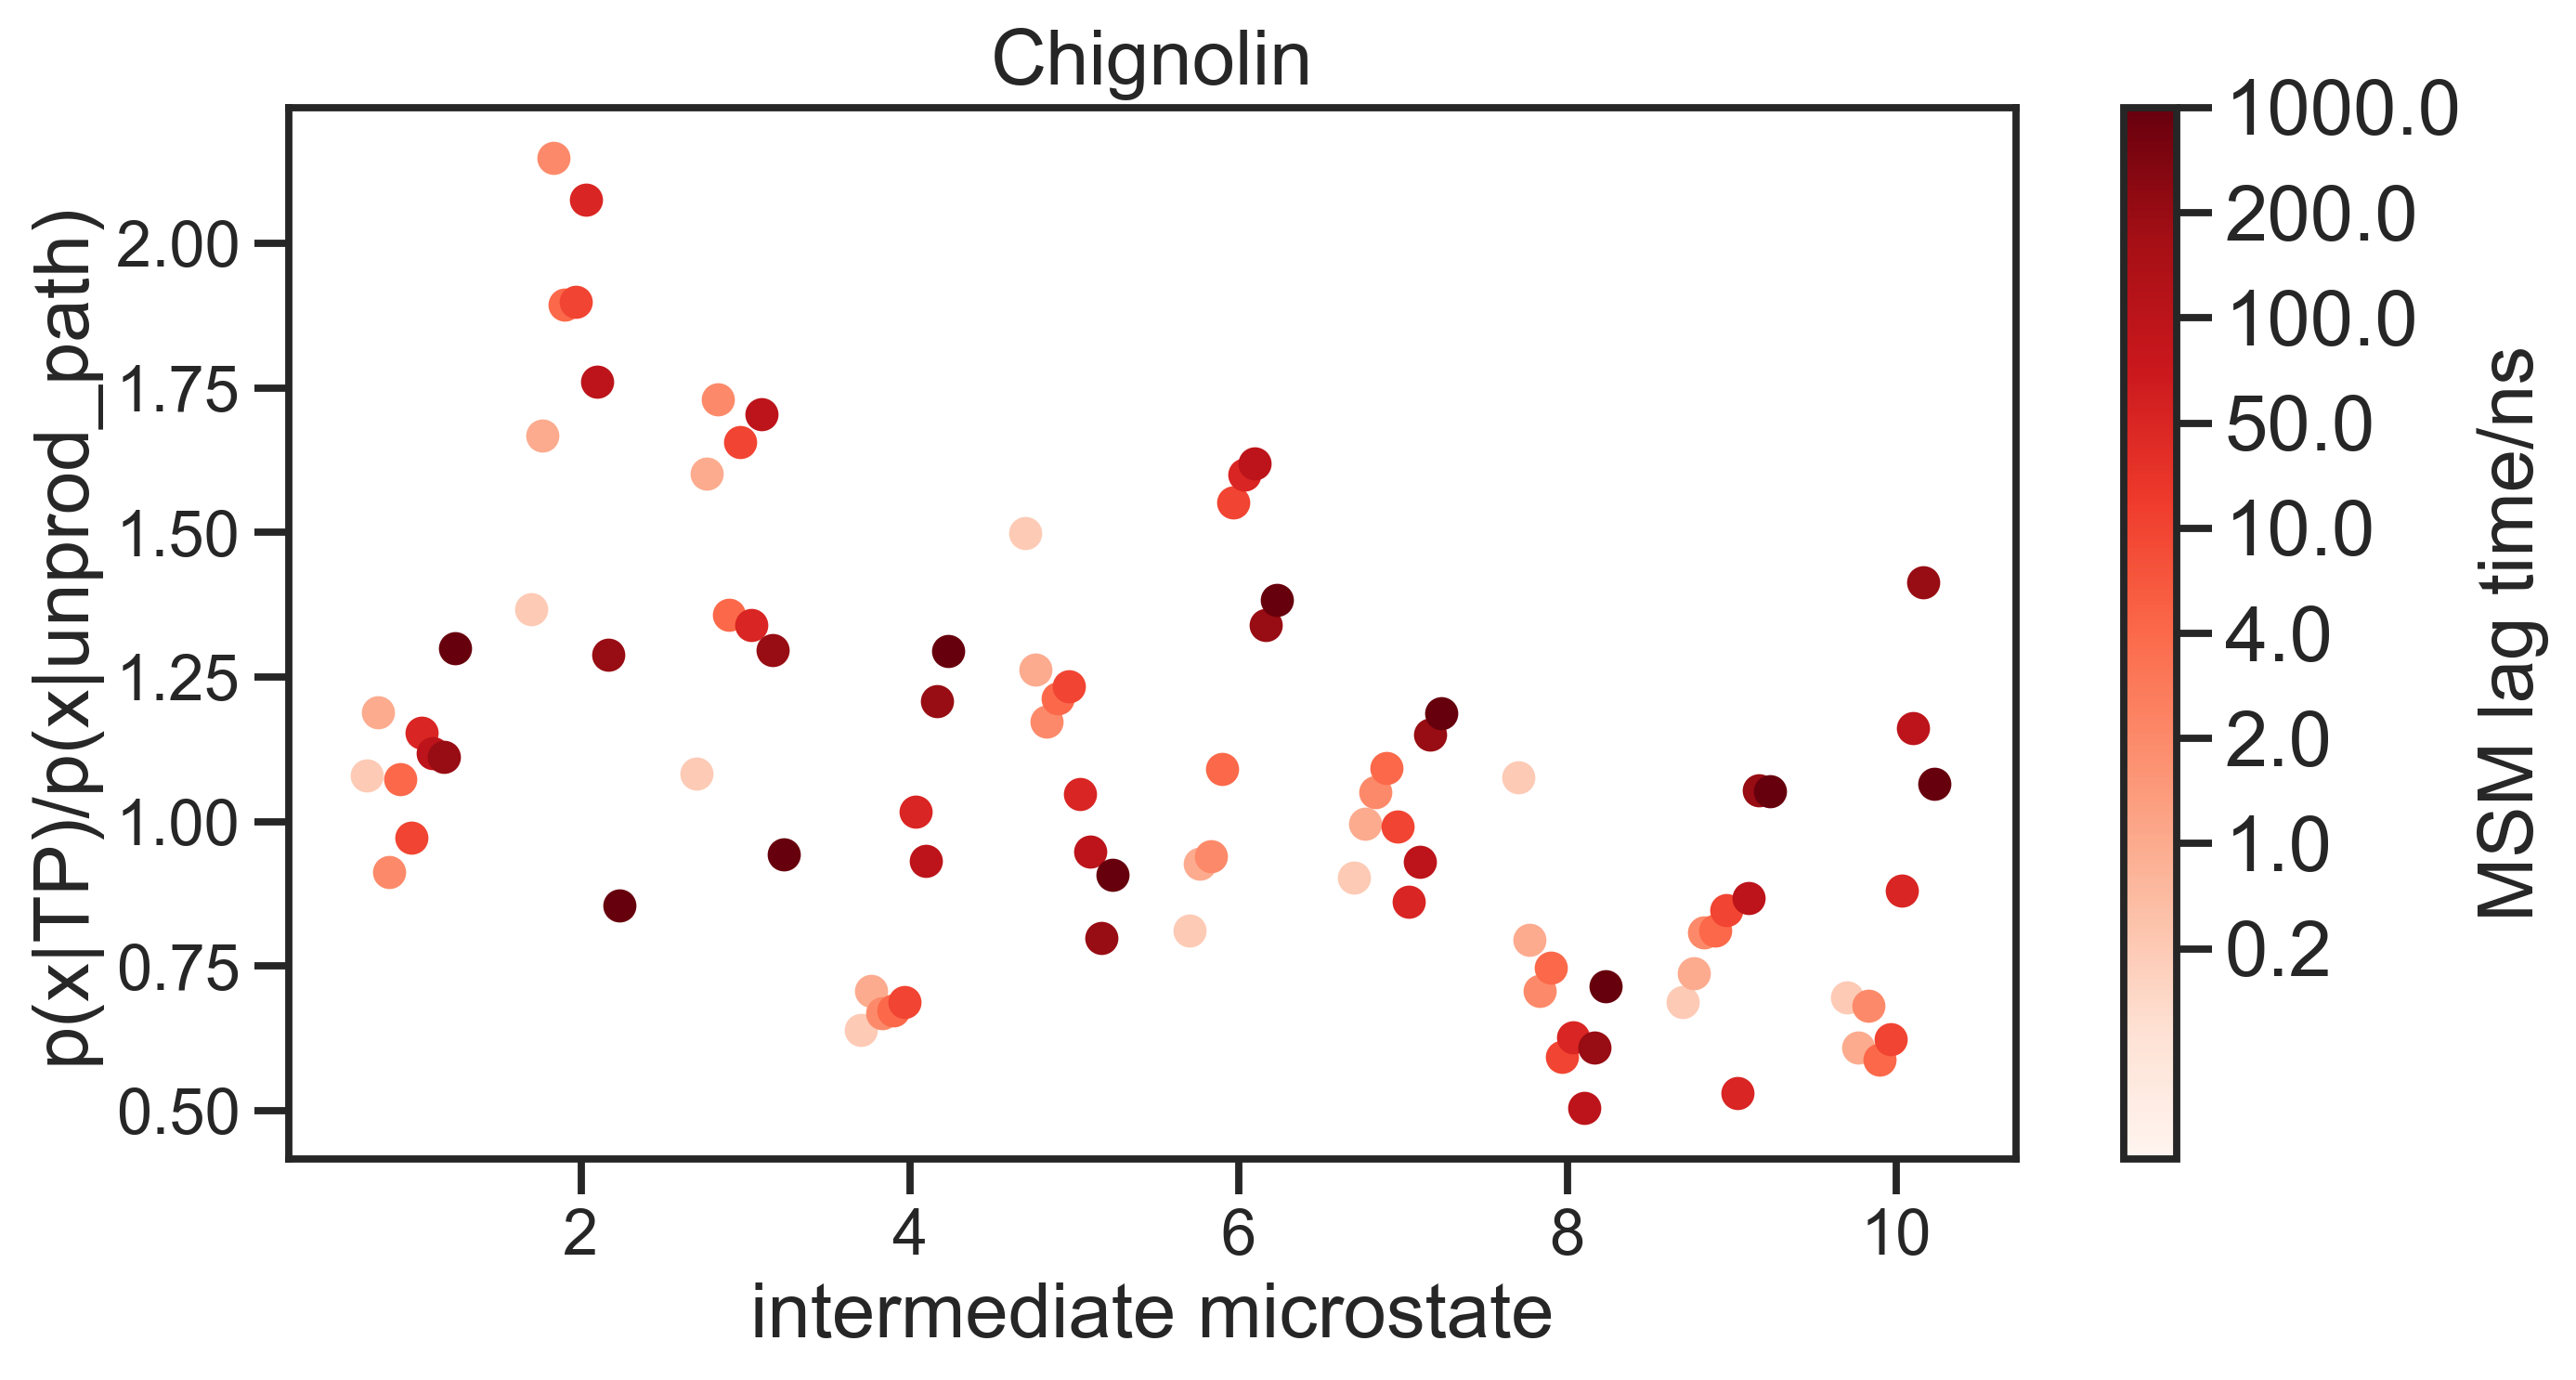

In [552]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index] / counts_msm_nonprod[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)/p(x|unprod_path)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

plt.show()

In [796]:
prod_div_unprod = []

for msm_index in range(9):
    prod_div_unprod.append(counts_msm[msm_index] / counts_msm_nonprod[msm_index])

np.mean(np.std(np.array(prod_div_unprod), axis=0))

0.21986088887134936

In [532]:
pi = msm[0].pi[[x for x in range(100) if x not in stateA+stateB]]
a = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000))
b = counts_msm_nonprod
c = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))

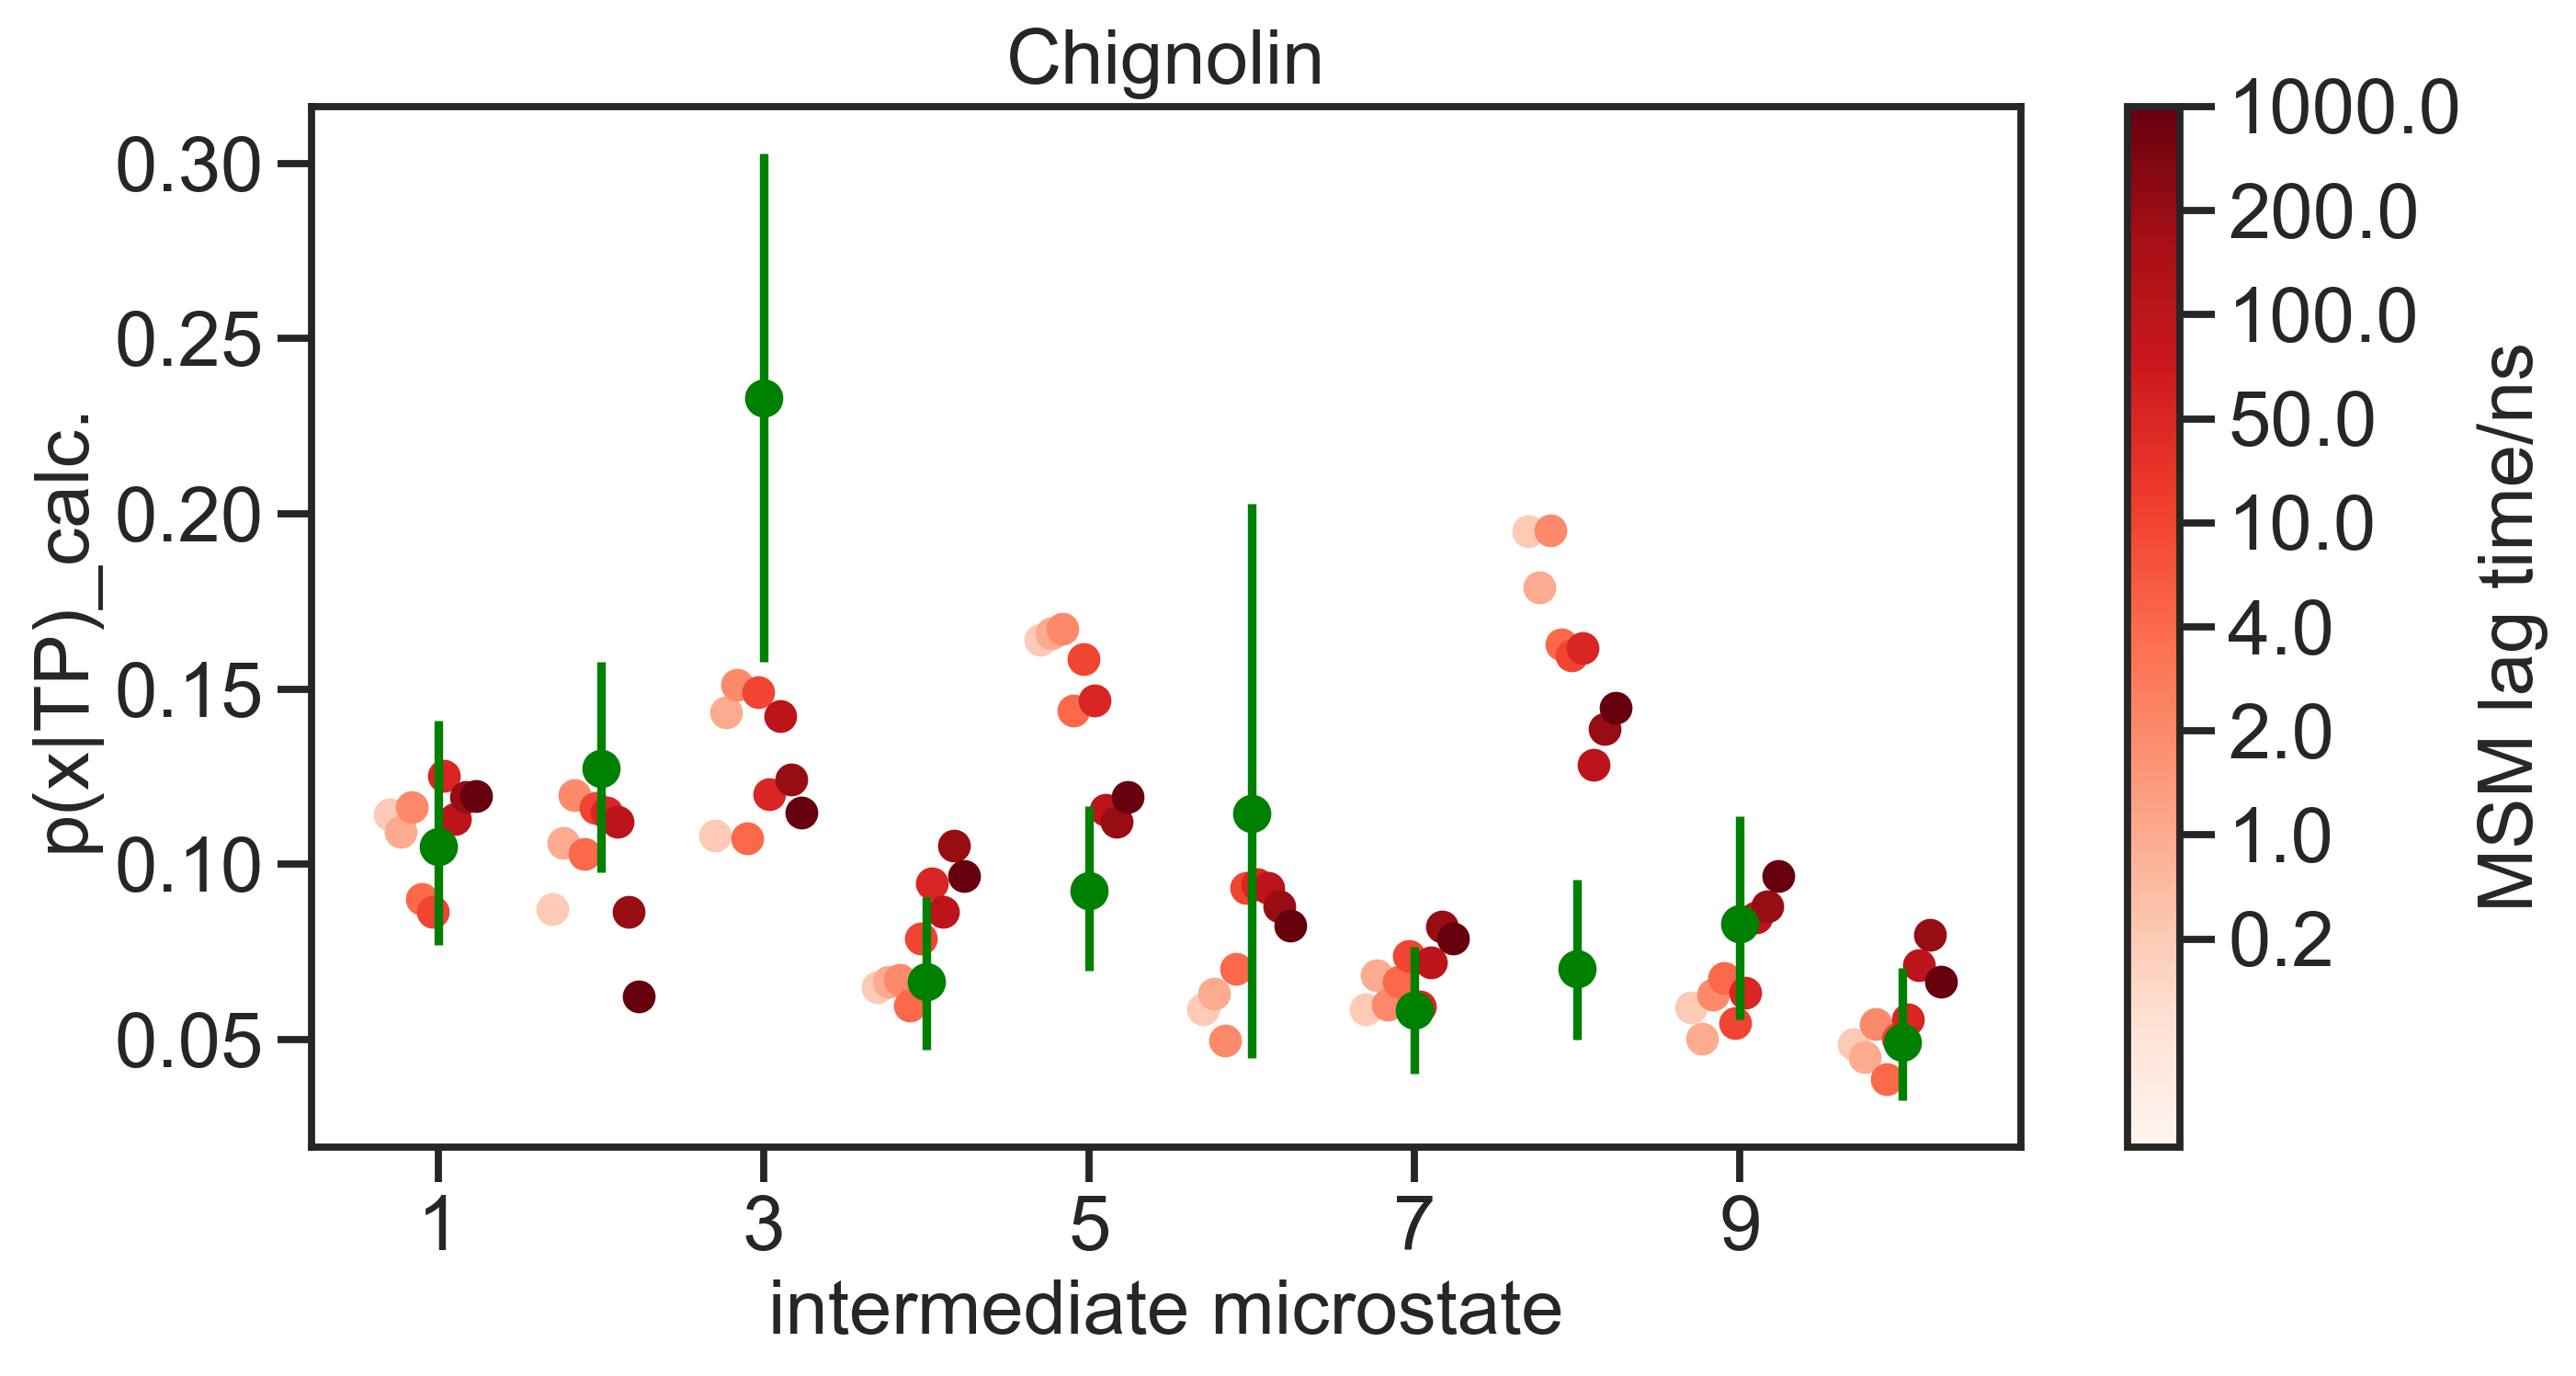

In [536]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), pi / a[msm_index] - b[msm_index] * c[msm_index] / a[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)_calc.', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

plt.show()

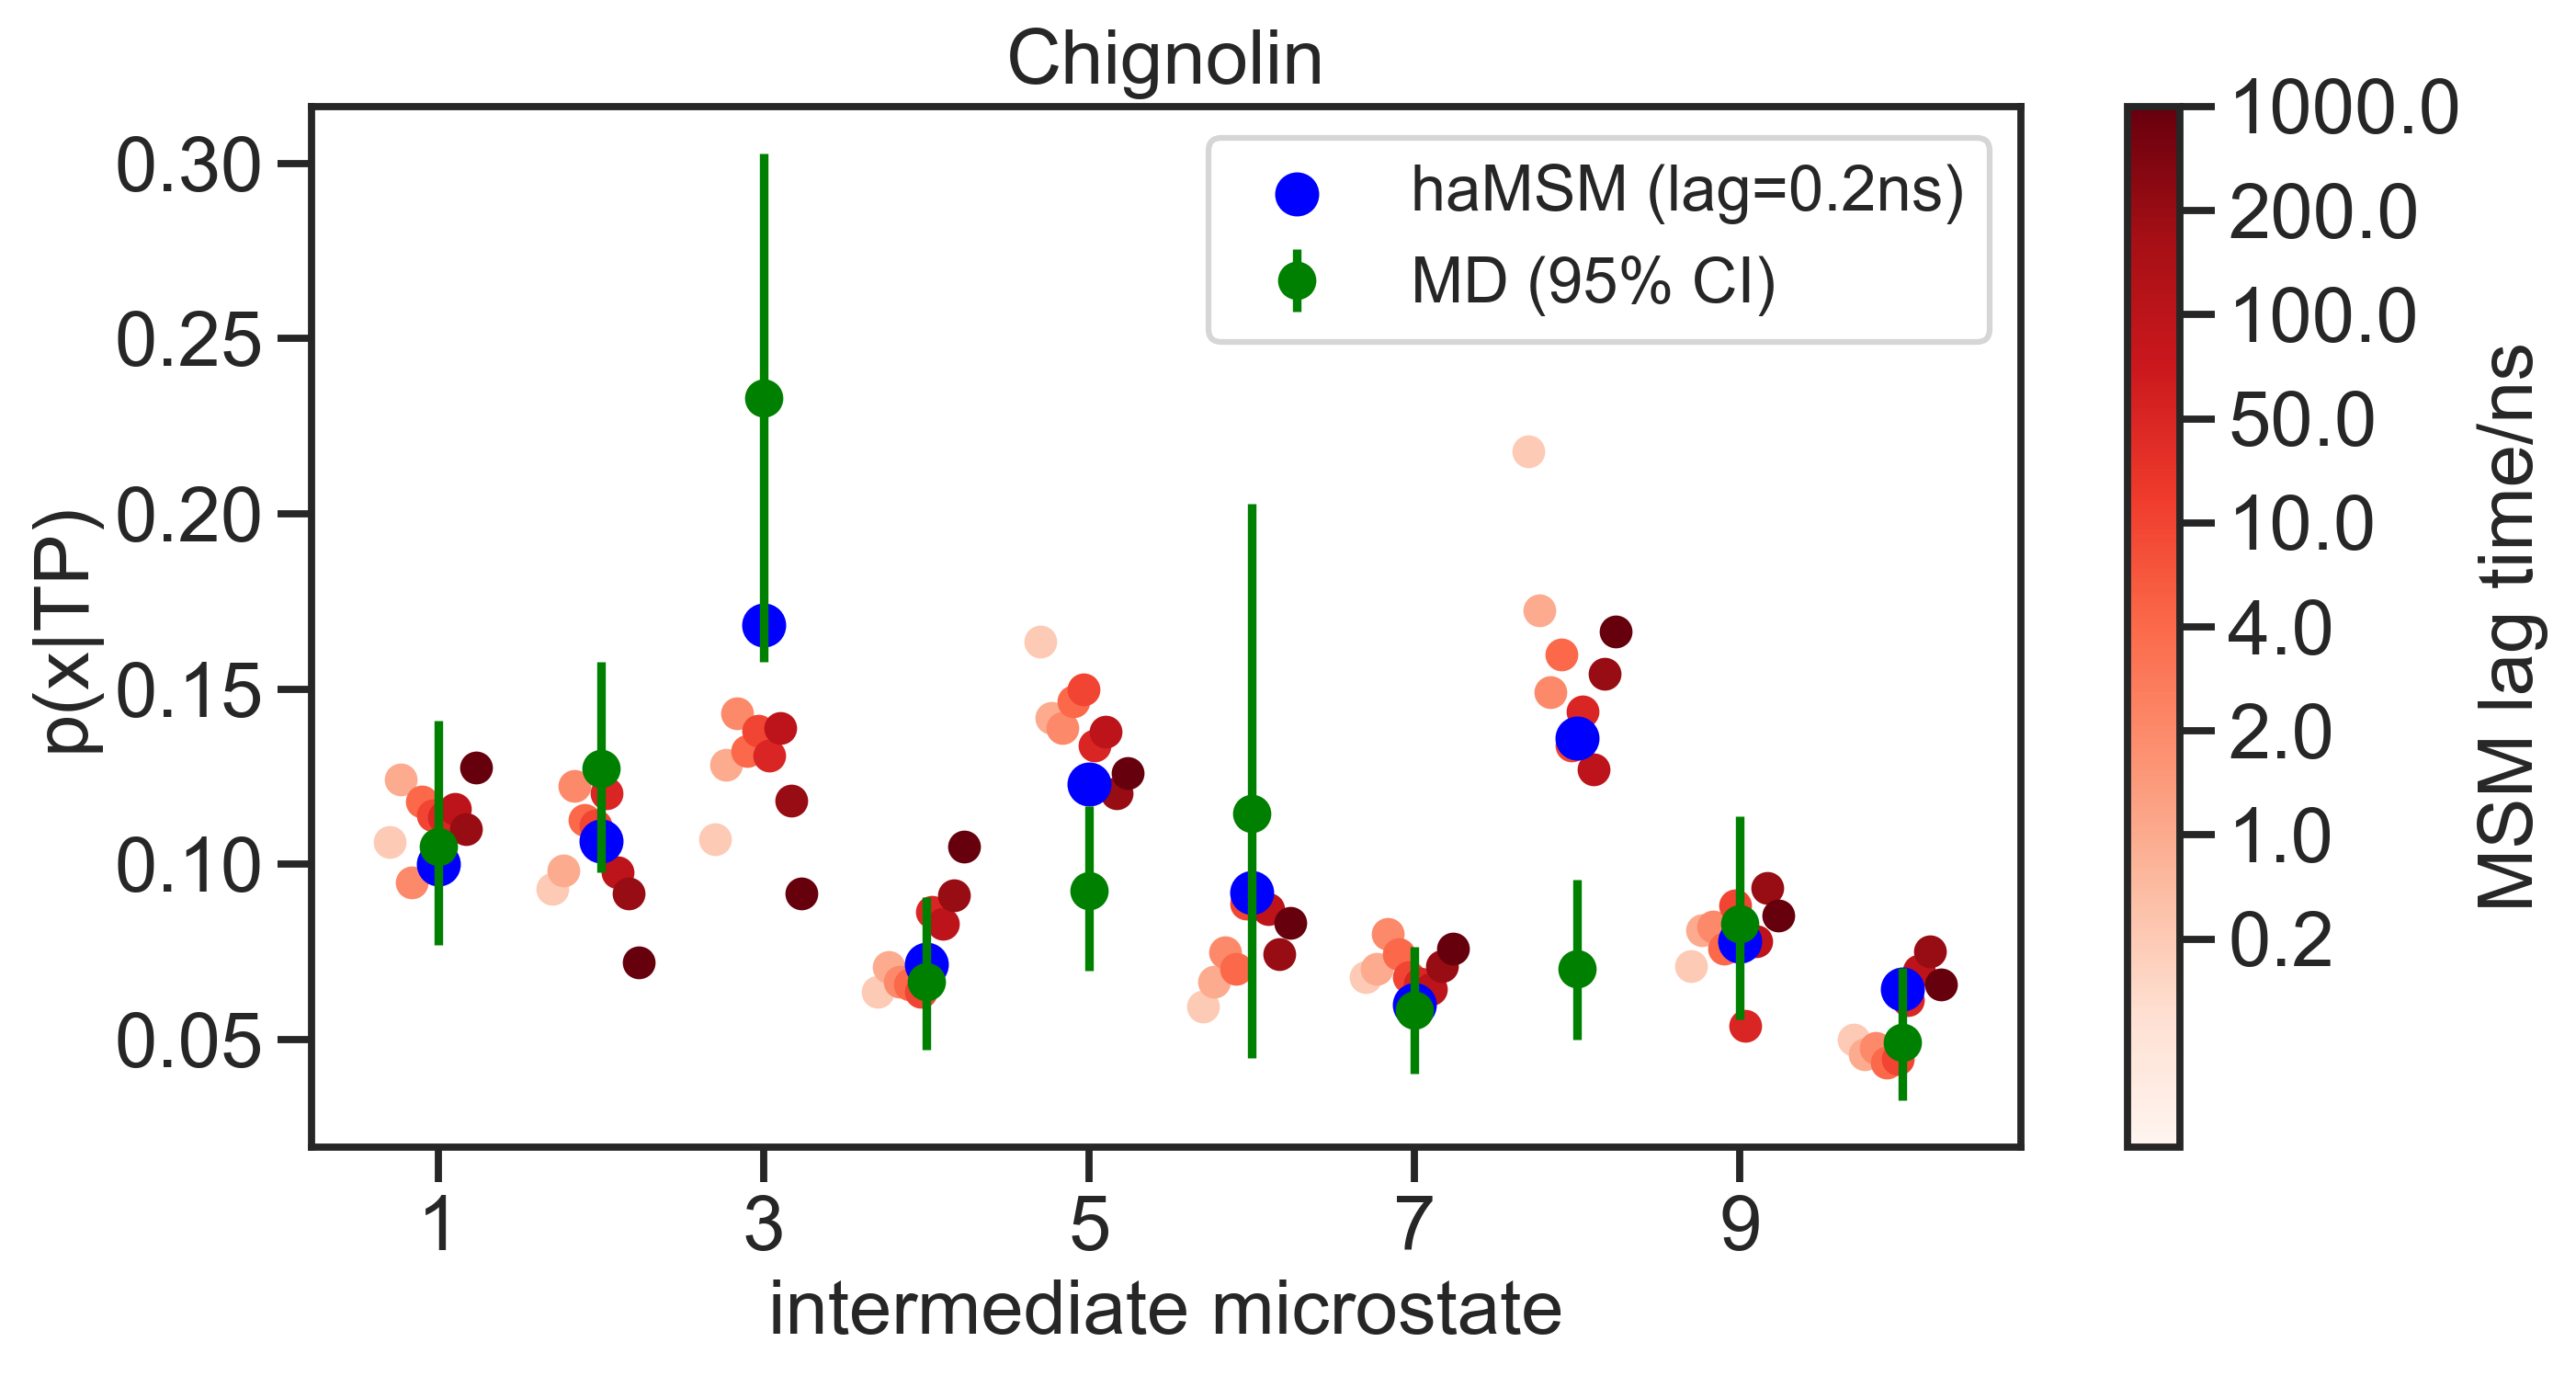

In [535]:
# FOR COMPARISON TO ABOVE

fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [452]:
### DEBUG: see state 8 (index 7)

In [538]:
# pi = p(x|TP) * p(TP) + p(x|unprod_path) * p(unprod_path)

In [ ]:
# p(x|TP) = pi/p(TP) - p(x|unprod_path) * p(unprod_path)/p(TP)
# p(x|TP) = pi/a - b * c/a

In [459]:
counts_msm[0][7]

0.21787454323995128

In [454]:
counts_msm_nonprod[0][7]

0.2023260284505959

In [ ]:
# p(TP)

In [472]:
(np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000))[8]

0.008615

In [ ]:
# p(unprod_path)

In [473]:
(np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))[8]

0.01562

In [478]:
counts_msm[8][7] * (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000))[8] + counts_msm_nonprod[8][7] * (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))[8]

0.005070025323579066

In [487]:
msm[8].pi[[x for x in range(100) if x not in stateA+stateB]][7]

0.004908181835726618

In [506]:
# ok so this looks fine - must have a mistake in the code above?

In [508]:
# p(TP) - per msm

In [509]:
a = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm]) / (np.array(total_counts)*100000))

In [ ]:
# p(unprod_path) - per msm

In [514]:
c = (np.array([np.sum([len(j) for j in i]) for i in int_trajs_msm_nonprod]) / (np.array(total_counts)*100000))

In [517]:
# these two above are per msm

In [519]:
# pi - per state

In [521]:
pi = msm[0].pi[[x for x in range(100) if x not in stateA+stateB]]

In [522]:
# p(x|unprod_path) - per msm and per state

In [523]:
b = counts_msm_nonprod

In [525]:
pi / a[msm_index] - b[msm_index] * c[msm_index] / a[msm_index]

array([0.11941708, 0.06225658, 0.1148687 , 0.09677481, 0.1192966 ,
       0.08256303, 0.07885066, 0.14460459, 0.09678493, 0.06663634])

In [526]:
counts_msm[msm_index]

array([0.12774339, 0.07203151, 0.09172763, 0.10523354, 0.12605515,
       0.08328644, 0.07597074, 0.16657288, 0.08553742, 0.06584131])

In [527]:
# ok looking good - correct above

In [553]:
####

In [576]:
# we're gonna go off from the productive / unproductive ratio and p(TP) / p(unprod_path) ratio

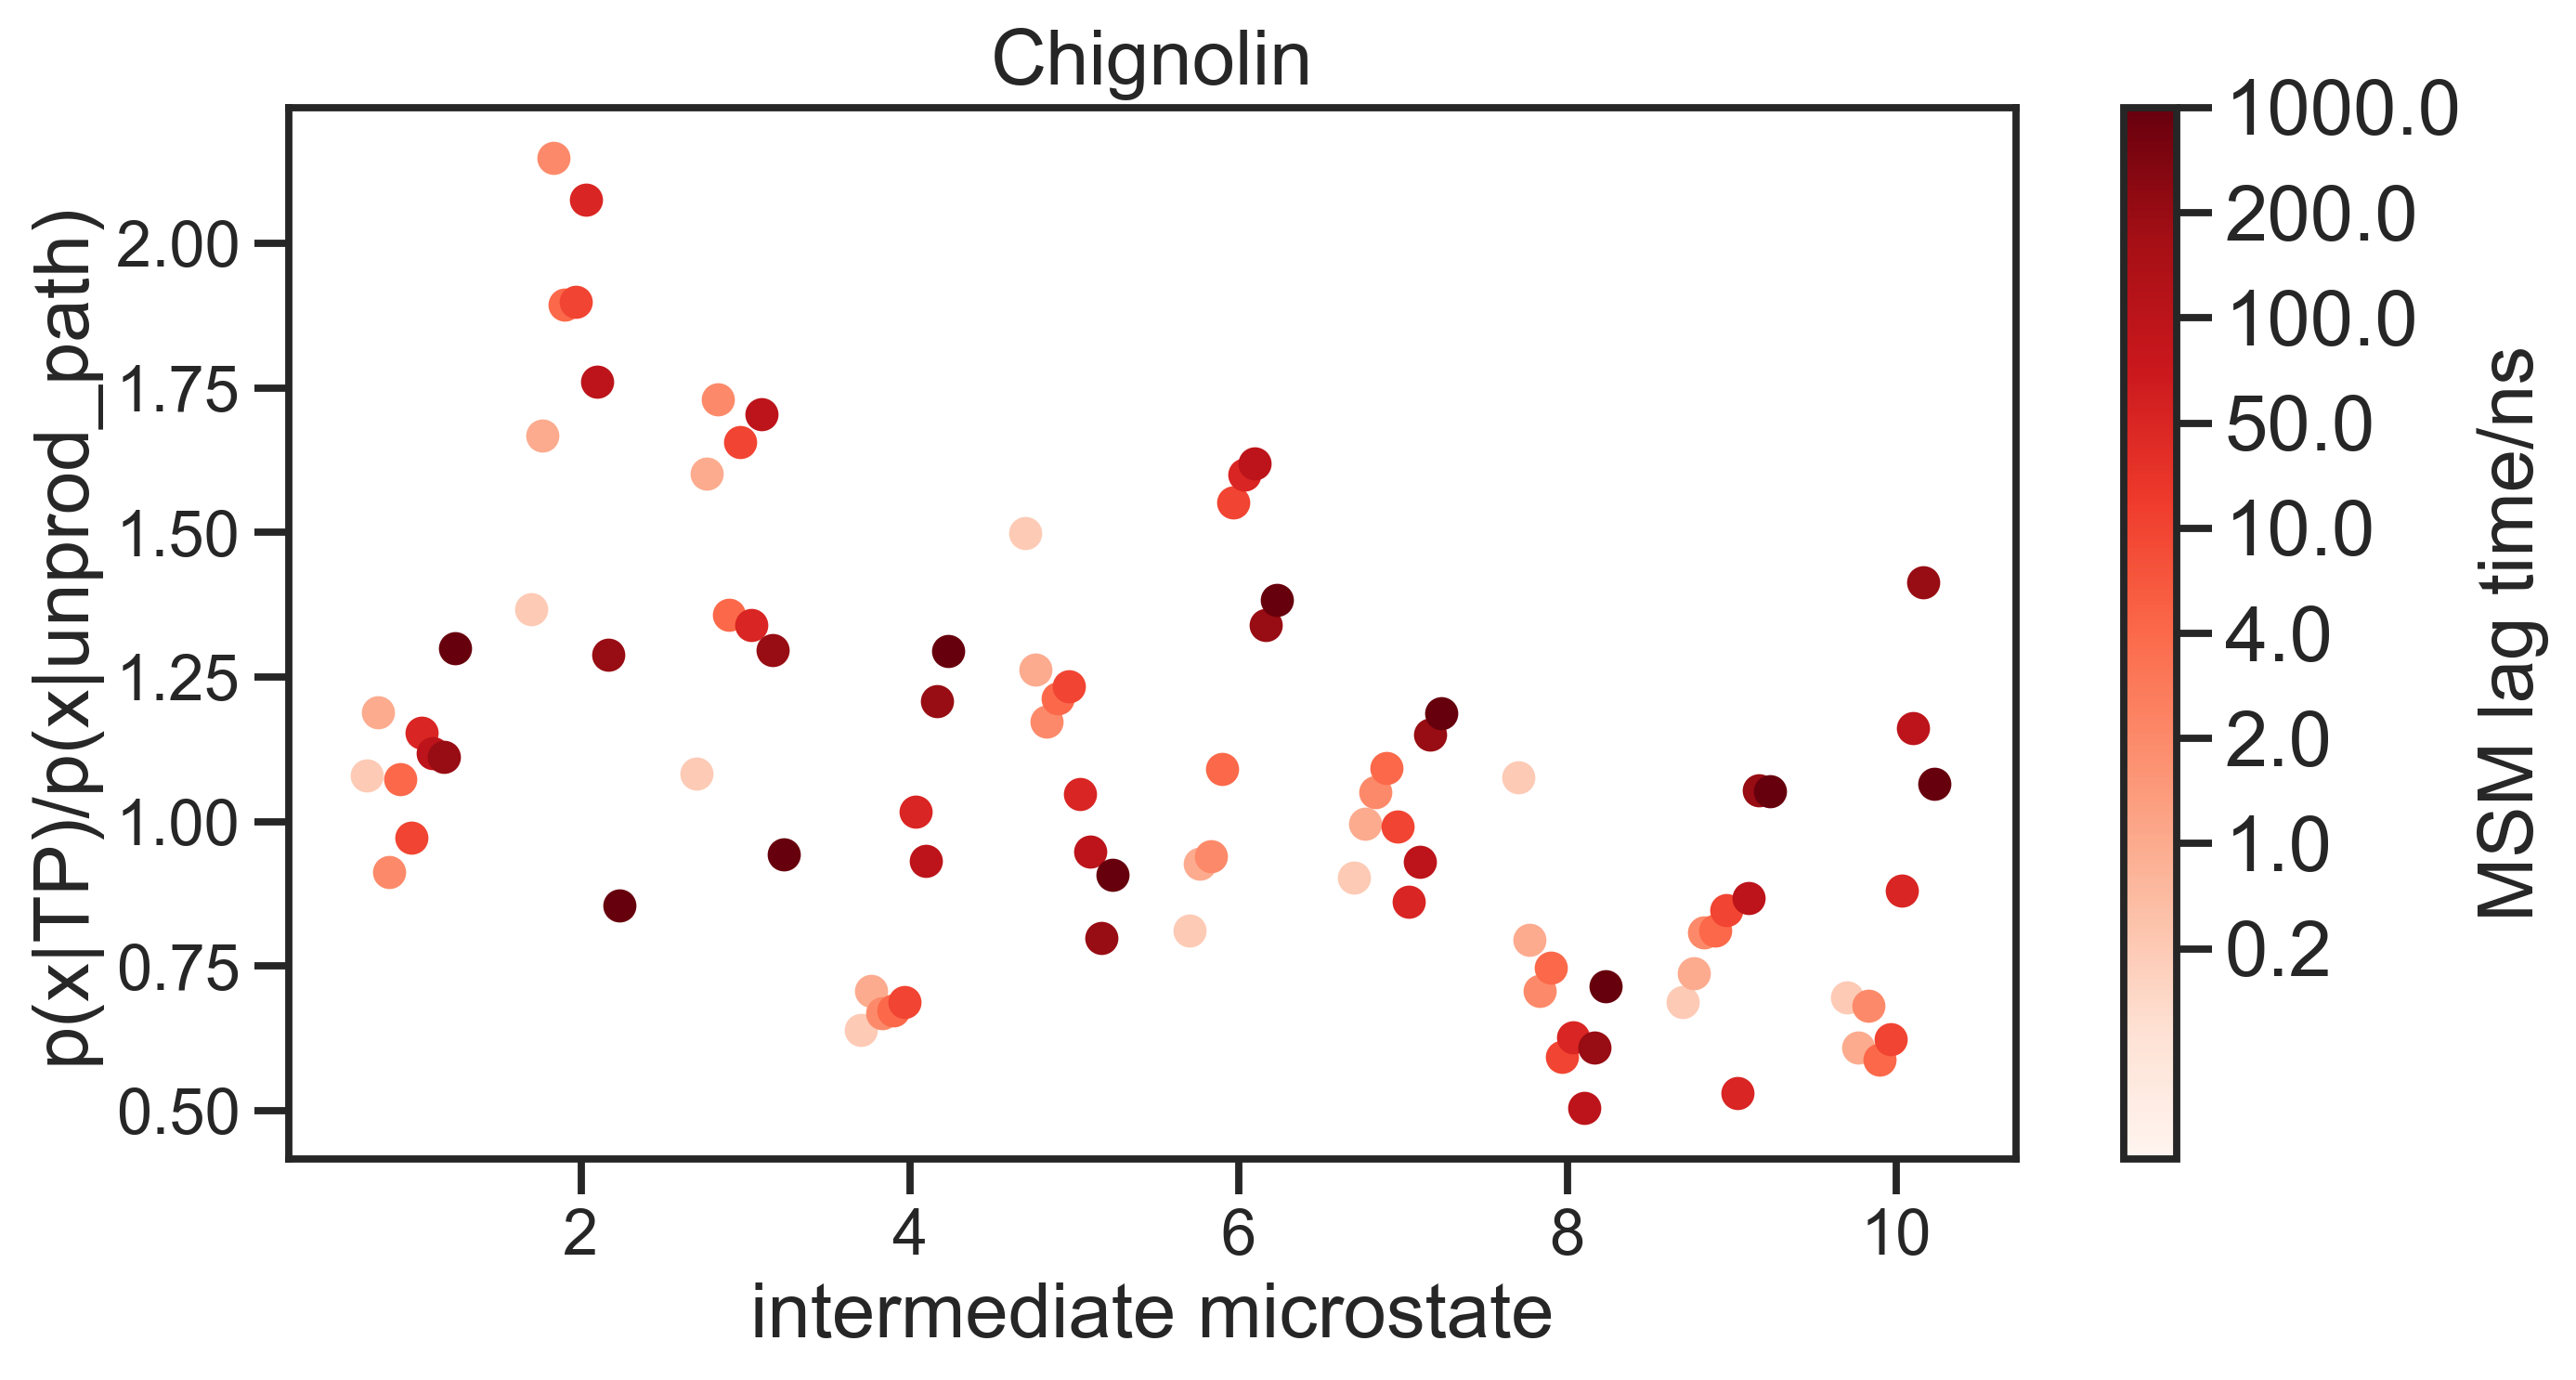

In [556]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index] / counts_msm_nonprod[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)/p(x|unprod_path)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

plt.show()

In [798]:
prod_div_unprod = []

for msm_index in range(9):
    prod_div_unprod.append(counts_msm[msm_index] / counts_msm_nonprod[msm_index])

np.mean(np.std(np.array(prod_div_unprod), axis=0))

0.21986088887134936

In [803]:
np.array(prod_div_unprod)[:,1]

array([1.36702089, 1.66819034, 2.1484426 , 1.89361922, 1.89897768,
       2.0748281 , 1.76110168, 1.28863797, 0.85561387])

In [814]:
import scipy

In [817]:
[scipy.stats.linregress(np.array(prod_div_unprod)[:,i], c/a) for i in range(9)]

[LinregressResult(slope=-0.779338787631975, intercept=2.6064257095858605, rvalue=-0.38623292238298756, pvalue=0.30453804389185946, stderr=0.7034737241459283),
 LinregressResult(slope=0.2881744087977869, intercept=1.2691036353142917, rvalue=0.5258498823187796, pvalue=0.14592200653190684, stderr=0.17618074632991215),
 LinregressResult(slope=0.23093865218417903, intercept=1.4217967271076946, rvalue=0.28272141326169703, pvalue=0.46104207384681894, stderr=0.2961413207875352),
 LinregressResult(slope=-0.3314924806124089, intercept=2.036391552914012, rvalue=-0.36483111411247743, pvalue=0.3343512228760664, stderr=0.31975464146734206),
 LinregressResult(slope=0.27677964664548427, intercept=1.4378200245090536, rvalue=0.2597220336529728, pvalue=0.49974543479368394, stderr=0.38896552478270646),
 LinregressResult(slope=0.08799991612180866, intercept=1.6378460510228467, rvalue=0.12071727606998262, pvalue=0.7570436972923706, stderr=0.2735118294783415),
 LinregressResult(slope=-0.07301341042793486, in

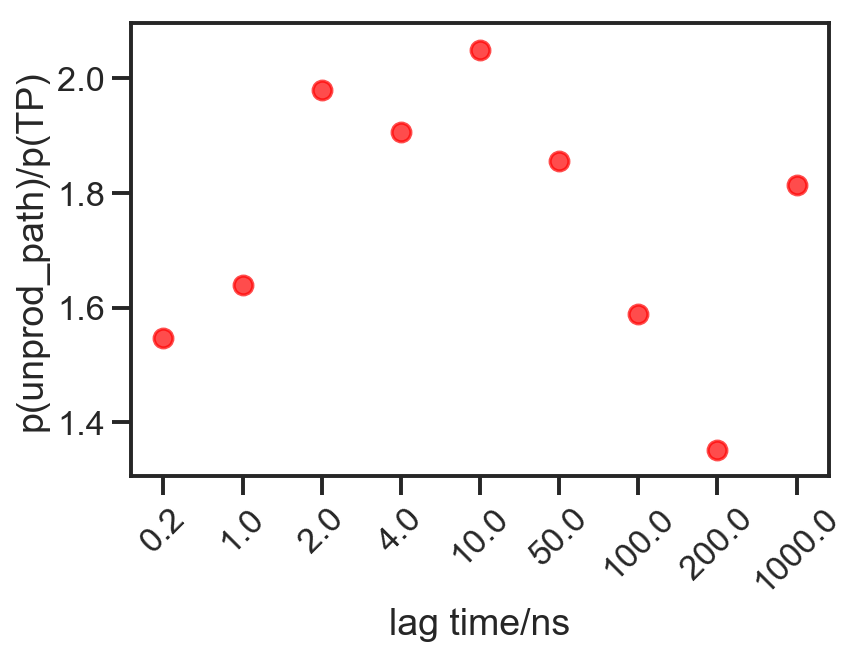

In [591]:
plt.figure(dpi=150)
plt.scatter(range(len(c/a)),c/a, c='red', alpha=0.7)
plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('p(unprod_path)/p(TP)')
plt.show()

In [797]:
np.std(c/a)

0.21640206783174842

In [557]:
# let's calc the empiricals for the above

In [592]:
# for later -- plot fundamental sequences re-normalizing without the one-step
# per microstate statistics of the FS

In [639]:
int_trajs, int_trajs_nonprod = get_trans_paths_md_nonprod(dtrajs)

In [640]:
len(int_trajs)

210

In [641]:
len(int_trajs_nonprod)

2455

In [642]:
bootstrap_counts_nonprod = count_md_bootstrap(int_trajs_nonprod)

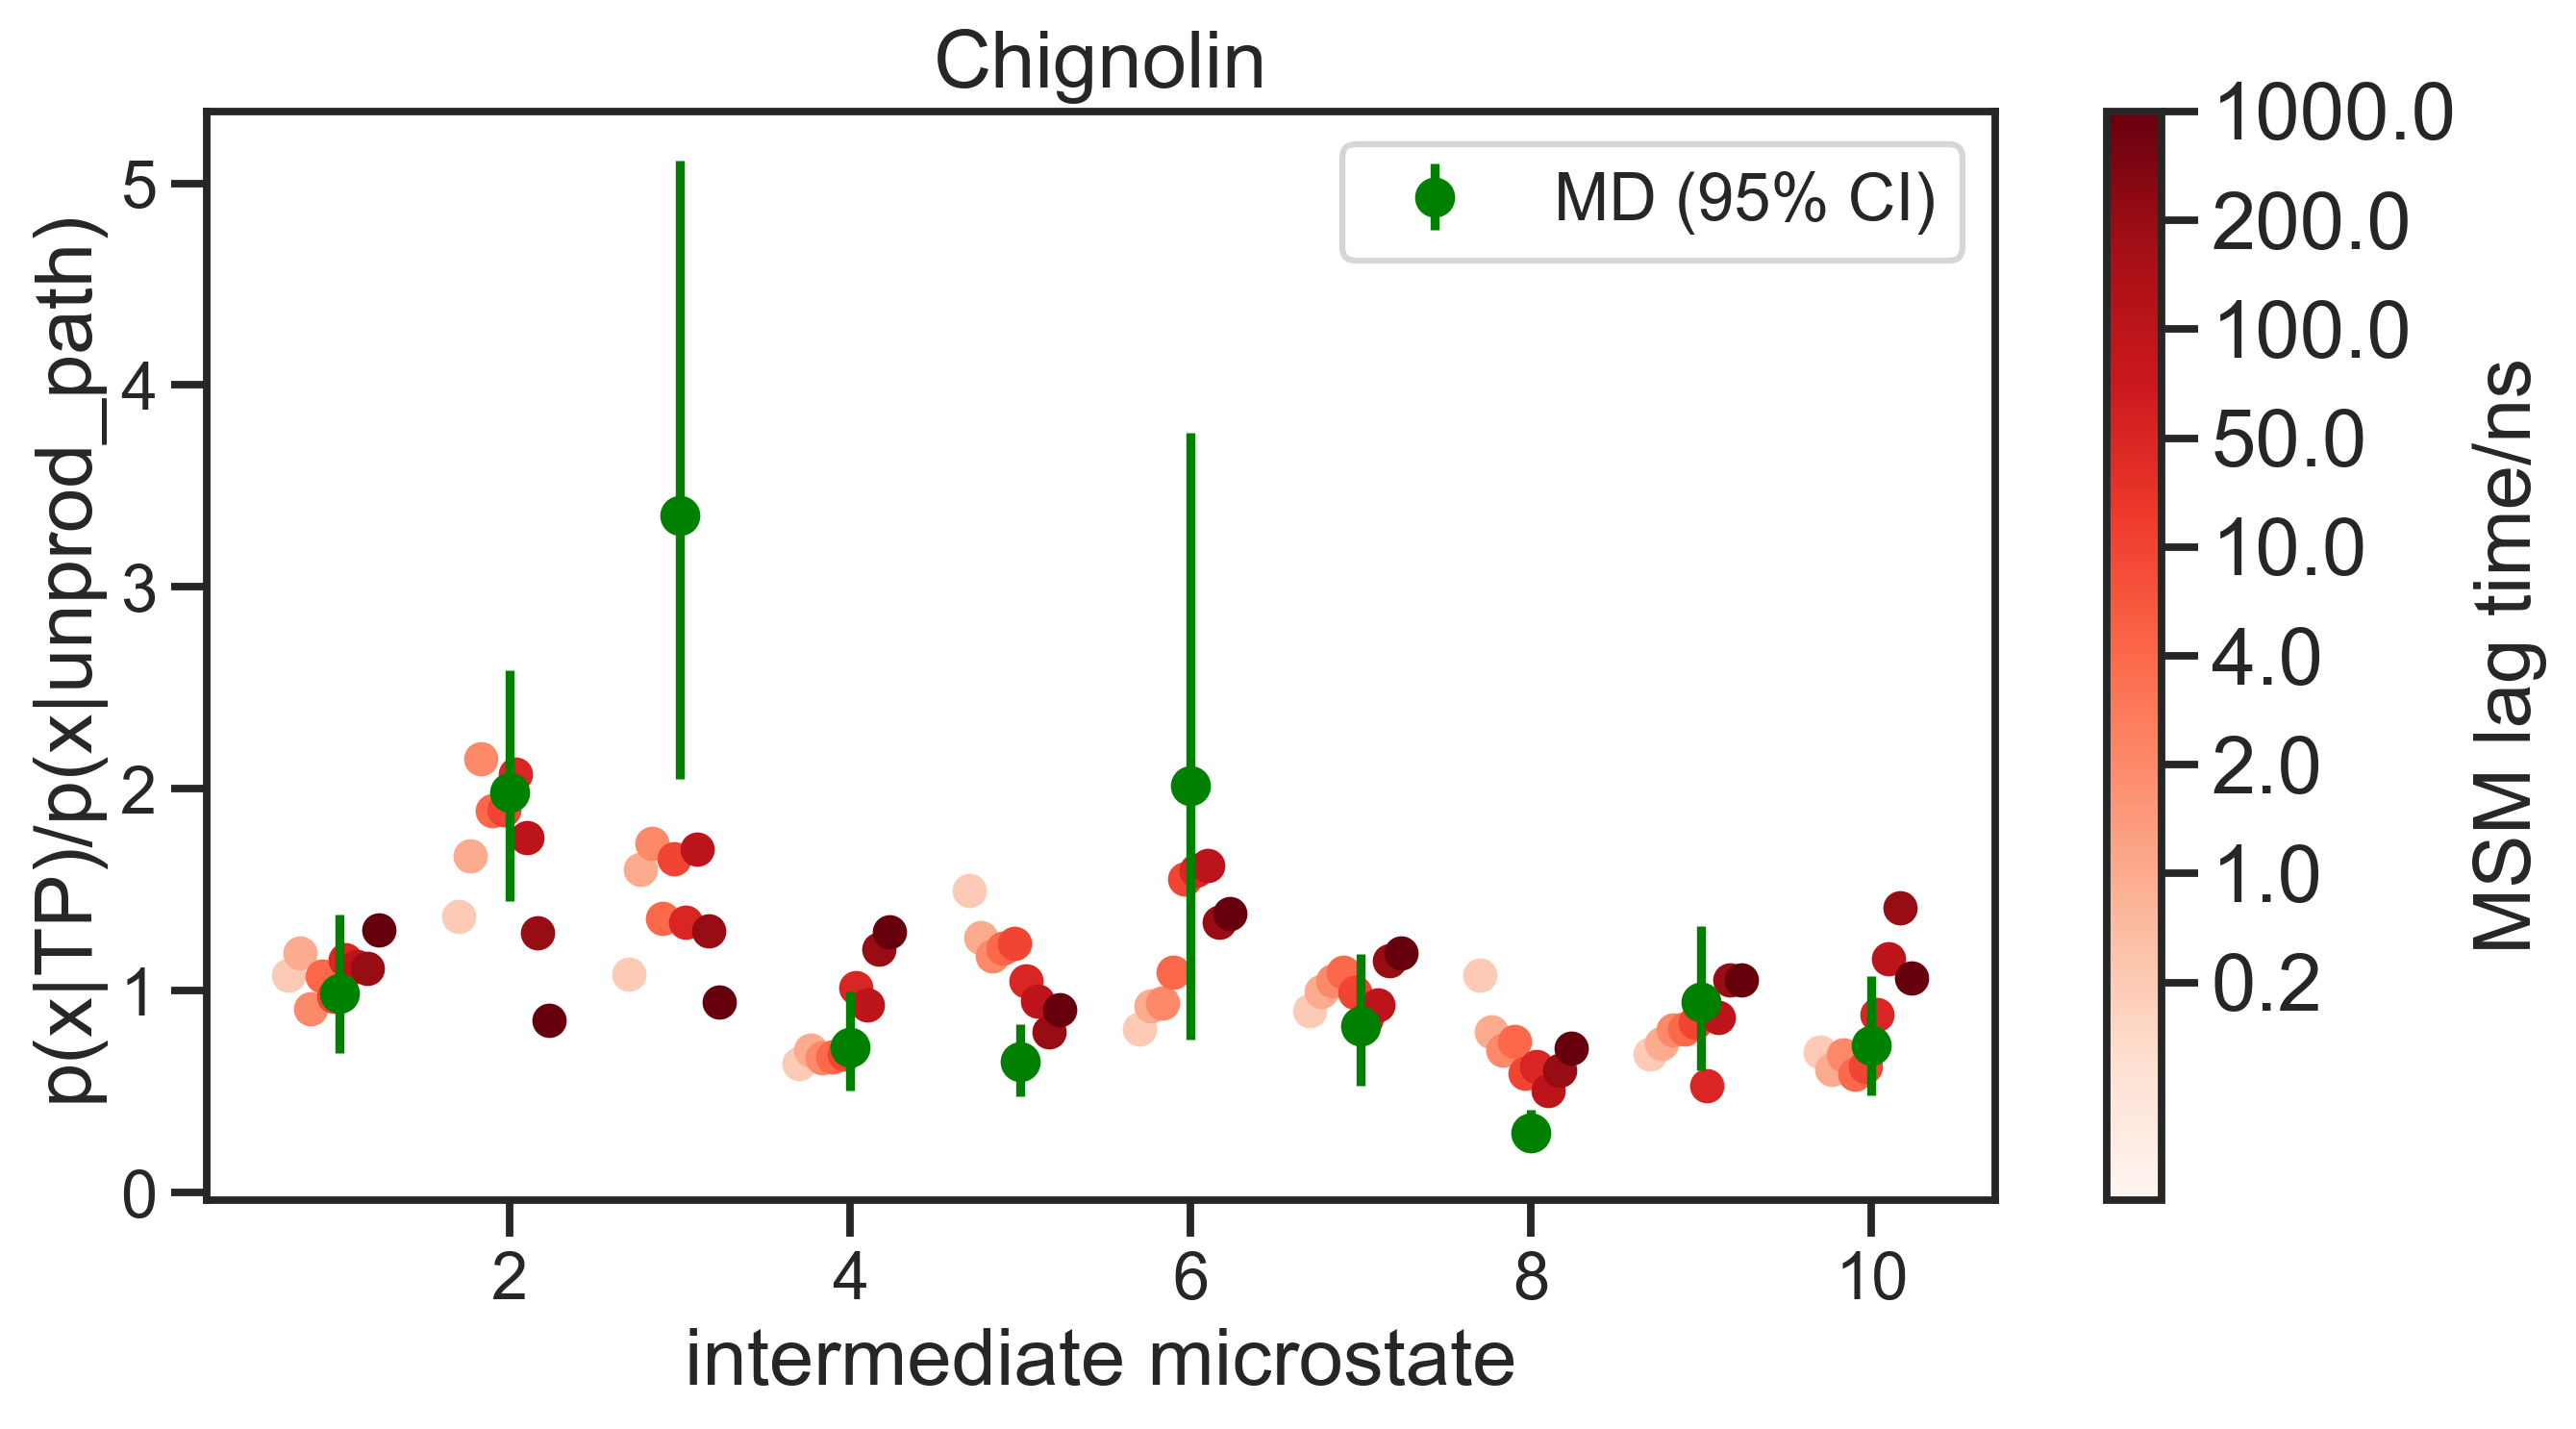

In [820]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index] / counts_msm_nonprod[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0), yerr=[(np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0)-np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 2.5, axis=0)), (np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 97.5, axis=0)-np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)/p(x|unprod_path)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

#plt.hlines(1,1,10, color='blue')

plt.show()

In [651]:
a_emp = (np.sum([len(i) for i in int_trajs])) / len(dtrajs[0])
c_emp = (np.sum([len(i) for i in int_trajs_nonprod])) / len(dtrajs[0])

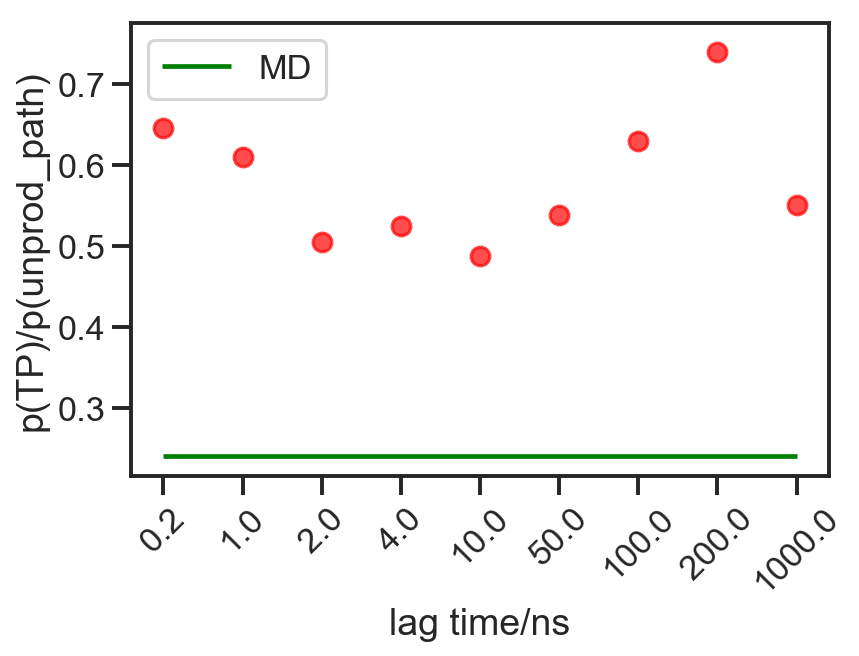

In [705]:
plt.figure(dpi=150)
plt.scatter(range(len(a/c)),a/c, c='red', alpha=0.7)

plt.xlabel('lag time/ns')
plt.xticks(range(9), lags*0.2, rotation=45)
plt.ylabel('p(TP)/p(unprod_path)')

plt.hlines(a_emp/c_emp, 0, 8, color='green', label='MD')
plt.legend(loc='best')

plt.show()

In [673]:
# let's plot p(TP)p(x|TP)/p(unprod_path)p(x|unprod_path) (i.e. product of the above two)

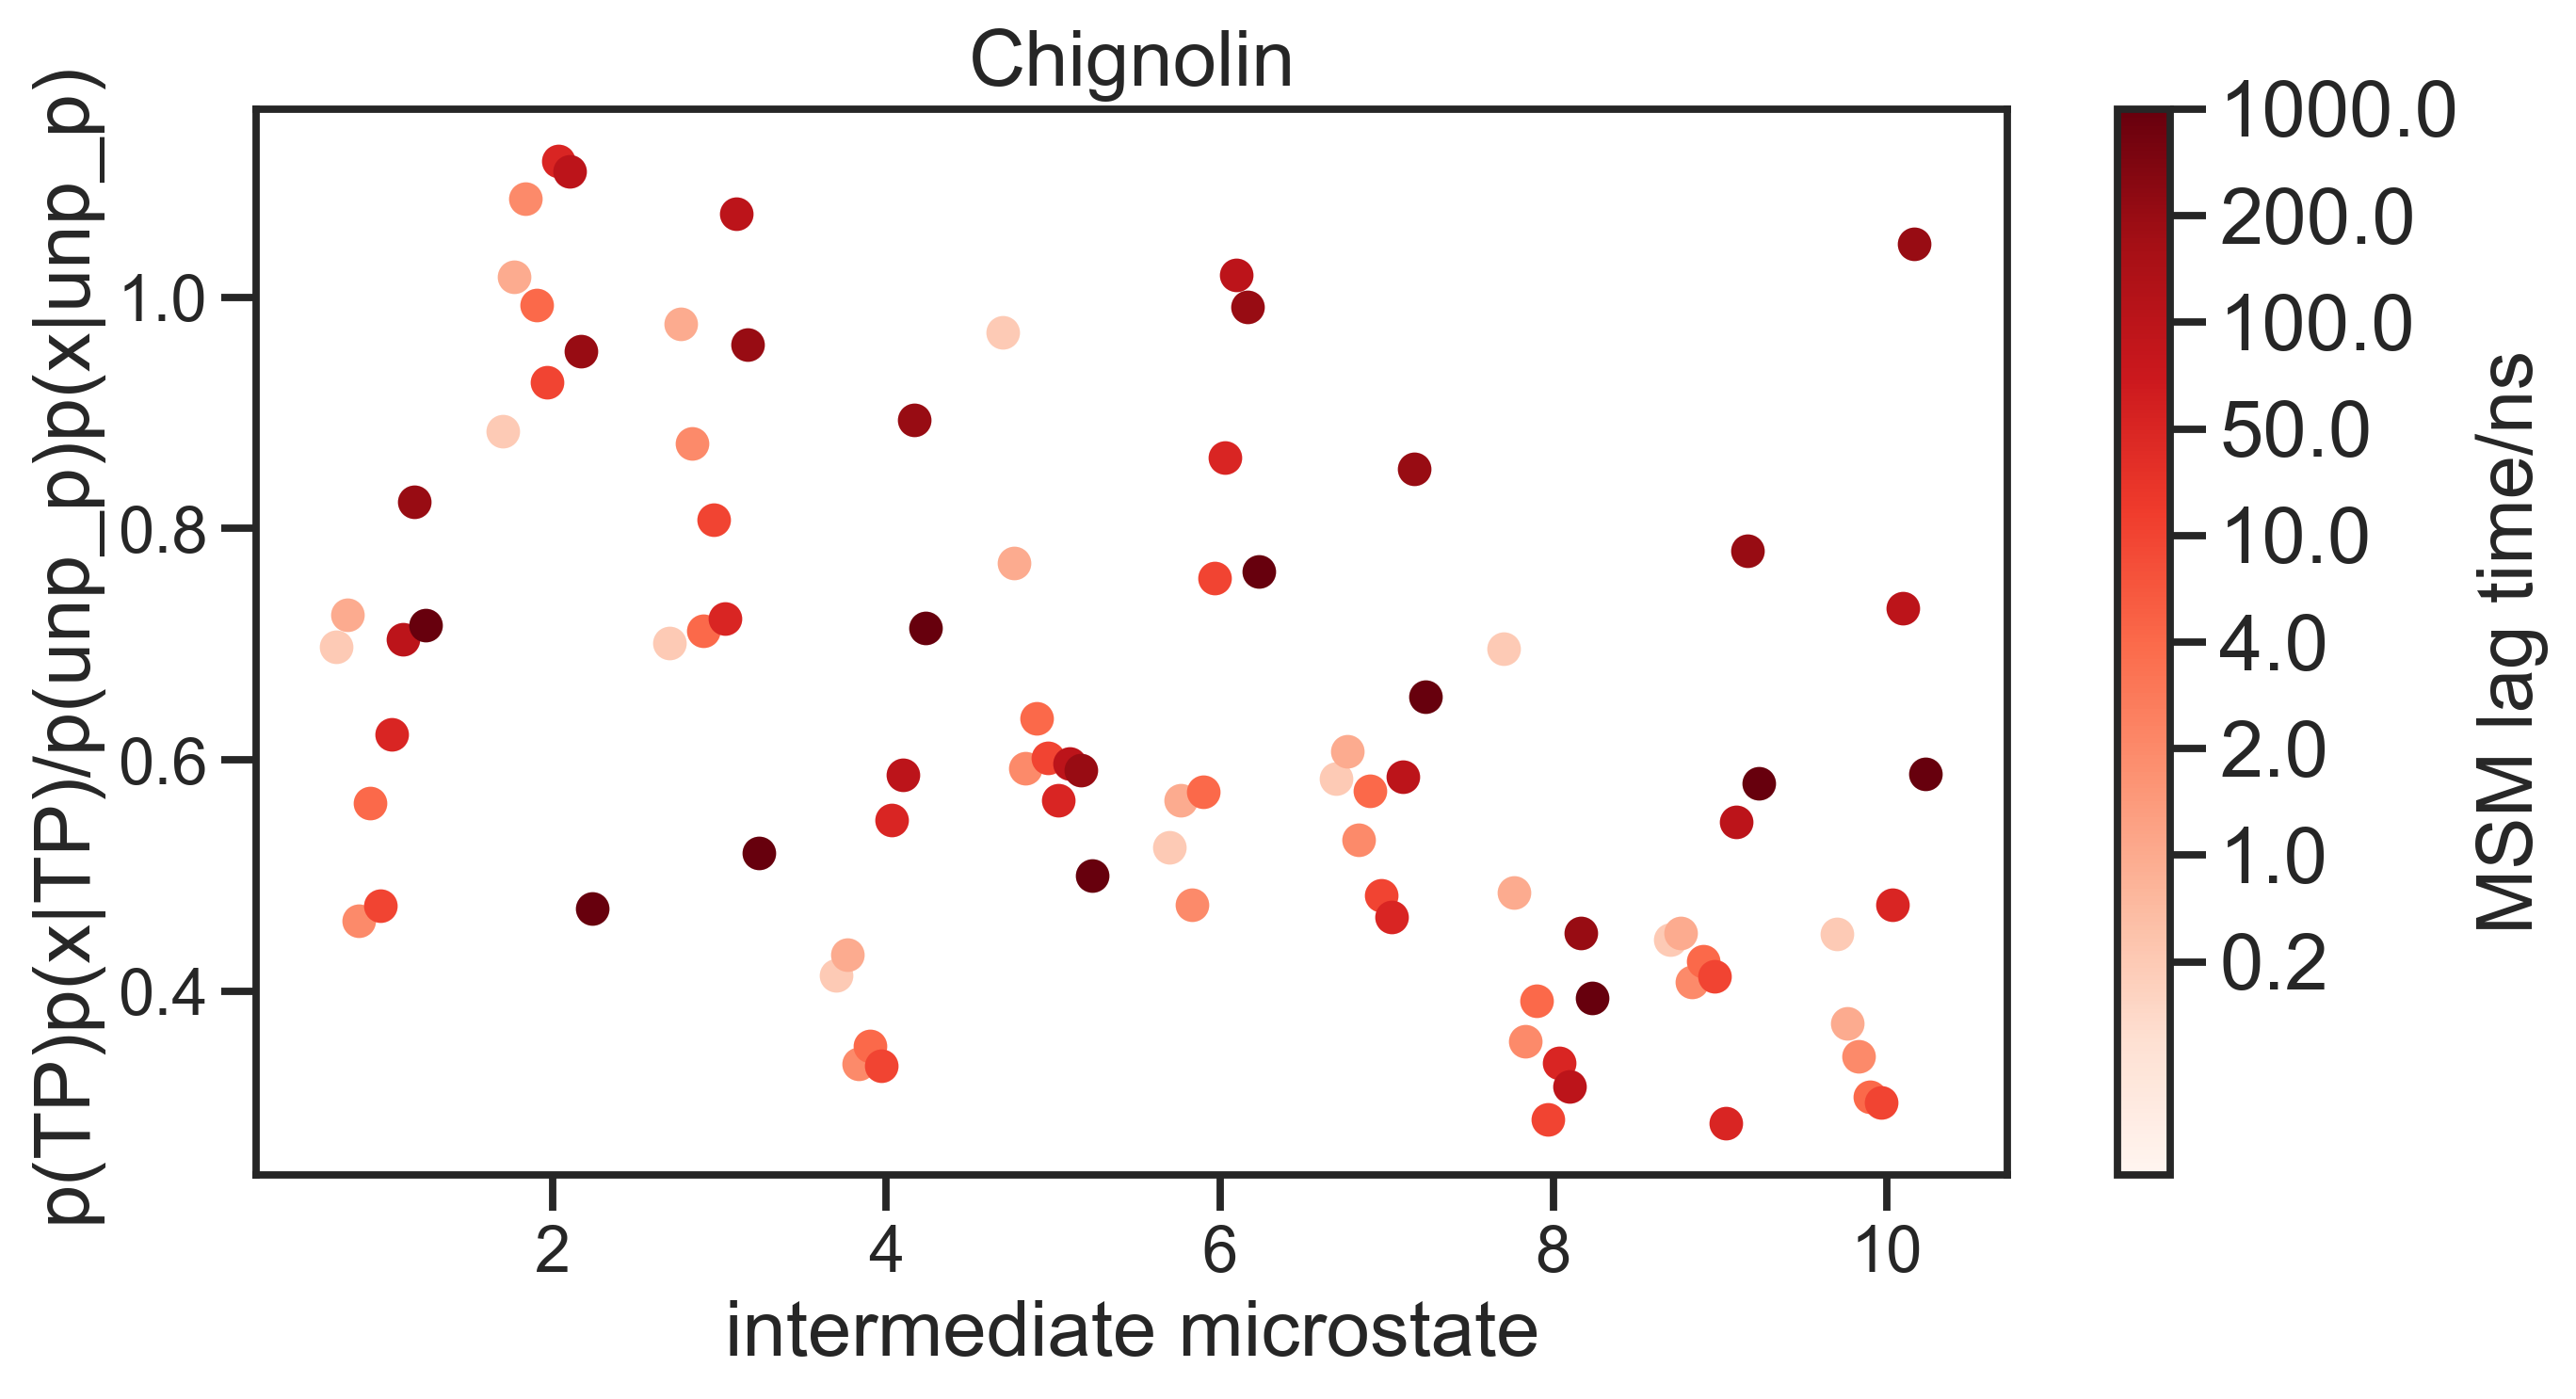

In [706]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), (counts_msm[msm_index] / counts_msm_nonprod[msm_index]) * (a/c)[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0), yerr=[(np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0)-np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 2.5, axis=0)), (np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 97.5, axis=0)-np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(TP)p(x|TP)/p(unp_p)p(x|unp_p)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

#plt.hlines(1,1,10, color='blue')

plt.show()

In [818]:
prodeq_div_unprodeq = []

for msm_index in range(9):
    prodeq_div_unprodeq.append((counts_msm[msm_index] / counts_msm_nonprod[msm_index]) * (a/c)[msm_index])

np.mean(np.std(np.array(prodeq_div_unprodeq), axis=0))

0.15541349267072374

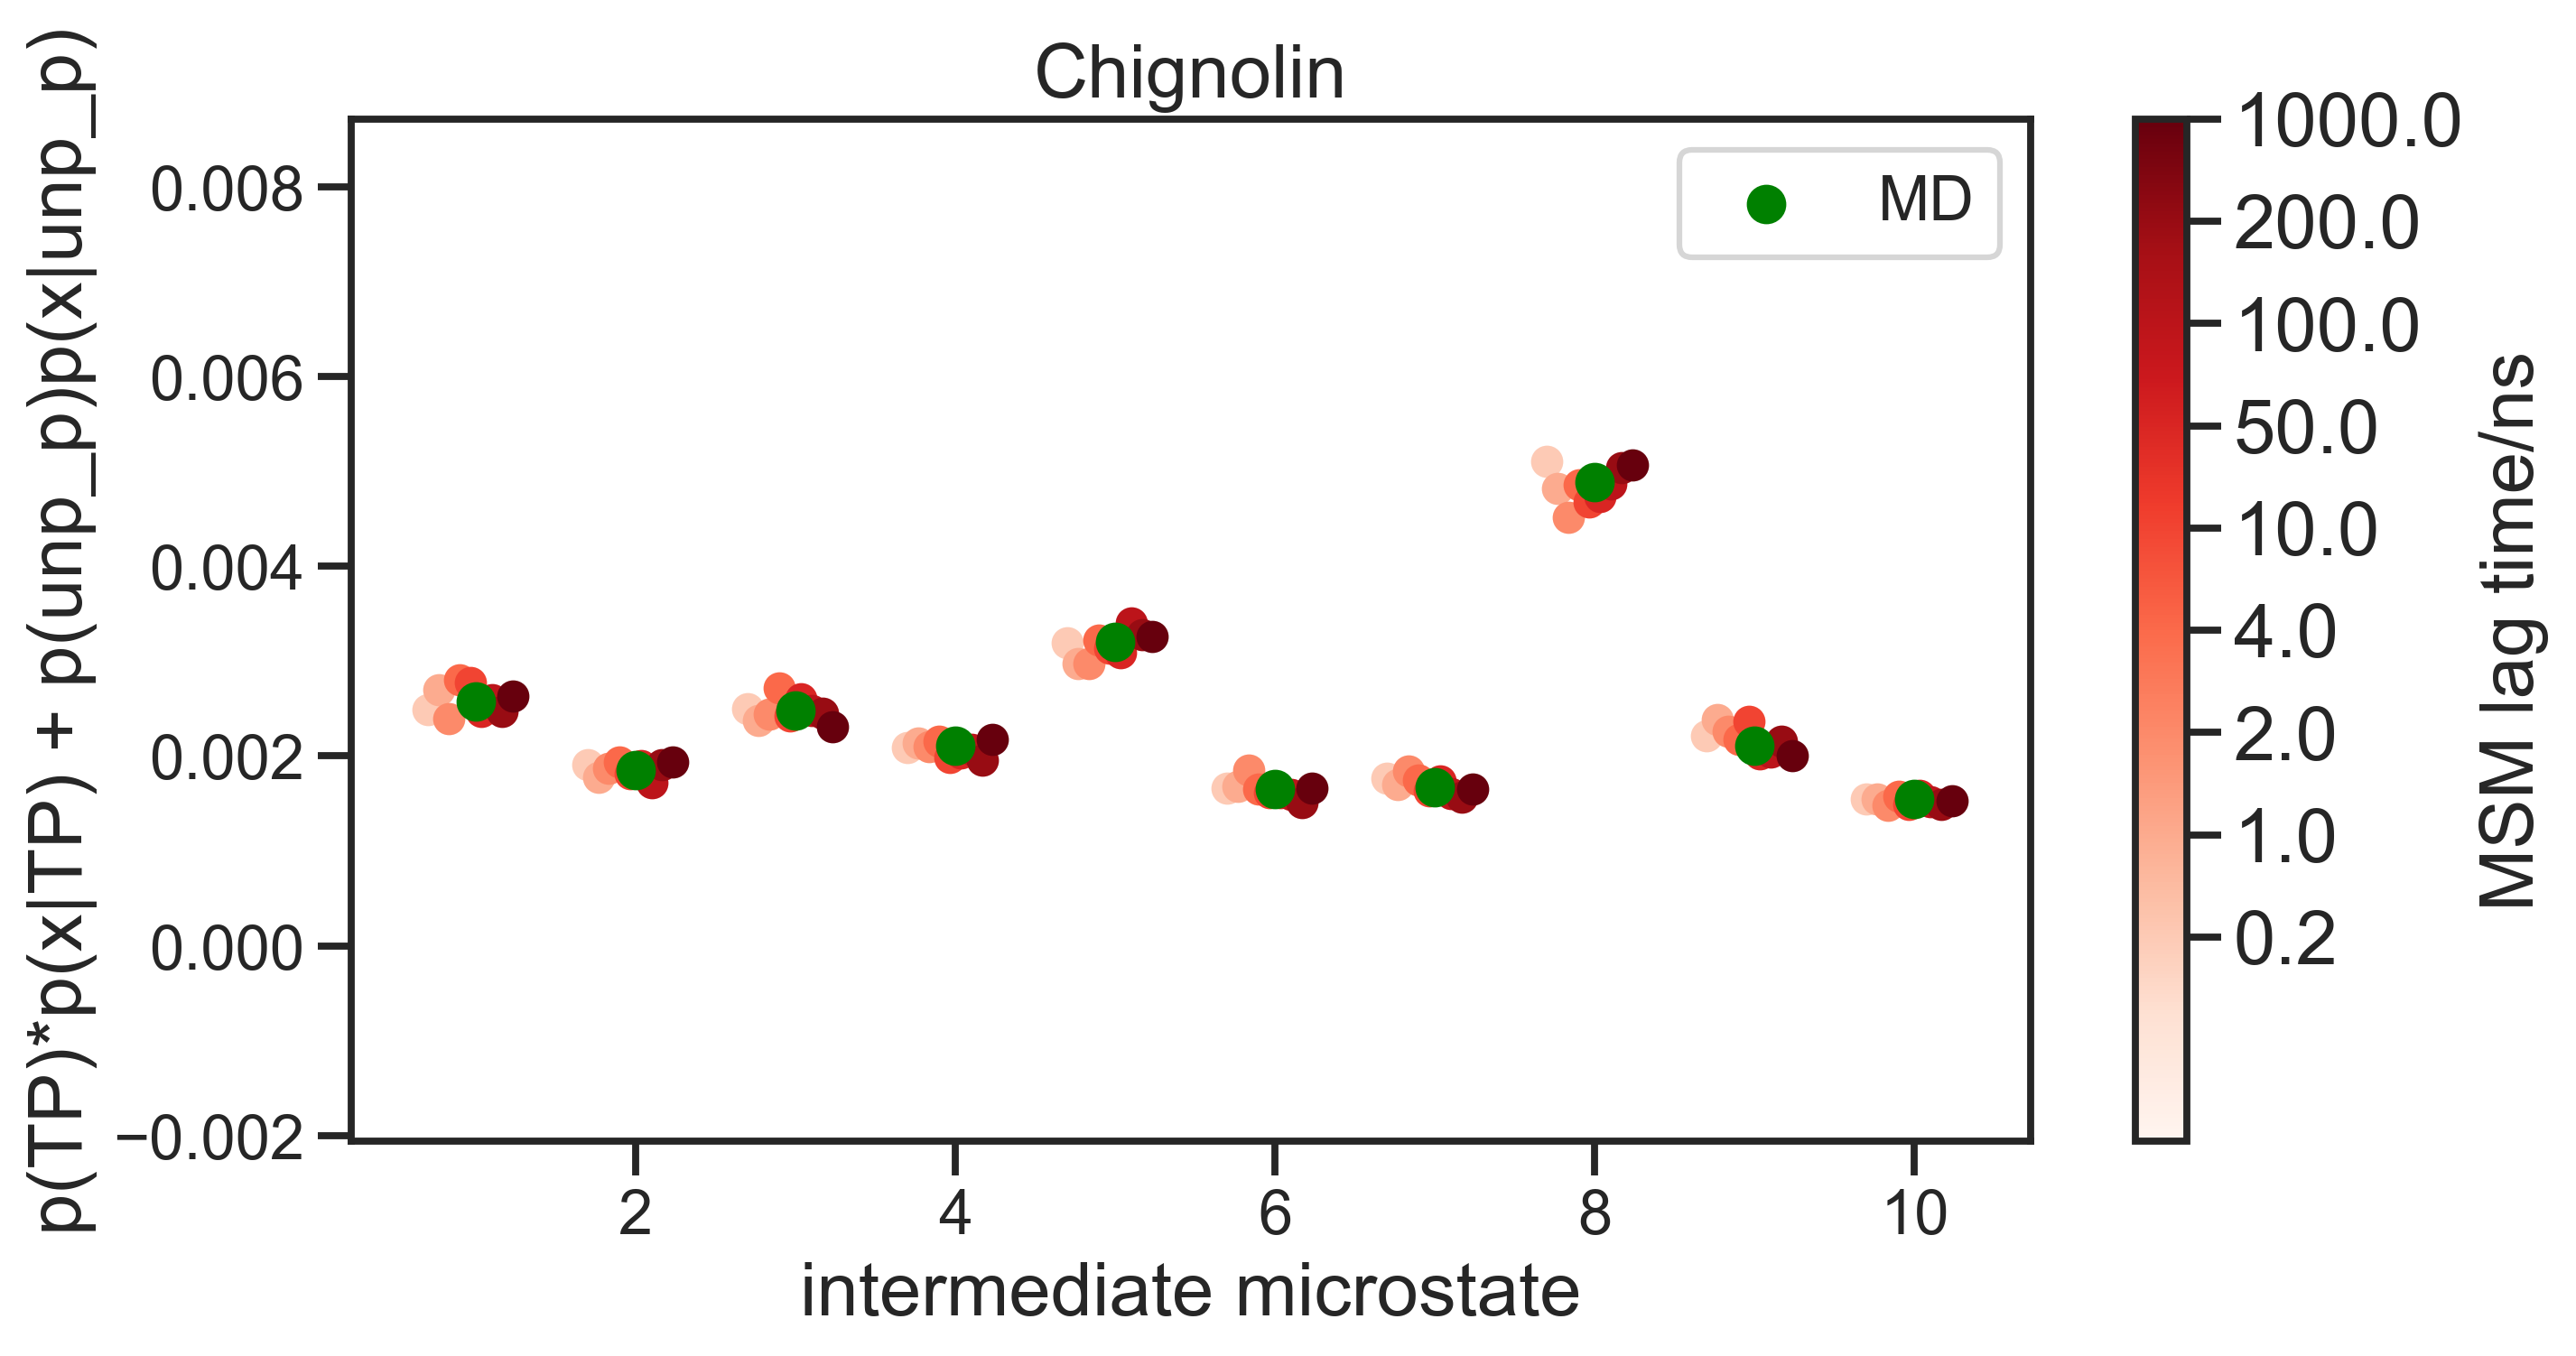

In [708]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index]*a[msm_index] + counts_msm_nonprod[msm_index]*c[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

#plt.errorbar(range(1,11), np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0), yerr=[(np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0)-np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 2.5, axis=0)), (np.percentile(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), 97.5, axis=0)-np.mean(np.array(bootstrap_counts)/np.array(bootstrap_counts_nonprod), axis=0))], color='green', label='MD (95% CI)', fmt='o')

#plt.scatter(np.arange(1,11), counts_nm, color='blue', label='haMSM (lag=0.2ns)', s=100)

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(TP)*p(x|TP) + p(unp_p)p(x|unp_p)', fontsize=20)
#plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
#plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
#plt.legend()

#plt.hlines(1,1,10, color='blue')

#plt.scatter(range(1,11),pi)
#plt.scatter(range(1,11),pi_emp, label='MD eq. pop.', color='green')
plt.scatter(range(1,11), np.mean(bootstrap_counts, axis=0)*a_emp + np.mean(bootstrap_counts_nonprod, axis=0)*c_emp, label='MD', color='green')

plt.legend()

plt.show()